In [105]:
import torch
import numpy as np
import torch.nn as nn 
import math
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from enum import Enum
from torchvision import datasets, transforms, utils
from torch.utils.data import Dataset
import pandas as pd
from skimage.util import random_noise
import imgaug as ia
import imgaug.augmenters as iaa

ia.seed(2024)

## Datasets

### MNIST

In [2]:
transform_MNIST = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

In [3]:
emnist_train_dataset = datasets.EMNIST(root='./data', split='balanced', train=True, download=False, transform=transform_MNIST)
emnist_test_dataset = datasets.EMNIST(root='./data', split='balanced', train=False, download=False, transform=transform_MNIST)

In [4]:
fashionmnist_train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_MNIST)
fashionmnist_test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_MNIST)

### CIFAR

In [5]:
transform_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

cifar10_train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar)
cifar10_test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_cifar)
cifar100_train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_cifar)
cifar100_test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_cifar)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### Dataloaders

In [119]:
emnist_train_loader = DataLoader(emnist_train_dataset, batch_size=1, shuffle=True)
emnist_test_loader = DataLoader(emnist_test_dataset, batch_size=1, shuffle=True)
fashionmnist_train_loader = DataLoader(fashionmnist_train_dataset, batch_size=1, shuffle=True)
fashionmnist_test_loader = DataLoader(fashionmnist_test_dataset, batch_size=1, shuffle=True)
cifar10_train_loader = DataLoader(cifar10_train_dataset, batch_size=1, shuffle=True)
cifar10_test_loader = DataLoader(cifar10_test_dataset, batch_size=1, shuffle=True)
cifar100_train_loader = DataLoader(cifar100_train_dataset, batch_size=1, shuffle=True)
cifar100_test_loader = DataLoader(cifar100_test_dataset, batch_size=1, shuffle=True)

## Data Augmentation

imgcorruptlike sub-library require image data at least 32x32 pixels

In [141]:
def gaussian(img, mean, var):
    return torch.tensor(random_noise(img, mode='gaussian', mean=mean, var=var, rng=2024), dtype=torch.float32)

def speckle(img, mean, var):
    return torch.tensor(random_noise(img, mode='speckle', mean=mean, var=var, rng=2024), dtype=torch.float32) 

def occlusion(image, level):
    image = denormalize_grayscale_image(image)
    occlusion = iaa.CoarseDropout(level, size_percent=1, random_state=2024)
    noisy_input = occlusion(images=image)
    noisy_input = normalize_grayscale_image(noisy_input)
    return noisy_input

def averageblur(image, level):
    image = denormalize_grayscale_image(image)
    averageblur = iaa.AverageBlur(k=(2,level), random_state=2024)
    noisy_input = averageblur(images=image)
    noisy_input = normalize_grayscale_image(noisy_input)
    return noisy_input

### The following noises cannot be applied to MNIST images


def snow(image, level):
    image = denormalize_grayscale_image(image)
    snow = iaa.imgcorruptlike.Snow(severity=level, random_state=2024)
    noisy_input = snow(images=image)
    noisy_input = normalize_grayscale_image(noisy_input)
    return noisy_input

def glassblur(image, level):
    image = denormalize_grayscale_image(image)
    glassblur = iaa.imgcorruptlike.GlassBlur(severity=level, random_state=2024)
    noisy_input = glassblur(images=image)
    noisy_input = normalize_grayscale_image(noisy_input)
    return noisy_input

def defocusblur(image, level):
    image = denormalize_grayscale_image(image)
    defocusblur = iaa.imgcorruptlike.DefocusBlur(severity=level, random_state=2024)
    noisy_input = defocusblur(images=image)
    noisy_input = normalize_grayscale_image(noisy_input)
    return noisy_input

def spatter(image, level):
    image = denormalize_grayscale_image(image)
    spatter = iaa.imgcorruptlike.DefocusBlur(severity=level, random_state=2024)
    noisy_input = spatter(images=image)
    noisy_input = normalize_grayscale_image(noisy_input)
    return noisy_input

In [239]:
variance_levels = [0.005, 0.01, 0.05, 0.1, 0.25]
severity = [1,2,3,4,5]
occlusion_levels = [0.02, 0.04, 0.06, 0.08, 0.1]
averageblur_levels = [2, 4, 6, 8, 10]

In [186]:
emnist_test_dataset_gaussian = [[(gaussian(img, 0, lev), label)for img, label in emnist_test_dataset] for lev in variance_levels]
emnist_test_dataset_speckle = [[(speckle(img, 0, lev), label)for img, label in emnist_test_dataset] for lev in variance_levels]
emnist_test_dataset_averageblur = [[(averageblur(img, lev), label)for img, label in emnist_test_dataset] for lev in averageblur_levels]
emnist_test_dataset_occlusion = [[(occlusion(img, lev), label)for img, label in emnist_test_dataset] for lev in occlusion_levels]

In [189]:
emnist_test_dataloader_gaussian = [DataLoader(dt, batch_size=1, shuffle=True) for dt in emnist_test_dataset_gaussian]
emnist_test_dataloader_speckle = [DataLoader(dt, batch_size=1, shuffle=True) for dt in emnist_test_dataset_speckle]
emnist_test_dataloader_averageblur = [DataLoader(dt, batch_size=1, shuffle=True) for dt in emnist_test_dataset_averageblur]
emnist_test_dataloader_occlusion = [DataLoader(dt, batch_size=1, shuffle=True) for dt in emnist_test_dataset_occlusion]

## Models

In [8]:
def denormalize_grayscale_image(img):
    img = (img * 255).to(torch.uint8)
    img = img.view(28, 28).numpy()
    return img

def denormalize_rgb_image(img):
    img = img.permute(0, 2, 3, 1)
    di = ((img * 0.5 + 0.5) * 255).to(torch.uint8)
    return di.squeeze().numpy()

In [86]:
def normalize_grayscale_image(img):
    return torch.from_numpy(img).view(-1).unsqueeze(0).to(torch.float32) / 255.0

In [9]:
def oneHotEncode(labels, num_classes):
    one_hot_encoded = torch.zeros(len(labels), num_classes)
    one_hot_encoded.scatter_(1, labels.unsqueeze(1), 1)
    return one_hot_encoded.squeeze()

def print_weight(model):
    for l in model.layers.values():
        print(l.feedforward.weight)

In [42]:
class Learning(Enum):
    Hebbian = 1
    Exp_Hebbian = 2
    Sanger = 3
    FullyOrthogonal = 4
    Contrastive = 5

class DatasetName(Enum):
    EMNIST = 1
    FashionMNIST = 2
    CIFAR10 = 3
    CIFAR100 = 4

class Noise(Enum):
    Gaussian = 1
    Speckle = 2
    Occlusion = 3
    AverageBlur = 4
    Snow = 5
    GlassBlur = 6
    DefocusBlur = 7
    Spatter = 8

In [314]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.layers = nn.ModuleDict()
        self.iteration = 3
    
    def add_layer(self, name, layer):
        self.layers[name] = layer

    def visualize_weights(self):
        for layer_name, module in self.layers.items():
            module.visualize_weights()

    def forward(self, x, clamped, learning):
        for layer in self.layers.values():
            x = layer(x, clamped, learning)
        return x
    
    def Hebbian_test(self, x):
        for layer in self.layers.values():
            x = layer.forward_test(x)
        return x
    
    def set_iteration(self, i):
        self.iteration = i
    
    def forward_clamped(self, x, clamped):
        input = x.detach().clone()
        layers = list(self.layers.values())
        nb_layers = len(layers)
        hlist = [None]*nb_layers
        for iter in range(self.iteration):
            hlist[-1] = clamped
            x = input
            for idx in range(nb_layers-1):
                w_topdown = layers[idx+1].feedforward.weight.detach().clone()
                h_topdown = hlist[idx+1]
                x = layers[idx].contrastive_forward(x, w_topdown, h_topdown)
                hlist[idx] = x
        return hlist

    def forward_free(self, x):
        input = x.detach().clone()
        layers = list(self.layers.values())
        nb_layers = len(layers)
        hlist = [None]*nb_layers
        for _ in range(self.iteration):
            x = input
            for idx in range(nb_layers-1):
                w = layers[idx+1].feedforward.weight.detach().clone()
                h_l = hlist[idx+1]
                x = layers[idx].contrastive_forward(x, w, h_l)
                hlist[idx] = x
            x_L = layers[-1].forward_test(hlist[-2])
            hlist[-1] = x_L
        return x_L
    
    def hebclass_forward(self, x):
        input = x.detach().clone()
        layers = list(self.layers.values())
        nb_layers = len(layers)
        hlist = [None]*nb_layers
        for _ in range(self.iteration):
            x = input
            for idx in range(nb_layers-1):
                w = layers[idx+1].feedforward.weight.detach().clone()
                h_l = hlist[idx+1]
                x = layers[idx].contrastive_forward(x, w, h_l)
                hlist[idx] = x
            x_L = layers[-1].forward_test(hlist[-2])
            hlist[-1] = x_L
        return hlist
    
    def update_weights_Contrastive(self, input, zero_clamped_hlist, label_clamped_hlist):
        # print(zero_clamped_hlist)
        # print(label_clamped_hlist)
        layers = list(self.layers.values())
        nb_layers = len(layers)
        for idx in range(nb_layers):
            if idx == 0:
                outer_label = torch.outer(label_clamped_hlist[idx].squeeze(0), input.squeeze(0))
                outer_zero = torch.outer(zero_clamped_hlist[idx].squeeze(0), input.squeeze(0))
                delta_weight = layers[idx].lr*(outer_label - outer_zero)

                # delta_bias = label_clamped_hlist[idx].squeeze(0) - zero_clamped_hlist[idx].squeeze(0)

                # print(outer_label - outer_zero)
                # if torch.isnan(delta_weight).all():
                #     print("NaN delta W on layer 0")
                #     print("Clamped Input Signal :")
                #     print(input.squeeze(0))
                #     print("Zero Clamped hs:")
                #     print(zero_clamped_hlist)
                #     print("Label Clamped hs:")
                #     print(label_clamped_hlist)
                #     print("Weights:")
                #     print(layers[idx].feedforward.weight)

            elif idx == (nb_layers-1):
                outer_label = torch.outer(label_clamped_hlist[idx].squeeze(0), label_clamped_hlist[idx-1].squeeze(0))
                delta_weight = layers[idx].lr*(outer_label)

                # delta_bias = label_clamped_hlist[idx].squeeze(0)
                # print(outer_label - outer_zero)
               
            else:
                outer_label = torch.outer(label_clamped_hlist[idx].squeeze(0), label_clamped_hlist[idx-1].squeeze(0))
                outer_zero = torch.outer(zero_clamped_hlist[idx].squeeze(0), zero_clamped_hlist[idx-1].squeeze(0))
                delta_weight = layers[idx].lr*(outer_label - outer_zero)

                # delta_bias = label_clamped_hlist[idx].squeeze(0) - zero_clamped_hlist[idx].squeeze(0)
                # print(outer_label - outer_zero)

            initial_weights = layers[idx].feedforward.weight.detach().clone()
            layers[idx].feedforward.weight=nn.Parameter(torch.add(initial_weights, delta_weight), requires_grad=False)
            # initial_biases = layers[idx].feedforward.bias.detach().clone()
            # layers[idx].feedforward.bias=nn.Parameter(torch.add(initial_biases, delta_bias), requires_grad=False)
            return delta_weight
    
    def update_weights(self, input, all_hlist, learning, output):
        allh = [input] + all_hlist
        allh[-1] = allh[-1].unsqueeze(0)
        layers = list(self.layers.values())
        layer_names = list(self.layers.keys())
        nb_layers = len(layers)
        if learning == Learning.Hebbian:
            for idx in range(nb_layers):
                if layer_names[idx] == "Classifier":
                    layers[idx].update_weights(allh[idx], allh[idx+1], output)
                else:
                    layers[idx].update_weights_Hebb(allh[idx], allh[idx+1])
                    layers[idx].weight_decay()
        elif learning == Learning.Exp_Hebbian:
            for idx in range(nb_layers):
                if layer_names[idx] == "Classifier":
                    layers[idx].update_weights(allh[idx], allh[idx+1], output)
                else:
                    layers[idx].update_weights_Hebb_exp(allh[idx], allh[idx+1])
                    layers[idx].weight_decay()
        elif learning == Learning.Sanger:
            for idx in range(nb_layers):
                if layer_names[idx] == "Classifier":
                    layers[idx].update_weights(allh[idx], allh[idx+1], output)
                else:
                    layers[idx].update_weights_Sanger(allh[idx], allh[idx+1])
                    layers[idx].weight_decay()
        elif learning == Learning.FullyOrthogonal:
            for idx in range(nb_layers):
                if layer_names[idx] == "Classifier":
                    layers[idx].update_weights(allh[idx], allh[idx+1], output)
                else:
                    layers[idx].update_weights_FullyOrthogonal(allh[idx], allh[idx+1])
                    layers[idx].weight_decay()


    def contrastive(self, x, labels, learning=Learning.Sanger):
        input = x.detach().clone()
        all_hlist_label = self.forward_clamped(x, labels)
        if learning == Learning.Contrastive:
            all_hlist_zero = self.forward_clamped(x, None)
            dw = self.update_weights_Contrastive(input, all_hlist_zero, all_hlist_label)
        else:
            # all_hlist_zero = self.forward_clamped(x, None)
            self.update_weights(input, all_hlist_label, learning, labels)
    
    def contrastive_hebclass(self, x, labels, learning):
        input = x.detach().clone()
        all_hlist = self.hebclass_forward(x)
        self.update_weights(input, all_hlist, learning, labels)
        

In [33]:
class Hebbian_Layer(nn.Module):
    def __init__(self, inputdim, outputdim, lr, lamb, w_decrease, gamma, eps, is_output_layer=False):
        super(Hebbian_Layer, self).__init__()
        self.input_dim = inputdim
        self.output_dim = outputdim
        self.lr = lr
        self.lamb = lamb
        self.decrease = w_decrease
        self.gamma = gamma
        self.epsilon = eps
        self.is_output_layer = is_output_layer

        self.feedforward = nn.Linear(self.input_dim, self.output_dim, bias=False)

        for param in self.feedforward.parameters():
            param=torch.nn.init.uniform_(param, a=0.0, b=1.0)
            param.requires_grad_(False)
        

        # self.itensors=self.createITensors()
        self.exponential_average=torch.zeros(self.output_dim)

    # def createITensors(self):
    #     itensors=torch.zeros(self.output_dim, self.output_dim, self.output_dim, dtype=torch.float)
    #     for i in range(0, self.output_dim):
    #         identity = torch.eye(i+1)
    #         padded_identity = torch.nn.functional.pad(identity, (0, self.output_dim - i-1, 0, 
    #                                                              self.output_dim - i-1))
    #         itensors[i]=padded_identity
    #     return itensors

    def inhibition(self, x):
        x=nn.ReLU()(x)
        max_ele=torch.max(x).item()
        x=torch.pow(x, self.lamb)
        x/=abs(max_ele)**self.lamb
        return x

    # Classic Hebbian
    def update_weights_Hebb(self, input, output):
        x=input.detach().clone().squeeze()
        y=output.detach().clone().squeeze()
        outer_prod=torch.outer(y, x)
        delta_weight = self.lr*(outer_prod)
        self.feedforward.weight=nn.Parameter(torch.add(self.feedforward.weight, delta_weight), requires_grad=False)
        self.exponential_average=torch.add(self.gamma*self.exponential_average,(1-self.gamma)*y)
    
    # Exponential Hebbian 
    def update_weights_Hebb_exp(self, input, output):
        x=input.detach().clone().squeeze()
        y=output.detach().clone().squeeze()
        outer_prod=torch.outer(y, x)
        initial_weights = self.feedforward.weight.detach().clone()
        delta_weight = self.lr*(outer_prod - initial_weights)
        self.feedforward.weight=nn.Parameter(torch.add(self.feedforward.weight, delta_weight), requires_grad=False)
        self.exponential_average=torch.add(self.gamma*self.exponential_average,(1-self.gamma)*y)

    # # Sanger's rule
    # def update_weights_Sanger(self, input, output):
    #     x=input.detach().clone().squeeze()
    #     y=output.detach().clone().squeeze()
    #     outer_prod=torch.outer(y, x)
    #     initial_weight=torch.transpose(self.feedforward.weight.detach().clone(), 0,1)
    #     A=torch.einsum('jk, lkm, m -> lj', initial_weight, self.itensors, y)
    #     A=A*(y.unsqueeze(1))
    #     delta_weight=self.lr*(outer_prod-A)
    #     self.feedforward.weight=nn.Parameter(torch.add(self.feedforward.weight, delta_weight), requires_grad=False)
    #     self.exponential_average=torch.add(self.gamma*self.exponential_average,(1-self.gamma)*y)


    '''
    Sanger's rule
    -------------

    input : [batch_size, features]
    output : [batch_size, dim]

    projections : [batch_size, features]
    output[:, :i+1] : [batch_size] 
    input - projections : [batch_size, features]

    element-wise multiplication of y_i over (input - projections) 
    '''
    def update_weights_Sanger(self, input, output):

        y=output.detach().clone().squeeze()
    
        weights = self.feedforward.weight.detach()
        output_dim = weights.shape[0]

        delta_weights = torch.zeros_like(weights)

        for i in range(output_dim):
            projections = torch.matmul(output[:, :i+1], weights[:i+1])
            delta_w = self.lr * torch.mean((output[:, i].unsqueeze(1) * (input - projections)), dim=0)
            delta_weights[i] = delta_w

        self.feedforward.weight=nn.Parameter(torch.add(self.feedforward.weight, delta_weights), requires_grad=False)
        self.exponential_average=torch.add(self.gamma*self.exponential_average,(1-self.gamma)*y)
        

    # Fully orthogonal Sanger variant
    def update_weights_FullyOrthogonal(self, input, output):
        x=input.detach().clone().squeeze()
        y=output.detach().clone().squeeze()
        initial_weight = self.feedforward.weight.detach().clone()
        outer_prod = torch.outer(y, x)
        ytw = torch.matmul(y.unsqueeze(0), initial_weight)
        norm_term = torch.outer(y.squeeze(0), ytw.squeeze(0))
        delta_weight = self.lr*(outer_prod - norm_term)
        self.feedforward.weight=nn.Parameter(torch.add(self.feedforward.weight, delta_weight), requires_grad=False)
        self.exponential_average=torch.add(self.gamma*self.exponential_average,(1-self.gamma)*y)
        # self.updateBias(output)
        

    def weight_decay(self):
        average=torch.mean(self.exponential_average).item()
        A=self.exponential_average/average
        growth_factor_positive=self.epsilon*nn.Tanh()(-self.epsilon*(A-1))+1
        growth_factor_negative=torch.reciprocal(growth_factor_positive)
        positive_weights=torch.where(self.feedforward.weight>0, self.feedforward.weight, 0.0)
        negative_weights=torch.where(self.feedforward.weight<0, self.feedforward.weight, 0.0)
        positive_weights=positive_weights*growth_factor_positive.unsqueeze(1)
        negative_weights=negative_weights*growth_factor_negative.unsqueeze(1)
        self.feedforward.weight=nn.Parameter(torch.add(positive_weights, negative_weights), requires_grad=False)

    def visualize_weights(self):
        nb = int(math.ceil(math.sqrt(self.output_dim)))
        if not self.is_output_layer:
            fig, axes = plt.subplots(nb, nb, figsize=(32,32))
            nb_ele = self.output_dim
        else :
            nb_ele = self.output_dim
            fig, axes = plt.subplots(nb_ele, figsize=(32, 32))
            
        weight = self.feedforward.weight
        for ele in range(nb_ele):
            random_feature_selector = weight[ele]
            heatmap = random_feature_selector.view(int(math.sqrt(weight.size(1))),
                                                    int(math.sqrt(weight.size(1))))
            ax = axes[ele // nb, ele % nb]
            im = ax.imshow(heatmap, cmap='hot', interpolation='nearest')
            fig.colorbar(im, ax=ax)
            ax.set_title(f'Weight {ele}')

        plt.tight_layout()
        plt.show()
            

    def forward(self, x, clamped=None, learning=1):
        input = x.detach().clone()
        x = self.feedforward(x)
        x = self.inhibition(x)
        if learning == Learning.Hebbian:
            self.update_weights_Hebb(input, x)
        elif learning == Learning.Exp_Hebbian:
            self.update_weights_Hebb_exp(input, x)
        elif learning == Learning.Sanger:
            self.update_weights_Sanger(input, x)
        elif learning == Learning.FullyOrthogonal:
            self.update_weights_FullyOrthogonal(input, x)
        self.weight_decay()
        return x
            
    def forward_test(self, x):
        x = self.feedforward(x)
        x = self.inhibition(x)
        return x
    
    def contrastive_forward(self, x, w, h_l):
        if h_l == None:
            h = self.feedforward(x)
        else :
            w = self.decrease*w
            h = self.feedforward(x) + torch.matmul(h_l, w)
        return self.inhibition(h)

In [332]:
class Classifier_Layer(nn.Module):
    def __init__(self, inputdim, outputdim, lr):
        super(Classifier_Layer, self).__init__()
        self.input_dim = inputdim
        self.output_dim = outputdim
        self.lr = lr

        self.feedforward = nn.Linear(self.input_dim, self.output_dim)

    
    def update_weights(self, input, output, clamped):
        u=output.detach().clone().squeeze()
        x=input.detach().clone().squeeze()
        y=torch.softmax(u, dim=0)
        A=None
        if clamped != None:
            outer_prod=torch.outer(clamped-y,x)
            u_times_y=torch.mul(u,y)
            A=outer_prod-self.feedforward.weight*(u_times_y.unsqueeze(1))
        else:
            A=torch.outer(y,x)
        A=self.feedforward.weight+self.lr*A
        weight_maxes=torch.max(A, dim=1).values
        self.feedforward.weight=nn.Parameter(A/weight_maxes.unsqueeze(1), requires_grad=False)
        self.feedforward.weight[:, 0] = 0
    
    def forward(self, x, clamped, learning=None):
        input = x.detach().clone()
        x=self.feedforward(x)
        self.update_weights(input, x, clamped)
        x=nn.Softmax()(x)
        return x
    
    def forward_test(self, x):
        x = self.feedforward(x)
        x=nn.Softmax(dim=-1)(x)
        return x

    def contrastive_forward(self, x, wT, xhat, clamped):
        input = x.detach().clone()
        if wT == None and xhat == None:
            h = self.feedforward(x)
        else : 
            h = self.feedforward(x) + torch.matmul(xhat,wT)
        self.update_weights(input, h, clamped)
        h = nn.Softmax()(h)
        return h

    def visualize_weights(self):
        weight = self.feedforward.weight
        nb_ele = self.feedforward.weight.size(0)
        nb = math.ceil(math.sqrt(nb_ele))
        fig, axes = plt.subplots(nb, nb, figsize=(32,32))
        for ele in range(nb_ele):
            random_feature_selector = weight[ele]
            heatmap = random_feature_selector.view(int(math.sqrt(self.feedforward.weight.size(1))),
                                                    int(math.sqrt(self.feedforward.weight.size(1))))
            ax = axes[ele // nb, ele % nb]
            im = ax.imshow(heatmap, cmap='hot', interpolation='nearest')
            fig.colorbar(im, ax=ax)
            ax.set_title(f'Weight {ele}')
        plt.tight_layout()
        plt.show()

## MLP-Baseline

In [191]:
def MLPBaseline_Experiment(hsize, lamb, lr, learning, e, dataloader, nclasses):

    mymodel = NeuralNet()
    heb_layer = Hebbian_Layer(784, hsize, lr, lamb, 0.8, 0.95, e)
    class_layer = Classifier_Layer(hsize, nclasses, lr)

    mymodel.add_layer("Hebbian1", heb_layer)
    mymodel.add_layer("Class", class_layer)

    mymodel.train()

    for _ in range(3):
        for data in tqdm(dataloader):
            inputs, labels=data
            mymodel.forward(inputs, oneHotEncode(labels, nclasses), learning)
    
    return mymodel

In [15]:
def MLPBaseline_test_accuracy(mymodel, data_loader):
    yes = 0
    tot = 0
    da = {}
    for data in tqdm(data_loader):
        inputs, labels = data
        output = torch.argmax(mymodel.Hebbian_test(inputs))
        if labels.item() not in da:
            da[labels.item()] = (0, 0)
        r, t = da[labels.item()]
        if output.item() == labels.item():
            yes += 1
            da[labels.item()] = (r+1, t+1)
        else :
            da[labels.item()] = (r, t+1)
        tot += 1
    return (yes/tot), da

## Top Down

In [262]:
def TopDownBaseline_Experiment(hsize, lamb, lr, learning, e, dataloader, nclasses):

    mymodel = NeuralNet()
    heb_layer = Hebbian_Layer(784, hsize, lr, lamb, 0.8, 0.95, e)
    class_layer = Classifier_Layer(hsize, nclasses, lr)

    mymodel.add_layer("Hebbian1", heb_layer)
    mymodel.add_layer("Classifier", class_layer)

    mymodel.train()

    for _ in range(3):
        for data in tqdm(dataloader):
            inputs, labels=data
            mymodel.contrastive_hebclass(inputs, oneHotEncode(labels, nclasses), learning)
    
    return mymodel

In [343]:
def TopDownBaseline_test_accuracy(mymodel, data_loader):
    yes = 0
    tot = 0
    da = {}
    for data in tqdm(data_loader):
        inputs, labels = data
        # print(inputs)
        # plt.imshow(denormalize_grayscale_image(inputs))
        # plt.show()
        output = mymodel.forward_free(inputs)
        # print(labels.item())
        output = torch.argmax(output)
        # print(output.item())
        if labels.item() not in da:
            da[labels.item()] = (0, 0)
        r, t = da[labels.item()]
        if output.item() == labels.item():
            yes += 1
            da[labels.item()] = (r+1, t+1)
        else :
            da[labels.item()] = (r, t+1)
        tot += 1
    return (yes/tot), da

# EMNIST - Experiments

## Noise Visualization

### Gaussian

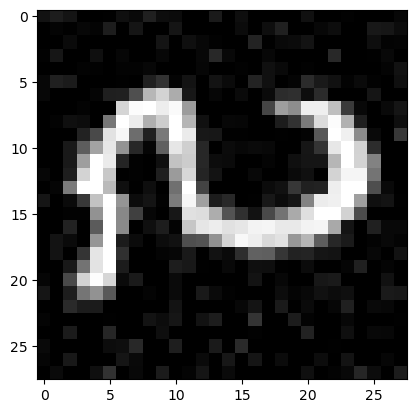

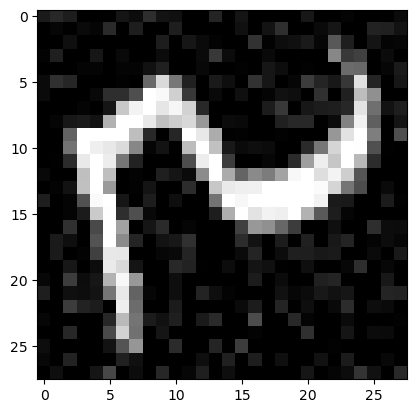

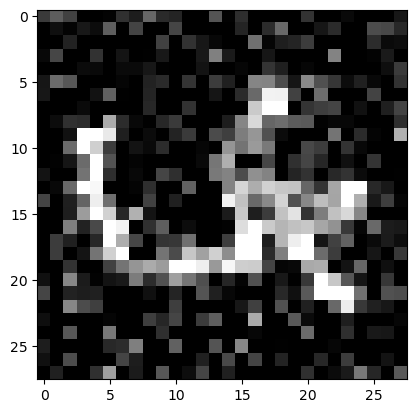

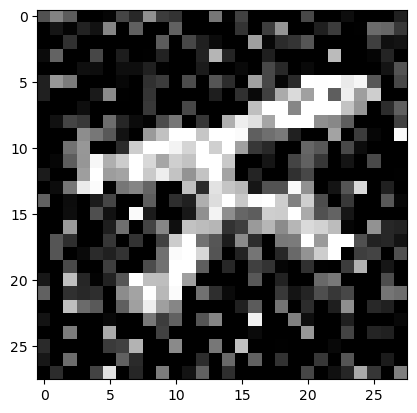

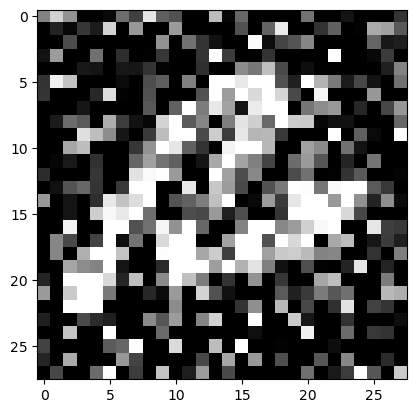

In [371]:
for idx in range(5):
    for data in emnist_test_dataloader_gaussian[idx]:
        inputs, label = data
        plt.imshow(denormalize_grayscale_image(inputs), cmap='gray')
        plt.show()
        break

### Speckle

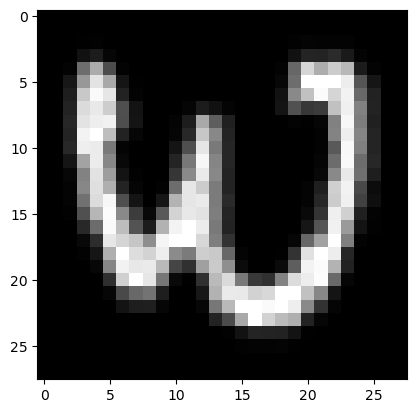

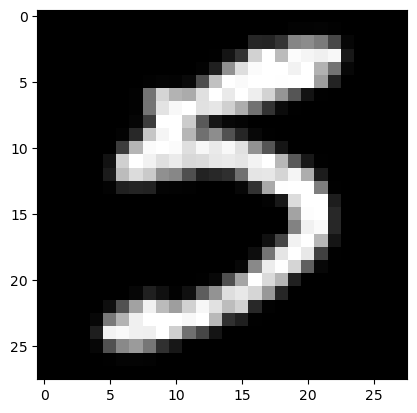

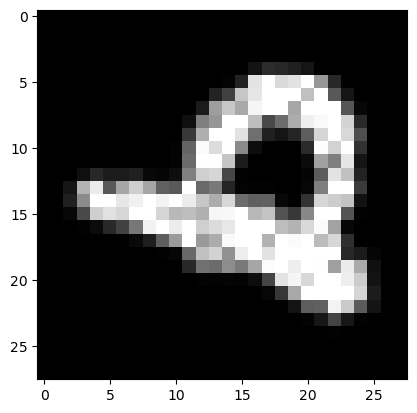

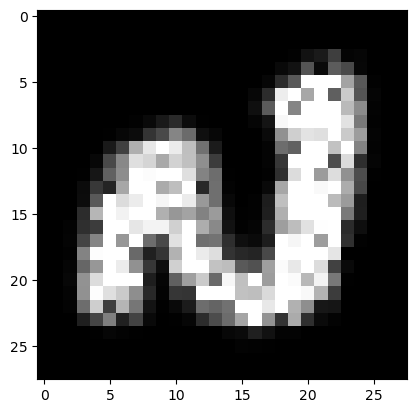

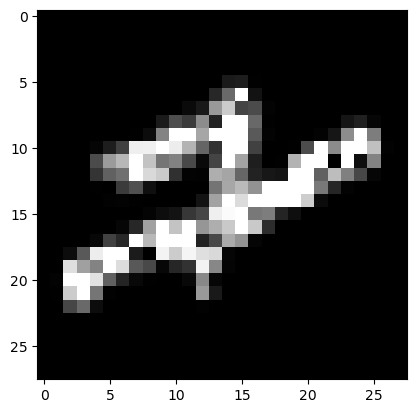

In [372]:
for idx in range(5):
    for data in emnist_test_dataloader_speckle[idx]:
        inputs, label = data
        plt.imshow(denormalize_grayscale_image(inputs), cmap='gray')
        plt.show()
        break

### Occlusion

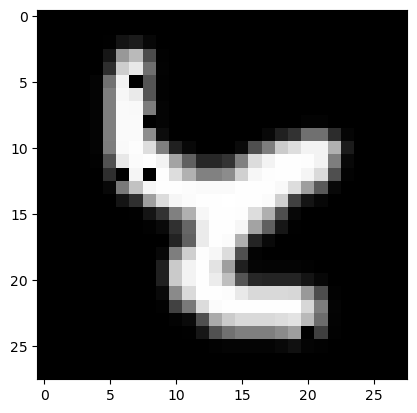

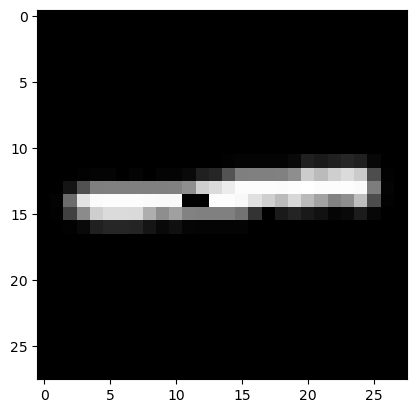

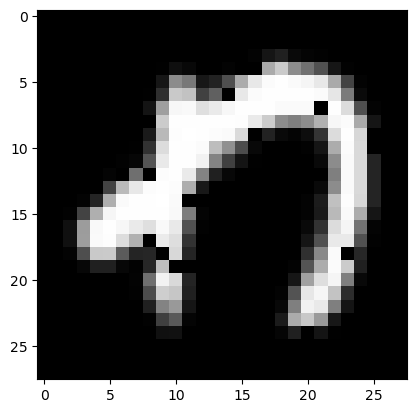

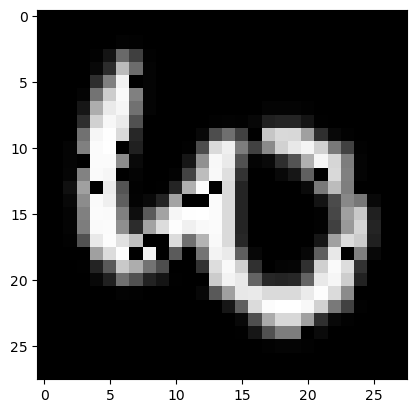

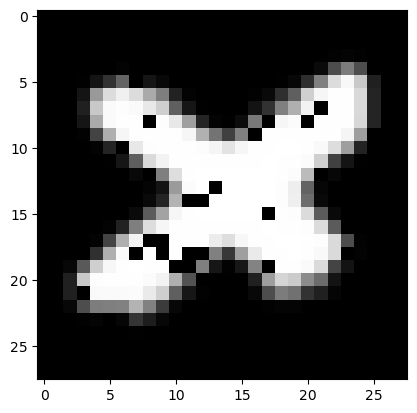

In [373]:
for idx in range(5):
    for data in emnist_test_dataloader_occlusion[idx]:
        inputs, label = data
        plt.imshow(denormalize_grayscale_image(inputs), cmap='gray')
        plt.show()
        break

### Average Blur

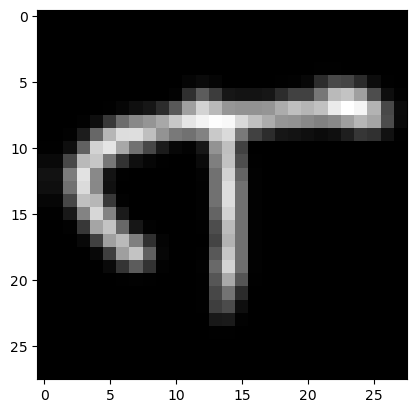

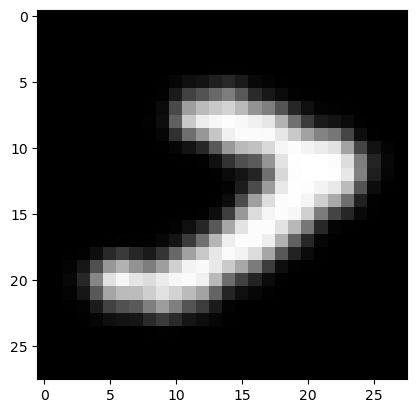

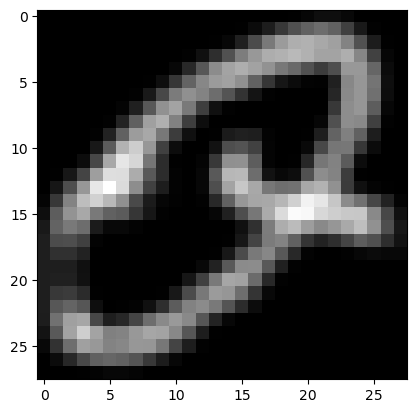

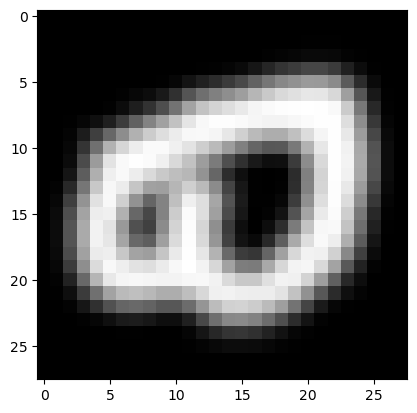

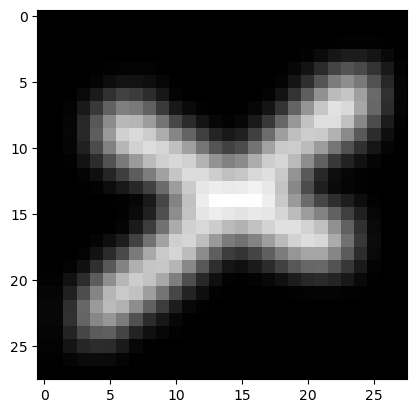

In [374]:
for idx in range(5):
    for data in emnist_test_dataloader_averageblur[idx]:
        inputs, label = data
        plt.imshow(denormalize_grayscale_image(inputs), cmap='gray')
        plt.show()
        break

## MLP

### No Noise

In [16]:
lambs = [0.4, 0.7, 1, 2, 5, 8, 11, 14, 15]
eps = [0.001, 0.01, 0.1]

In [17]:
for l in lambs:
    for e in eps:
        print("Hyper params : lambda = " + str(l) + ", epsilon = " + str(e))
        MLPBaseline_EMNIST = MLPBaseline_Experiment(hsize=64, lamb=l, lr=0.005, learning=Learning.FullyOrthogonal, e=e, dataset=DatasetName.EMNIST)
        print(MLPBaseline_test_accuracy(MLPBaseline_EMNIST, emnist_train_loader))
        print(MLPBaseline_test_accuracy(MLPBaseline_EMNIST, emnist_test_loader))

Hyper params : lambda = 0.4, epsilon = 0.001


  0%|          | 0/112800 [00:00<?, ?it/s]

/Users/zhaoyizhe/miniconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.30347517730496454, {46: (1495, 2400), 22: (1330, 2400), 15: (454, 2400), 39: (1948, 2400), 19: (245, 2400), 25: (321, 2400), 27: (245, 2400), 32: (1602, 2400), 0: (108, 2400), 11: (234, 2400), 43: (1209, 2400), 7: (756, 2400), 41: (210, 2400), 3: (428, 2400), 26: (911, 2400), 38: (1113, 2400), 16: (1297, 2400), 44: (1122, 2400), 14: (377, 2400), 24: (313, 2400), 1: (122, 2400), 33: (1358, 2400), 45: (742, 2400), 31: (745, 2400), 29: (936, 2400), 18: (1874, 2400), 6: (599, 2400), 35: (587, 2400), 8: (297, 2400), 30: (1349, 2400), 21: (31, 2400), 2: (195, 2400), 34: (262, 2400), 28: (1, 2400), 42: (427, 2400), 12: (553, 2400), 4: (1059, 2400), 13: (466, 2400), 23: (1368, 2400), 20: (1243, 2400), 36: (366, 2400), 5: (744, 2400), 37: (1506, 2400), 9: (0, 2400), 10: (566, 2400), 40: (513, 2400), 17: (605, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.2996276595744681, {7: (120, 400), 39: (320, 400), 42: (80, 400), 38: (199, 400), 1: (14, 400), 30: (229, 400), 29: (153, 400), 26: (152, 400), 9: (0, 400), 17: (107, 400), 35: (83, 400), 45: (111, 400), 22: (214, 400), 11: (46, 400), 4: (157, 400), 28: (0, 400), 20: (217, 400), 32: (295, 400), 16: (215, 400), 10: (96, 400), 44: (191, 400), 15: (85, 400), 13: (83, 400), 0: (19, 400), 3: (72, 400), 12: (97, 400), 2: (38, 400), 33: (215, 400), 36: (66, 400), 40: (67, 400), 23: (225, 400), 14: (62, 400), 43: (185, 400), 46: (247, 400), 19: (44, 400), 6: (95, 400), 25: (54, 400), 18: (292, 400), 37: (246, 400), 5: (135, 400), 8: (38, 400), 24: (59, 400), 21: (3, 400), 31: (112, 400), 34: (36, 400), 41: (30, 400), 27: (29, 400)})
Hyper params : lambda = 0.4, epsilon = 0.01


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.44141843971631206, {11: (619, 2400), 44: (484, 2400), 21: (63, 2400), 16: (1328, 2400), 33: (1324, 2400), 43: (1131, 2400), 8: (467, 2400), 32: (1703, 2400), 20: (1013, 2400), 34: (275, 2400), 9: (1380, 2400), 19: (594, 2400), 7: (1634, 2400), 41: (442, 2400), 29: (1236, 2400), 0: (1094, 2400), 38: (1399, 2400), 31: (1395, 2400), 14: (1068, 2400), 46: (881, 2400), 1: (1013, 2400), 39: (1175, 2400), 40: (890, 2400), 37: (1213, 2400), 13: (1100, 2400), 17: (843, 2400), 45: (1483, 2400), 42: (1285, 2400), 26: (1330, 2400), 15: (282, 2400), 24: (988, 2400), 5: (840, 2400), 28: (884, 2400), 22: (1760, 2400), 27: (494, 2400), 10: (651, 2400), 23: (1394, 2400), 2: (887, 2400), 36: (1352, 2400), 6: (1649, 2400), 12: (1256, 2400), 3: (1742, 2400), 35: (1259, 2400), 18: (1147, 2400), 30: (816, 2400), 4: (1087, 2400), 25: (1442, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.4372872340425532, {17: (135, 400), 37: (175, 400), 45: (233, 400), 44: (79, 400), 28: (146, 400), 32: (314, 400), 29: (185, 400), 33: (212, 400), 5: (132, 400), 7: (272, 400), 19: (92, 400), 16: (222, 400), 43: (187, 400), 2: (164, 400), 12: (211, 400), 25: (227, 400), 3: (320, 400), 40: (135, 400), 42: (227, 400), 1: (167, 400), 18: (171, 400), 13: (179, 400), 24: (180, 400), 31: (227, 400), 14: (188, 400), 30: (130, 400), 38: (233, 400), 15: (42, 400), 22: (280, 400), 23: (220, 400), 36: (214, 400), 39: (204, 400), 4: (168, 400), 0: (196, 400), 10: (114, 400), 46: (150, 400), 41: (75, 400), 21: (9, 400), 6: (273, 400), 8: (66, 400), 11: (118, 400), 34: (41, 400), 9: (219, 400), 20: (177, 400), 27: (60, 400), 35: (206, 400), 26: (246, 400)})
Hyper params : lambda = 0.4, epsilon = 0.1


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.5281382978723405, {18: (911, 2400), 1: (1137, 2400), 34: (1102, 2400), 31: (1578, 2400), 23: (1112, 2400), 45: (1682, 2400), 9: (1081, 2400), 2: (1150, 2400), 37: (1561, 2400), 42: (1524, 2400), 7: (1653, 2400), 11: (980, 2400), 39: (1643, 2400), 33: (1541, 2400), 22: (2016, 2400), 29: (1579, 2400), 8: (1322, 2400), 12: (1261, 2400), 21: (252, 2400), 17: (1363, 2400), 13: (1239, 2400), 28: (1279, 2400), 26: (1131, 2400), 3: (1847, 2400), 40: (721, 2400), 43: (1683, 2400), 24: (1109, 2400), 20: (1053, 2400), 46: (920, 2400), 6: (1600, 2400), 5: (1312, 2400), 19: (852, 2400), 16: (1699, 2400), 4: (1374, 2400), 25: (1276, 2400), 35: (1230, 2400), 30: (1261, 2400), 14: (1320, 2400), 15: (867, 2400), 44: (789, 2400), 32: (1743, 2400), 0: (1140, 2400), 10: (1198, 2400), 41: (551, 2400), 38: (1728, 2400), 36: (1137, 2400), 27: (1067, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.521595744680851, {0: (194, 400), 5: (221, 400), 15: (139, 400), 32: (308, 400), 35: (211, 400), 2: (190, 400), 37: (257, 400), 45: (274, 400), 36: (160, 400), 11: (176, 400), 39: (264, 400), 12: (205, 400), 42: (256, 400), 40: (111, 400), 6: (273, 400), 14: (230, 400), 10: (200, 400), 31: (247, 400), 38: (301, 400), 34: (165, 400), 44: (123, 400), 16: (275, 400), 23: (184, 400), 4: (214, 400), 13: (211, 400), 25: (213, 400), 33: (254, 400), 26: (203, 400), 20: (180, 400), 19: (144, 400), 1: (188, 400), 3: (315, 400), 29: (259, 400), 17: (212, 400), 21: (46, 400), 7: (268, 400), 43: (283, 400), 18: (133, 400), 24: (206, 400), 41: (94, 400), 46: (157, 400), 30: (211, 400), 27: (155, 400), 28: (203, 400), 8: (210, 400), 22: (319, 400), 9: (164, 400)})
Hyper params : lambda = 0.7, epsilon = 0.001


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.2889450354609929, {33: (730, 2400), 8: (2020, 2400), 25: (786, 2400), 24: (22, 2400), 29: (438, 2400), 1: (445, 2400), 27: (106, 2400), 3: (383, 2400), 21: (168, 2400), 0: (0, 2400), 22: (1338, 2400), 7: (641, 2400), 13: (1505, 2400), 32: (1609, 2400), 37: (1598, 2400), 12: (1, 2400), 28: (236, 2400), 14: (257, 2400), 19: (982, 2400), 6: (762, 2400), 30: (1024, 2400), 2: (465, 2400), 38: (523, 2400), 34: (312, 2400), 4: (403, 2400), 35: (234, 2400), 31: (1190, 2400), 17: (1275, 2400), 9: (20, 2400), 11: (339, 2400), 15: (286, 2400), 36: (722, 2400), 46: (1466, 2400), 26: (222, 2400), 41: (377, 2400), 40: (83, 2400), 23: (1064, 2400), 20: (577, 2400), 39: (1629, 2400), 42: (963, 2400), 16: (1420, 2400), 43: (405, 2400), 44: (295, 2400), 10: (759, 2400), 18: (1203, 2400), 45: (773, 2400), 5: (537, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.28595744680851065, {8: (331, 400), 10: (120, 400), 12: (0, 400), 23: (179, 400), 37: (266, 400), 35: (38, 400), 22: (232, 400), 13: (251, 400), 6: (121, 400), 45: (109, 400), 0: (0, 400), 3: (62, 400), 30: (164, 400), 4: (56, 400), 24: (3, 400), 14: (47, 400), 27: (22, 400), 39: (271, 400), 26: (30, 400), 28: (38, 400), 9: (1, 400), 36: (124, 400), 29: (65, 400), 33: (123, 400), 20: (98, 400), 1: (75, 400), 5: (85, 400), 43: (74, 400), 7: (91, 400), 19: (161, 400), 38: (101, 400), 40: (8, 400), 15: (50, 400), 34: (48, 400), 11: (64, 400), 16: (244, 400), 31: (184, 400), 41: (64, 400), 18: (171, 400), 25: (124, 400), 46: (255, 400), 21: (23, 400), 17: (197, 400), 2: (84, 400), 42: (174, 400), 44: (51, 400), 32: (297, 400)})
Hyper params : lambda = 0.7, epsilon = 0.01


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.5006294326241135, {19: (707, 2400), 13: (1162, 2400), 23: (634, 2400), 31: (1634, 2400), 18: (1082, 2400), 1: (1351, 2400), 9: (1102, 2400), 35: (1007, 2400), 5: (732, 2400), 22: (1867, 2400), 15: (439, 2400), 20: (862, 2400), 44: (920, 2400), 30: (1294, 2400), 11: (1496, 2400), 2: (1080, 2400), 26: (1233, 2400), 8: (985, 2400), 27: (1374, 2400), 7: (1789, 2400), 24: (1279, 2400), 17: (1654, 2400), 21: (28, 2400), 37: (1389, 2400), 4: (1060, 2400), 39: (1561, 2400), 42: (1600, 2400), 36: (715, 2400), 45: (1768, 2400), 38: (1452, 2400), 41: (513, 2400), 29: (1569, 2400), 34: (826, 2400), 12: (1161, 2400), 6: (1600, 2400), 3: (1219, 2400), 28: (1506, 2400), 43: (1635, 2400), 10: (877, 2400), 46: (904, 2400), 33: (1300, 2400), 0: (1260, 2400), 32: (1726, 2400), 16: (1282, 2400), 40: (994, 2400), 14: (1312, 2400), 25: (1531, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.4943085106382979, {1: (224, 400), 45: (283, 400), 12: (190, 400), 25: (254, 400), 5: (116, 400), 3: (223, 400), 23: (100, 400), 22: (309, 400), 33: (215, 400), 6: (262, 400), 38: (253, 400), 11: (251, 400), 46: (147, 400), 29: (252, 400), 34: (129, 400), 20: (145, 400), 41: (78, 400), 19: (105, 400), 14: (230, 400), 32: (307, 400), 31: (267, 400), 8: (151, 400), 0: (221, 400), 24: (226, 400), 2: (197, 400), 44: (151, 400), 7: (301, 400), 40: (153, 400), 36: (113, 400), 16: (205, 400), 37: (212, 400), 39: (253, 400), 26: (220, 400), 30: (214, 400), 4: (170, 400), 10: (139, 400), 27: (197, 400), 28: (242, 400), 43: (265, 400), 15: (84, 400), 9: (173, 400), 17: (275, 400), 13: (188, 400), 21: (4, 400), 42: (270, 400), 35: (171, 400), 18: (158, 400)})
Hyper params : lambda = 0.7, epsilon = 0.1


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.5335106382978724, {10: (1004, 2400), 29: (1564, 2400), 35: (1152, 2400), 27: (839, 2400), 40: (1267, 2400), 13: (1553, 2400), 32: (1878, 2400), 25: (1436, 2400), 9: (399, 2400), 4: (1370, 2400), 33: (1468, 2400), 5: (1324, 2400), 45: (1941, 2400), 41: (982, 2400), 26: (1368, 2400), 28: (1353, 2400), 0: (1081, 2400), 43: (1722, 2400), 23: (1598, 2400), 14: (1392, 2400), 20: (1147, 2400), 31: (1523, 2400), 3: (1734, 2400), 37: (1340, 2400), 42: (1201, 2400), 18: (1421, 2400), 11: (1537, 2400), 22: (1924, 2400), 17: (1219, 2400), 6: (1761, 2400), 2: (1229, 2400), 36: (1030, 2400), 38: (1555, 2400), 34: (1141, 2400), 24: (1360, 2400), 7: (1688, 2400), 30: (1284, 2400), 8: (1312, 2400), 12: (1114, 2400), 16: (1494, 2400), 1: (820, 2400), 46: (751, 2400), 15: (384, 2400), 39: (1851, 2400), 21: (170, 2400), 44: (889, 2400), 19: (610, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.5287234042553192, {46: (126, 400), 8: (206, 400), 3: (313, 400), 12: (201, 400), 18: (205, 400), 28: (227, 400), 17: (197, 400), 40: (200, 400), 22: (310, 400), 6: (295, 400), 45: (315, 400), 41: (175, 400), 19: (103, 400), 29: (255, 400), 1: (139, 400), 25: (254, 400), 39: (308, 400), 20: (187, 400), 11: (270, 400), 30: (211, 400), 37: (199, 400), 43: (281, 400), 16: (237, 400), 13: (246, 400), 33: (248, 400), 34: (175, 400), 5: (213, 400), 14: (231, 400), 38: (274, 400), 9: (68, 400), 21: (35, 400), 7: (279, 400), 10: (167, 400), 2: (214, 400), 0: (195, 400), 31: (230, 400), 23: (265, 400), 44: (136, 400), 15: (68, 400), 35: (188, 400), 42: (212, 400), 27: (110, 400), 24: (244, 400), 36: (150, 400), 32: (325, 400), 26: (243, 400), 4: (210, 400)})
Hyper params : lambda = 1, epsilon = 0.001


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.26786347517730497, {11: (353, 2400), 33: (359, 2400), 37: (432, 2400), 31: (711, 2400), 18: (626, 2400), 43: (1237, 2400), 28: (1164, 2400), 10: (261, 2400), 24: (1066, 2400), 22: (1257, 2400), 20: (261, 2400), 29: (647, 2400), 36: (576, 2400), 30: (656, 2400), 39: (708, 2400), 8: (1758, 2400), 9: (0, 2400), 17: (394, 2400), 38: (590, 2400), 6: (92, 2400), 1: (1288, 2400), 21: (192, 2400), 34: (1020, 2400), 7: (1563, 2400), 5: (405, 2400), 35: (598, 2400), 12: (527, 2400), 46: (699, 2400), 32: (1287, 2400), 40: (748, 2400), 27: (438, 2400), 4: (607, 2400), 3: (15, 2400), 0: (6, 2400), 2: (593, 2400), 42: (969, 2400), 44: (517, 2400), 13: (1099, 2400), 26: (241, 2400), 15: (206, 2400), 41: (30, 2400), 23: (1062, 2400), 19: (70, 2400), 25: (1054, 2400), 16: (416, 2400), 45: (1158, 2400), 14: (259, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.2636702127659574, {12: (88, 400), 21: (37, 400), 35: (97, 400), 28: (189, 400), 10: (42, 400), 31: (94, 400), 3: (0, 400), 23: (170, 400), 13: (193, 400), 34: (159, 400), 17: (72, 400), 16: (81, 400), 39: (114, 400), 24: (179, 400), 45: (174, 400), 15: (49, 400), 33: (72, 400), 9: (0, 400), 8: (292, 400), 46: (103, 400), 0: (0, 400), 25: (177, 400), 42: (170, 400), 19: (8, 400), 1: (206, 400), 22: (208, 400), 27: (71, 400), 37: (65, 400), 2: (100, 400), 29: (104, 400), 36: (94, 400), 26: (42, 400), 30: (101, 400), 14: (37, 400), 41: (2, 400), 43: (185, 400), 5: (65, 400), 6: (21, 400), 18: (89, 400), 4: (93, 400), 32: (251, 400), 44: (89, 400), 40: (107, 400), 11: (67, 400), 20: (40, 400), 7: (260, 400), 38: (100, 400)})
Hyper params : lambda = 1, epsilon = 0.01


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.48203014184397164, {23: (1316, 2400), 7: (1395, 2400), 41: (725, 2400), 39: (1423, 2400), 31: (1605, 2400), 32: (1265, 2400), 36: (1160, 2400), 34: (553, 2400), 44: (458, 2400), 9: (1413, 2400), 16: (1259, 2400), 3: (1435, 2400), 8: (929, 2400), 19: (995, 2400), 22: (2004, 2400), 17: (1322, 2400), 26: (1543, 2400), 18: (1296, 2400), 43: (1404, 2400), 45: (1252, 2400), 20: (587, 2400), 40: (818, 2400), 33: (1646, 2400), 2: (829, 2400), 46: (1156, 2400), 11: (1388, 2400), 21: (58, 2400), 5: (768, 2400), 37: (1667, 2400), 35: (1377, 2400), 24: (796, 2400), 29: (1696, 2400), 27: (541, 2400), 4: (1403, 2400), 6: (1285, 2400), 14: (1008, 2400), 25: (1739, 2400), 30: (571, 2400), 15: (554, 2400), 10: (765, 2400), 12: (1102, 2400), 1: (1222, 2400), 38: (1213, 2400), 0: (1445, 2400), 42: (1493, 2400), 13: (1286, 2400), 28: (1208, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.4753191489361702, {42: (257, 400), 33: (261, 400), 31: (255, 400), 1: (201, 400), 36: (177, 400), 37: (268, 400), 3: (268, 400), 14: (188, 400), 22: (328, 400), 15: (95, 400), 25: (278, 400), 5: (118, 400), 9: (228, 400), 18: (197, 400), 10: (134, 400), 45: (199, 400), 32: (226, 400), 44: (72, 400), 26: (270, 400), 0: (247, 400), 12: (199, 400), 19: (153, 400), 34: (83, 400), 40: (117, 400), 24: (149, 400), 27: (70, 400), 4: (222, 400), 29: (276, 400), 20: (96, 400), 8: (139, 400), 21: (8, 400), 23: (206, 400), 16: (215, 400), 7: (226, 400), 30: (88, 400), 38: (194, 400), 17: (217, 400), 35: (238, 400), 41: (109, 400), 39: (249, 400), 11: (213, 400), 43: (237, 400), 2: (151, 400), 6: (214, 400), 28: (192, 400), 13: (211, 400), 46: (197, 400)})
Hyper params : lambda = 1, epsilon = 0.1


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.5076950354609929, {4: (1664, 2400), 26: (1162, 2400), 20: (931, 2400), 14: (1440, 2400), 12: (700, 2400), 18: (1384, 2400), 5: (868, 2400), 34: (826, 2400), 15: (174, 2400), 13: (1523, 2400), 40: (1047, 2400), 23: (1230, 2400), 42: (1221, 2400), 10: (1661, 2400), 25: (1414, 2400), 28: (751, 2400), 3: (1951, 2400), 46: (1032, 2400), 31: (1528, 2400), 19: (920, 2400), 38: (1651, 2400), 35: (1371, 2400), 21: (271, 2400), 41: (679, 2400), 17: (1176, 2400), 8: (1324, 2400), 0: (342, 2400), 1: (627, 2400), 7: (1734, 2400), 16: (1753, 2400), 27: (1002, 2400), 6: (1511, 2400), 29: (1154, 2400), 44: (603, 2400), 22: (2035, 2400), 37: (1405, 2400), 2: (1343, 2400), 30: (944, 2400), 43: (1674, 2400), 45: (1861, 2400), 39: (1639, 2400), 32: (1704, 2400), 24: (441, 2400), 11: (1422, 2400), 33: (1590, 2400), 9: (1381, 2400), 36: (1204, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.500904255319149, {28: (129, 400), 4: (270, 400), 17: (191, 400), 40: (155, 400), 19: (135, 400), 35: (232, 400), 45: (298, 400), 26: (212, 400), 22: (337, 400), 41: (117, 400), 9: (212, 400), 18: (212, 400), 44: (92, 400), 38: (276, 400), 12: (123, 400), 46: (170, 400), 39: (271, 400), 25: (235, 400), 8: (216, 400), 1: (102, 400), 32: (294, 400), 36: (191, 400), 33: (261, 400), 23: (203, 400), 11: (246, 400), 31: (230, 400), 27: (150, 400), 16: (281, 400), 14: (258, 400), 7: (288, 400), 20: (150, 400), 34: (133, 400), 30: (156, 400), 37: (222, 400), 10: (284, 400), 21: (48, 400), 2: (230, 400), 29: (177, 400), 3: (341, 400), 15: (23, 400), 13: (255, 400), 0: (66, 400), 5: (134, 400), 6: (253, 400), 43: (270, 400), 42: (207, 400), 24: (81, 400)})
Hyper params : lambda = 2, epsilon = 0.001


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.1621631205673759, {39: (40, 2400), 21: (435, 2400), 13: (214, 2400), 22: (1496, 2400), 25: (0, 2400), 20: (603, 2400), 9: (19, 2400), 30: (734, 2400), 17: (6, 2400), 6: (210, 2400), 14: (337, 2400), 42: (60, 2400), 45: (406, 2400), 38: (417, 2400), 26: (1151, 2400), 33: (791, 2400), 46: (3, 2400), 44: (293, 2400), 40: (181, 2400), 2: (351, 2400), 18: (797, 2400), 36: (641, 2400), 35: (13, 2400), 4: (403, 2400), 10: (540, 2400), 8: (1731, 2400), 28: (0, 2400), 43: (252, 2400), 32: (496, 2400), 34: (1280, 2400), 5: (60, 2400), 15: (139, 2400), 27: (7, 2400), 11: (360, 2400), 16: (38, 2400), 1: (196, 2400), 0: (0, 2400), 3: (12, 2400), 37: (294, 2400), 31: (571, 2400), 12: (0, 2400), 7: (496, 2400), 23: (360, 2400), 24: (207, 2400), 41: (255, 2400), 29: (982, 2400), 19: (415, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.15920212765957448, {41: (37, 400), 35: (3, 400), 10: (101, 400), 32: (103, 400), 21: (64, 400), 8: (292, 400), 18: (112, 400), 0: (0, 400), 22: (253, 400), 40: (31, 400), 36: (109, 400), 31: (85, 400), 38: (69, 400), 37: (57, 400), 33: (135, 400), 23: (52, 400), 11: (57, 400), 13: (32, 400), 6: (38, 400), 42: (14, 400), 15: (26, 400), 25: (0, 400), 29: (146, 400), 3: (3, 400), 27: (0, 400), 14: (59, 400), 4: (58, 400), 19: (74, 400), 17: (0, 400), 2: (54, 400), 28: (0, 400), 44: (58, 400), 24: (28, 400), 5: (8, 400), 20: (107, 400), 7: (77, 400), 9: (2, 400), 34: (217, 400), 39: (2, 400), 43: (49, 400), 45: (58, 400), 26: (182, 400), 12: (0, 400), 30: (103, 400), 46: (0, 400), 16: (12, 400), 1: (26, 400)})
Hyper params : lambda = 2, epsilon = 0.01


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.4507978723404255, {35: (977, 2400), 0: (1380, 2400), 22: (1638, 2400), 43: (857, 2400), 37: (1082, 2400), 31: (1124, 2400), 6: (1846, 2400), 46: (528, 2400), 32: (1725, 2400), 39: (327, 2400), 17: (1628, 2400), 34: (736, 2400), 45: (1575, 2400), 4: (1157, 2400), 8: (1018, 2400), 3: (1448, 2400), 19: (1038, 2400), 11: (1084, 2400), 26: (1203, 2400), 2: (1107, 2400), 40: (1403, 2400), 15: (429, 2400), 1: (987, 2400), 36: (1159, 2400), 16: (939, 2400), 30: (1100, 2400), 42: (1017, 2400), 9: (1103, 2400), 33: (1728, 2400), 13: (790, 2400), 12: (891, 2400), 21: (37, 2400), 14: (1079, 2400), 23: (1454, 2400), 18: (1474, 2400), 44: (386, 2400), 10: (1239, 2400), 7: (1442, 2400), 41: (900, 2400), 25: (833, 2400), 27: (937, 2400), 24: (1141, 2400), 29: (803, 2400), 28: (1273, 2400), 5: (859, 2400), 38: (1246, 2400), 20: (723, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.44680851063829785, {8: (154, 400), 31: (168, 400), 5: (140, 400), 30: (175, 400), 33: (291, 400), 11: (194, 400), 44: (59, 400), 21: (6, 400), 28: (213, 400), 17: (271, 400), 19: (169, 400), 4: (180, 400), 12: (156, 400), 20: (122, 400), 42: (160, 400), 32: (307, 400), 7: (254, 400), 10: (212, 400), 0: (247, 400), 3: (268, 400), 37: (162, 400), 25: (138, 400), 26: (201, 400), 43: (142, 400), 24: (213, 400), 16: (159, 400), 46: (86, 400), 36: (183, 400), 40: (222, 400), 14: (194, 400), 22: (270, 400), 45: (263, 400), 18: (219, 400), 9: (172, 400), 13: (137, 400), 1: (166, 400), 35: (170, 400), 23: (238, 400), 27: (126, 400), 39: (52, 400), 41: (140, 400), 38: (220, 400), 15: (77, 400), 29: (123, 400), 34: (112, 400), 2: (183, 400), 6: (286, 400)})
Hyper params : lambda = 2, epsilon = 0.1


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.4824645390070922, {43: (1658, 2400), 22: (2130, 2400), 29: (923, 2400), 16: (1291, 2400), 6: (1698, 2400), 35: (1108, 2400), 32: (1646, 2400), 9: (339, 2400), 13: (1329, 2400), 19: (1193, 2400), 20: (804, 2400), 30: (1078, 2400), 24: (807, 2400), 26: (1493, 2400), 27: (1127, 2400), 46: (1149, 2400), 7: (1410, 2400), 40: (1300, 2400), 1: (1098, 2400), 18: (181, 2400), 42: (1541, 2400), 41: (576, 2400), 15: (93, 2400), 2: (905, 2400), 10: (865, 2400), 39: (1166, 2400), 14: (1562, 2400), 17: (1712, 2400), 33: (1573, 2400), 45: (1438, 2400), 34: (804, 2400), 8: (1477, 2400), 3: (1554, 2400), 23: (1117, 2400), 25: (1291, 2400), 4: (1539, 2400), 28: (1508, 2400), 31: (859, 2400), 12: (1053, 2400), 38: (1493, 2400), 36: (1501, 2400), 44: (779, 2400), 0: (274, 2400), 5: (1244, 2400), 21: (45, 2400), 11: (1313, 2400), 37: (1378, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.48223404255319147, {21: (9, 400), 14: (262, 400), 7: (236, 400), 5: (212, 400), 25: (210, 400), 10: (148, 400), 9: (50, 400), 11: (229, 400), 46: (199, 400), 4: (246, 400), 15: (12, 400), 45: (235, 400), 44: (133, 400), 36: (259, 400), 20: (138, 400), 30: (179, 400), 8: (242, 400), 40: (217, 400), 16: (225, 400), 2: (147, 400), 33: (251, 400), 13: (225, 400), 26: (257, 400), 19: (191, 400), 3: (288, 400), 28: (248, 400), 34: (125, 400), 39: (214, 400), 12: (186, 400), 0: (47, 400), 6: (283, 400), 38: (255, 400), 43: (279, 400), 17: (281, 400), 41: (94, 400), 42: (247, 400), 32: (285, 400), 29: (150, 400), 37: (223, 400), 23: (184, 400), 35: (173, 400), 1: (171, 400), 31: (136, 400), 24: (150, 400), 18: (20, 400), 27: (166, 400), 22: (349, 400)})
Hyper params : lambda = 5, epsilon = 0.001


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.09346631205673758, {12: (0, 2400), 3: (918, 2400), 43: (713, 2400), 20: (0, 2400), 7: (222, 2400), 5: (3, 2400), 8: (0, 2400), 9: (760, 2400), 2: (2, 2400), 6: (16, 2400), 0: (0, 2400), 21: (6, 2400), 46: (13, 2400), 17: (5, 2400), 18: (25, 2400), 29: (140, 2400), 19: (275, 2400), 30: (2, 2400), 26: (2, 2400), 16: (121, 2400), 11: (0, 2400), 1: (469, 2400), 38: (820, 2400), 10: (1, 2400), 24: (1036, 2400), 36: (17, 2400), 4: (237, 2400), 22: (882, 2400), 13: (13, 2400), 44: (149, 2400), 39: (228, 2400), 27: (0, 2400), 15: (94, 2400), 31: (137, 2400), 35: (1, 2400), 40: (1428, 2400), 42: (0, 2400), 28: (1, 2400), 14: (11, 2400), 45: (166, 2400), 37: (65, 2400), 41: (1, 2400), 25: (515, 2400), 34: (15, 2400), 33: (0, 2400), 23: (596, 2400), 32: (438, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.0901595744680851, {28: (0, 400), 45: (21, 400), 0: (0, 400), 27: (0, 400), 22: (139, 400), 26: (0, 400), 8: (0, 400), 41: (0, 400), 44: (22, 400), 38: (159, 400), 19: (43, 400), 21: (1, 400), 34: (0, 400), 10: (1, 400), 31: (14, 400), 3: (157, 400), 15: (13, 400), 20: (0, 400), 29: (22, 400), 2: (0, 400), 16: (21, 400), 23: (84, 400), 36: (0, 400), 32: (90, 400), 13: (1, 400), 12: (0, 400), 35: (0, 400), 1: (68, 400), 33: (0, 400), 9: (117, 400), 4: (43, 400), 7: (30, 400), 30: (1, 400), 25: (99, 400), 24: (154, 400), 14: (2, 400), 17: (0, 400), 40: (230, 400), 6: (3, 400), 18: (4, 400), 43: (113, 400), 11: (0, 400), 42: (0, 400), 39: (31, 400), 46: (2, 400), 5: (0, 400), 37: (10, 400)})
Hyper params : lambda = 5, epsilon = 0.01


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.4250177304964539, {12: (1115, 2400), 39: (922, 2400), 44: (580, 2400), 18: (1312, 2400), 32: (1459, 2400), 25: (908, 2400), 19: (851, 2400), 33: (938, 2400), 2: (639, 2400), 35: (1026, 2400), 7: (1214, 2400), 27: (1002, 2400), 37: (1476, 2400), 20: (979, 2400), 15: (1229, 2400), 36: (1147, 2400), 5: (891, 2400), 40: (398, 2400), 45: (1317, 2400), 1: (480, 2400), 14: (1478, 2400), 29: (1153, 2400), 0: (133, 2400), 46: (884, 2400), 8: (1218, 2400), 21: (16, 2400), 24: (1045, 2400), 16: (1292, 2400), 30: (1538, 2400), 28: (861, 2400), 6: (872, 2400), 9: (513, 2400), 34: (1393, 2400), 22: (1806, 2400), 23: (1274, 2400), 31: (1223, 2400), 38: (1384, 2400), 3: (1098, 2400), 10: (1274, 2400), 26: (990, 2400), 43: (1152, 2400), 11: (772, 2400), 13: (532, 2400), 41: (914, 2400), 4: (1329, 2400), 42: (1182, 2400), 17: (733, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.4198936170212766, {22: (283, 400), 40: (67, 400), 31: (190, 400), 4: (216, 400), 37: (259, 400), 41: (149, 400), 35: (164, 400), 13: (97, 400), 38: (236, 400), 24: (186, 400), 17: (122, 400), 12: (189, 400), 7: (197, 400), 21: (2, 400), 20: (168, 400), 44: (95, 400), 9: (80, 400), 15: (213, 400), 39: (173, 400), 14: (251, 400), 23: (221, 400), 29: (172, 400), 45: (213, 400), 27: (142, 400), 42: (204, 400), 2: (99, 400), 34: (232, 400), 33: (141, 400), 43: (187, 400), 36: (175, 400), 6: (138, 400), 32: (260, 400), 16: (214, 400), 0: (26, 400), 3: (181, 400), 5: (144, 400), 18: (201, 400), 8: (200, 400), 10: (200, 400), 30: (262, 400), 1: (77, 400), 26: (165, 400), 11: (131, 400), 28: (147, 400), 25: (140, 400), 46: (150, 400), 19: (135, 400)})
Hyper params : lambda = 5, epsilon = 0.1


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.38147163120567373, {25: (916, 2400), 43: (989, 2400), 22: (1615, 2400), 15: (441, 2400), 5: (427, 2400), 40: (959, 2400), 30: (1496, 2400), 1: (2, 2400), 2: (525, 2400), 14: (1569, 2400), 6: (615, 2400), 11: (918, 2400), 16: (1156, 2400), 24: (1031, 2400), 31: (917, 2400), 36: (999, 2400), 9: (393, 2400), 27: (1517, 2400), 13: (447, 2400), 20: (539, 2400), 38: (711, 2400), 34: (171, 2400), 21: (1621, 2400), 45: (1580, 2400), 0: (1309, 2400), 46: (774, 2400), 28: (1160, 2400), 3: (456, 2400), 8: (1048, 2400), 12: (884, 2400), 39: (759, 2400), 18: (46, 2400), 26: (1084, 2400), 33: (883, 2400), 42: (1301, 2400), 44: (695, 2400), 41: (390, 2400), 23: (1311, 2400), 4: (583, 2400), 37: (696, 2400), 35: (1329, 2400), 7: (1330, 2400), 17: (1126, 2400), 10: (1119, 2400), 29: (1119, 2400), 32: (1609, 2400), 19: (465, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.38122340425531914, {40: (151, 400), 35: (232, 400), 4: (84, 400), 32: (275, 400), 0: (222, 400), 27: (236, 400), 6: (108, 400), 3: (91, 400), 46: (137, 400), 42: (235, 400), 7: (236, 400), 25: (143, 400), 33: (131, 400), 36: (153, 400), 34: (26, 400), 41: (54, 400), 30: (252, 400), 38: (114, 400), 15: (85, 400), 24: (195, 400), 5: (62, 400), 28: (187, 400), 20: (97, 400), 10: (193, 400), 18: (13, 400), 16: (197, 400), 12: (152, 400), 26: (186, 400), 43: (167, 400), 8: (170, 400), 19: (64, 400), 1: (0, 400), 17: (191, 400), 23: (213, 400), 14: (271, 400), 22: (252, 400), 13: (73, 400), 11: (166, 400), 39: (136, 400), 2: (84, 400), 21: (258, 400), 37: (104, 400), 31: (150, 400), 45: (255, 400), 44: (112, 400), 29: (190, 400), 9: (64, 400)})
Hyper params : lambda = 8, epsilon = 0.001


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.03325354609929078, {26: (1, 2400), 20: (1, 2400), 14: (0, 2400), 16: (10, 2400), 2: (0, 2400), 24: (0, 2400), 44: (2, 2400), 21: (0, 2400), 1: (147, 2400), 19: (104, 2400), 41: (1, 2400), 9: (0, 2400), 15: (0, 2400), 17: (1, 2400), 30: (7, 2400), 25: (0, 2400), 39: (62, 2400), 0: (14, 2400), 11: (0, 2400), 10: (0, 2400), 27: (0, 2400), 46: (85, 2400), 23: (92, 2400), 34: (1, 2400), 5: (0, 2400), 37: (0, 2400), 7: (6, 2400), 3: (0, 2400), 45: (6, 2400), 12: (0, 2400), 40: (1653, 2400), 18: (1166, 2400), 28: (2, 2400), 35: (14, 2400), 33: (0, 2400), 42: (2, 2400), 6: (0, 2400), 38: (26, 2400), 43: (2, 2400), 4: (0, 2400), 13: (19, 2400), 36: (0, 2400), 29: (1, 2400), 22: (188, 2400), 8: (65, 2400), 31: (71, 2400), 32: (2, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.03281914893617021, {29: (0, 400), 23: (14, 400), 1: (33, 400), 28: (0, 400), 39: (12, 400), 32: (0, 400), 33: (0, 400), 27: (0, 400), 5: (0, 400), 34: (0, 400), 16: (4, 400), 4: (0, 400), 44: (0, 400), 36: (0, 400), 10: (0, 400), 45: (0, 400), 25: (0, 400), 11: (0, 400), 31: (16, 400), 24: (0, 400), 3: (0, 400), 7: (2, 400), 43: (0, 400), 19: (20, 400), 17: (0, 400), 8: (9, 400), 46: (12, 400), 38: (1, 400), 15: (0, 400), 40: (282, 400), 41: (0, 400), 0: (2, 400), 26: (0, 400), 22: (28, 400), 20: (0, 400), 35: (3, 400), 18: (171, 400), 2: (0, 400), 14: (0, 400), 12: (0, 400), 13: (6, 400), 37: (0, 400), 21: (0, 400), 9: (0, 400), 6: (0, 400), 42: (0, 400), 30: (2, 400)})
Hyper params : lambda = 8, epsilon = 0.01


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.40314716312056736, {46: (1260, 2400), 36: (1383, 2400), 15: (697, 2400), 13: (663, 2400), 45: (1272, 2400), 6: (1831, 2400), 0: (0, 2400), 34: (1021, 2400), 12: (1591, 2400), 22: (1949, 2400), 44: (615, 2400), 42: (159, 2400), 7: (988, 2400), 29: (966, 2400), 33: (1075, 2400), 5: (1233, 2400), 28: (743, 2400), 2: (1075, 2400), 3: (1033, 2400), 43: (1301, 2400), 16: (555, 2400), 19: (1006, 2400), 39: (103, 2400), 24: (1735, 2400), 31: (579, 2400), 18: (973, 2400), 8: (1278, 2400), 38: (863, 2400), 35: (1136, 2400), 14: (1110, 2400), 32: (1460, 2400), 23: (1316, 2400), 30: (1113, 2400), 10: (1055, 2400), 40: (531, 2400), 4: (669, 2400), 20: (766, 2400), 41: (631, 2400), 9: (721, 2400), 27: (886, 2400), 17: (1100, 2400), 25: (728, 2400), 11: (1108, 2400), 26: (1156, 2400), 37: (1476, 2400), 1: (554, 2400), 21: (12, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.39787234042553193, {35: (184, 400), 24: (287, 400), 9: (120, 400), 18: (138, 400), 31: (77, 400), 45: (203, 400), 38: (148, 400), 19: (165, 400), 16: (95, 400), 23: (226, 400), 25: (128, 400), 42: (15, 400), 5: (209, 400), 10: (166, 400), 1: (87, 400), 28: (127, 400), 29: (150, 400), 43: (208, 400), 39: (25, 400), 6: (296, 400), 33: (161, 400), 12: (282, 400), 4: (110, 400), 40: (79, 400), 30: (174, 400), 37: (240, 400), 2: (180, 400), 17: (179, 400), 11: (196, 400), 7: (178, 400), 27: (127, 400), 34: (168, 400), 21: (2, 400), 20: (115, 400), 44: (105, 400), 14: (182, 400), 41: (98, 400), 22: (317, 400), 15: (136, 400), 3: (208, 400), 8: (201, 400), 0: (0, 400), 32: (256, 400), 26: (194, 400), 46: (215, 400), 13: (113, 400), 36: (210, 400)})
Hyper params : lambda = 8, epsilon = 0.1


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.35085106382978726, {45: (1147, 2400), 20: (62, 2400), 16: (1075, 2400), 43: (1110, 2400), 39: (1344, 2400), 18: (1253, 2400), 42: (17, 2400), 46: (152, 2400), 40: (10, 2400), 31: (836, 2400), 34: (531, 2400), 13: (518, 2400), 23: (1383, 2400), 27: (1182, 2400), 17: (290, 2400), 30: (1081, 2400), 12: (428, 2400), 32: (1446, 2400), 38: (1267, 2400), 36: (558, 2400), 19: (387, 2400), 14: (1363, 2400), 21: (131, 2400), 1: (1033, 2400), 6: (677, 2400), 25: (359, 2400), 41: (237, 2400), 7: (839, 2400), 9: (414, 2400), 0: (888, 2400), 44: (799, 2400), 2: (849, 2400), 4: (668, 2400), 24: (738, 2400), 26: (668, 2400), 22: (1356, 2400), 29: (298, 2400), 37: (1392, 2400), 5: (1032, 2400), 8: (1355, 2400), 11: (1218, 2400), 35: (1418, 2400), 10: (946, 2400), 3: (1412, 2400), 33: (1288, 2400), 15: (1154, 2400), 28: (967, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.3501595744680851, {38: (211, 400), 42: (0, 400), 13: (96, 400), 18: (198, 400), 34: (82, 400), 36: (94, 400), 29: (40, 400), 33: (209, 400), 40: (1, 400), 35: (237, 400), 43: (166, 400), 1: (176, 400), 32: (261, 400), 25: (67, 400), 12: (79, 400), 21: (27, 400), 19: (57, 400), 39: (229, 400), 6: (109, 400), 20: (15, 400), 11: (210, 400), 8: (220, 400), 27: (181, 400), 16: (186, 400), 5: (167, 400), 2: (144, 400), 7: (140, 400), 0: (153, 400), 30: (170, 400), 44: (128, 400), 28: (157, 400), 26: (104, 400), 24: (150, 400), 9: (60, 400), 31: (125, 400), 37: (218, 400), 22: (219, 400), 15: (188, 400), 45: (176, 400), 14: (256, 400), 46: (17, 400), 17: (54, 400), 23: (225, 400), 10: (154, 400), 4: (114, 400), 41: (49, 400), 3: (264, 400)})
Hyper params : lambda = 11, epsilon = 0.001


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.04141843971631206, {35: (0, 2400), 22: (973, 2400), 21: (0, 2400), 3: (0, 2400), 40: (0, 2400), 32: (34, 2400), 29: (3, 2400), 17: (4, 2400), 14: (0, 2400), 36: (0, 2400), 39: (1, 2400), 6: (0, 2400), 42: (3, 2400), 11: (0, 2400), 45: (42, 2400), 18: (1291, 2400), 1: (4, 2400), 20: (0, 2400), 5: (2, 2400), 31: (3, 2400), 12: (0, 2400), 19: (30, 2400), 28: (0, 2400), 26: (0, 2400), 2: (0, 2400), 27: (48, 2400), 38: (117, 2400), 13: (3, 2400), 10: (2, 2400), 16: (0, 2400), 7: (12, 2400), 46: (0, 2400), 15: (2085, 2400), 44: (0, 2400), 33: (0, 2400), 8: (1, 2400), 23: (1, 2400), 43: (0, 2400), 25: (0, 2400), 4: (0, 2400), 37: (0, 2400), 34: (5, 2400), 30: (7, 2400), 24: (0, 2400), 41: (1, 2400), 0: (0, 2400), 9: (0, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.039521276595744684, {8: (0, 400), 30: (0, 400), 31: (0, 400), 24: (0, 400), 25: (0, 400), 16: (2, 400), 5: (0, 400), 6: (0, 400), 2: (0, 400), 17: (1, 400), 44: (0, 400), 39: (0, 400), 28: (0, 400), 26: (0, 400), 4: (0, 400), 45: (2, 400), 21: (0, 400), 38: (19, 400), 12: (0, 400), 23: (0, 400), 9: (0, 400), 0: (0, 400), 27: (8, 400), 36: (0, 400), 29: (2, 400), 13: (1, 400), 34: (0, 400), 3: (0, 400), 18: (185, 400), 7: (3, 400), 22: (159, 400), 35: (0, 400), 14: (0, 400), 11: (0, 400), 43: (0, 400), 33: (0, 400), 41: (0, 400), 10: (2, 400), 1: (0, 400), 46: (0, 400), 20: (0, 400), 32: (2, 400), 37: (0, 400), 15: (352, 400), 42: (0, 400), 19: (5, 400), 40: (0, 400)})
Hyper params : lambda = 11, epsilon = 0.01


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.3811968085106383, {16: (940, 2400), 11: (1127, 2400), 6: (1481, 2400), 27: (1433, 2400), 28: (892, 2400), 14: (1137, 2400), 46: (505, 2400), 45: (1225, 2400), 13: (658, 2400), 39: (1082, 2400), 25: (778, 2400), 44: (945, 2400), 41: (126, 2400), 17: (1370, 2400), 18: (220, 2400), 29: (1237, 2400), 9: (778, 2400), 23: (921, 2400), 33: (802, 2400), 10: (1056, 2400), 19: (892, 2400), 3: (1026, 2400), 22: (1886, 2400), 20: (476, 2400), 31: (797, 2400), 2: (1182, 2400), 32: (1724, 2400), 8: (1174, 2400), 35: (1010, 2400), 26: (859, 2400), 37: (249, 2400), 1: (0, 2400), 21: (961, 2400), 30: (1316, 2400), 43: (1177, 2400), 40: (722, 2400), 15: (209, 2400), 38: (241, 2400), 42: (1530, 2400), 24: (460, 2400), 7: (1363, 2400), 4: (501, 2400), 0: (901, 2400), 34: (1068, 2400), 5: (974, 2400), 36: (1234, 2400), 12: (354, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.38053191489361704, {43: (180, 400), 11: (188, 400), 27: (223, 400), 15: (39, 400), 25: (124, 400), 9: (115, 400), 23: (160, 400), 18: (32, 400), 21: (156, 400), 45: (186, 400), 14: (195, 400), 34: (175, 400), 16: (173, 400), 42: (264, 400), 26: (150, 400), 8: (179, 400), 40: (105, 400), 41: (19, 400), 22: (316, 400), 24: (82, 400), 46: (78, 400), 20: (94, 400), 31: (124, 400), 29: (210, 400), 17: (232, 400), 6: (249, 400), 2: (207, 400), 10: (170, 400), 28: (140, 400), 1: (0, 400), 0: (161, 400), 19: (153, 400), 5: (163, 400), 3: (201, 400), 12: (62, 400), 44: (160, 400), 13: (118, 400), 33: (123, 400), 38: (44, 400), 35: (160, 400), 4: (84, 400), 37: (44, 400), 30: (220, 400), 7: (225, 400), 36: (188, 400), 39: (184, 400), 32: (299, 400)})
Hyper params : lambda = 11, epsilon = 0.1


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.3071985815602837, {45: (1818, 2400), 13: (232, 2400), 35: (1611, 2400), 39: (411, 2400), 4: (869, 2400), 19: (579, 2400), 0: (1347, 2400), 11: (332, 2400), 9: (191, 2400), 43: (508, 2400), 33: (230, 2400), 10: (1315, 2400), 44: (645, 2400), 16: (492, 2400), 40: (802, 2400), 7: (1114, 2400), 38: (703, 2400), 29: (647, 2400), 31: (995, 2400), 12: (534, 2400), 8: (1125, 2400), 5: (362, 2400), 25: (324, 2400), 42: (862, 2400), 1: (0, 2400), 27: (857, 2400), 6: (414, 2400), 30: (982, 2400), 2: (1030, 2400), 17: (226, 2400), 26: (1748, 2400), 37: (692, 2400), 3: (70, 2400), 46: (641, 2400), 24: (879, 2400), 34: (1047, 2400), 15: (643, 2400), 20: (537, 2400), 28: (390, 2400), 21: (918, 2400), 36: (867, 2400), 23: (973, 2400), 41: (379, 2400), 22: (982, 2400), 18: (62, 2400), 32: (1628, 2400), 14: (639, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.30840425531914895, {2: (164, 400), 17: (39, 400), 33: (28, 400), 29: (105, 400), 19: (86, 400), 22: (157, 400), 0: (245, 400), 37: (107, 400), 14: (119, 400), 24: (172, 400), 20: (89, 400), 43: (84, 400), 15: (129, 400), 18: (7, 400), 7: (183, 400), 4: (145, 400), 21: (160, 400), 12: (99, 400), 41: (66, 400), 36: (142, 400), 44: (114, 400), 38: (111, 400), 16: (78, 400), 10: (224, 400), 5: (68, 400), 23: (169, 400), 8: (177, 400), 46: (115, 400), 35: (277, 400), 34: (172, 400), 6: (54, 400), 30: (148, 400), 1: (0, 400), 45: (304, 400), 25: (65, 400), 26: (297, 400), 40: (129, 400), 32: (280, 400), 9: (27, 400), 3: (15, 400), 27: (127, 400), 42: (148, 400), 13: (42, 400), 11: (63, 400), 39: (59, 400), 28: (67, 400), 31: (142, 400)})
Hyper params : lambda = 14, epsilon = 0.001


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.06406914893617022, {13: (98, 2400), 1: (0, 2400), 43: (0, 2400), 9: (0, 2400), 26: (18, 2400), 17: (0, 2400), 25: (0, 2400), 34: (0, 2400), 44: (5, 2400), 46: (429, 2400), 19: (1, 2400), 28: (0, 2400), 38: (52, 2400), 35: (133, 2400), 14: (0, 2400), 29: (31, 2400), 30: (604, 2400), 10: (7, 2400), 24: (0, 2400), 39: (0, 2400), 20: (3, 2400), 22: (1165, 2400), 7: (510, 2400), 16: (251, 2400), 5: (0, 2400), 36: (44, 2400), 6: (2, 2400), 27: (0, 2400), 8: (0, 2400), 0: (0, 2400), 32: (325, 2400), 12: (105, 2400), 42: (0, 2400), 21: (0, 2400), 4: (0, 2400), 15: (0, 2400), 33: (0, 2400), 23: (1, 2400), 2: (1974, 2400), 3: (2, 2400), 18: (1451, 2400), 41: (1, 2400), 11: (10, 2400), 45: (0, 2400), 37: (1, 2400), 40: (2, 2400), 31: (2, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.06393617021276596, {37: (0, 400), 6: (1, 400), 2: (342, 400), 20: (0, 400), 17: (0, 400), 15: (0, 400), 44: (0, 400), 24: (0, 400), 39: (0, 400), 10: (5, 400), 5: (0, 400), 40: (1, 400), 26: (5, 400), 35: (33, 400), 28: (0, 400), 22: (182, 400), 0: (0, 400), 16: (47, 400), 11: (1, 400), 34: (0, 400), 43: (0, 400), 14: (0, 400), 12: (22, 400), 1: (0, 400), 45: (0, 400), 36: (8, 400), 42: (0, 400), 41: (0, 400), 8: (0, 400), 21: (0, 400), 4: (0, 400), 25: (0, 400), 9: (0, 400), 32: (61, 400), 29: (4, 400), 31: (1, 400), 23: (1, 400), 38: (7, 400), 30: (89, 400), 27: (0, 400), 7: (81, 400), 46: (87, 400), 19: (0, 400), 3: (0, 400), 13: (16, 400), 33: (0, 400), 18: (208, 400)})
Hyper params : lambda = 14, epsilon = 0.01


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.3872695035460993, {0: (848, 2400), 8: (811, 2400), 11: (976, 2400), 41: (431, 2400), 43: (1315, 2400), 6: (1493, 2400), 3: (869, 2400), 32: (1568, 2400), 40: (5, 2400), 15: (1183, 2400), 33: (1027, 2400), 18: (729, 2400), 1: (729, 2400), 10: (726, 2400), 29: (1022, 2400), 20: (980, 2400), 36: (1118, 2400), 4: (588, 2400), 14: (1255, 2400), 25: (739, 2400), 13: (194, 2400), 46: (813, 2400), 9: (973, 2400), 35: (1493, 2400), 24: (1328, 2400), 44: (596, 2400), 5: (715, 2400), 30: (925, 2400), 37: (409, 2400), 34: (748, 2400), 26: (960, 2400), 42: (1234, 2400), 17: (1385, 2400), 7: (1207, 2400), 21: (390, 2400), 38: (1113, 2400), 45: (880, 2400), 19: (1048, 2400), 2: (825, 2400), 28: (235, 2400), 16: (1329, 2400), 22: (1852, 2400), 31: (1048, 2400), 23: (854, 2400), 39: (1686, 2400), 27: (938, 2400), 12: (94, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.3868617021276596, {19: (174, 400), 36: (178, 400), 4: (94, 400), 13: (32, 400), 28: (39, 400), 11: (169, 400), 7: (203, 400), 16: (225, 400), 42: (211, 400), 33: (169, 400), 40: (0, 400), 18: (110, 400), 5: (115, 400), 0: (151, 400), 10: (128, 400), 9: (152, 400), 45: (148, 400), 39: (287, 400), 3: (178, 400), 46: (151, 400), 6: (237, 400), 15: (198, 400), 22: (312, 400), 41: (67, 400), 26: (172, 400), 37: (69, 400), 23: (144, 400), 30: (153, 400), 12: (12, 400), 17: (204, 400), 14: (218, 400), 8: (125, 400), 24: (230, 400), 44: (101, 400), 29: (158, 400), 38: (204, 400), 21: (64, 400), 2: (141, 400), 31: (159, 400), 27: (148, 400), 25: (105, 400), 20: (154, 400), 32: (273, 400), 43: (207, 400), 1: (119, 400), 34: (137, 400), 35: (248, 400)})
Hyper params : lambda = 14, epsilon = 0.1


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.2729255319148936, {24: (684, 2400), 22: (1129, 2400), 25: (598, 2400), 40: (1, 2400), 29: (1553, 2400), 35: (172, 2400), 5: (619, 2400), 15: (219, 2400), 39: (12, 2400), 17: (1073, 2400), 44: (234, 2400), 45: (905, 2400), 20: (342, 2400), 19: (371, 2400), 31: (887, 2400), 28: (152, 2400), 0: (271, 2400), 30: (667, 2400), 33: (893, 2400), 42: (866, 2400), 46: (571, 2400), 26: (973, 2400), 23: (947, 2400), 2: (584, 2400), 7: (734, 2400), 1: (547, 2400), 27: (406, 2400), 41: (180, 2400), 12: (672, 2400), 14: (1190, 2400), 11: (632, 2400), 6: (1117, 2400), 21: (1, 2400), 36: (322, 2400), 43: (1541, 2400), 4: (334, 2400), 13: (296, 2400), 8: (628, 2400), 16: (1392, 2400), 18: (1558, 2400), 10: (79, 2400), 32: (1860, 2400), 3: (0, 2400), 9: (130, 2400), 34: (752, 2400), 37: (714, 2400), 38: (978, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.27420212765957447, {1: (93, 400), 14: (209, 400), 21: (0, 400), 40: (0, 400), 7: (131, 400), 26: (166, 400), 9: (25, 400), 8: (92, 400), 20: (70, 400), 0: (50, 400), 13: (44, 400), 28: (21, 400), 41: (21, 400), 17: (188, 400), 11: (122, 400), 45: (160, 400), 32: (323, 400), 30: (97, 400), 22: (185, 400), 24: (122, 400), 6: (180, 400), 2: (100, 400), 44: (35, 400), 25: (110, 400), 46: (92, 400), 38: (165, 400), 27: (68, 400), 33: (138, 400), 34: (130, 400), 31: (125, 400), 10: (11, 400), 36: (56, 400), 37: (113, 400), 3: (0, 400), 12: (110, 400), 35: (23, 400), 4: (46, 400), 15: (49, 400), 42: (147, 400), 29: (264, 400), 39: (1, 400), 16: (242, 400), 43: (254, 400), 23: (156, 400), 19: (56, 400), 5: (114, 400), 18: (251, 400)})
Hyper params : lambda = 15, epsilon = 0.001


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.04797872340425532, {7: (1064, 2400), 43: (8, 2400), 10: (0, 2400), 42: (1, 2400), 15: (2, 2400), 36: (0, 2400), 29: (23, 2400), 20: (0, 2400), 32: (1, 2400), 33: (0, 2400), 31: (0, 2400), 24: (0, 2400), 30: (421, 2400), 13: (0, 2400), 28: (63, 2400), 21: (1, 2400), 22: (719, 2400), 1: (0, 2400), 45: (0, 2400), 35: (0, 2400), 5: (2, 2400), 27: (2, 2400), 0: (1, 2400), 19: (2, 2400), 18: (3, 2400), 16: (1, 2400), 25: (0, 2400), 17: (0, 2400), 37: (3, 2400), 38: (0, 2400), 11: (0, 2400), 12: (7, 2400), 46: (0, 2400), 40: (0, 2400), 4: (0, 2400), 6: (2326, 2400), 14: (0, 2400), 34: (0, 2400), 39: (0, 2400), 3: (0, 2400), 44: (0, 2400), 41: (3, 2400), 8: (0, 2400), 9: (747, 2400), 23: (11, 2400), 2: (1, 2400), 26: (0, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.046914893617021274, {41: (0, 400), 19: (1, 400), 46: (0, 400), 32: (0, 400), 25: (0, 400), 35: (0, 400), 3: (0, 400), 28: (9, 400), 2: (0, 400), 16: (1, 400), 7: (173, 400), 34: (0, 400), 18: (0, 400), 9: (129, 400), 13: (0, 400), 24: (0, 400), 5: (1, 400), 31: (0, 400), 37: (0, 400), 4: (0, 400), 11: (0, 400), 33: (0, 400), 23: (0, 400), 44: (0, 400), 45: (0, 400), 43: (1, 400), 42: (0, 400), 26: (0, 400), 40: (0, 400), 36: (0, 400), 10: (0, 400), 6: (378, 400), 22: (116, 400), 8: (0, 400), 39: (0, 400), 38: (0, 400), 21: (0, 400), 27: (0, 400), 20: (0, 400), 29: (3, 400), 14: (0, 400), 1: (0, 400), 0: (0, 400), 17: (0, 400), 30: (67, 400), 12: (2, 400), 15: (1, 400)})
Hyper params : lambda = 15, epsilon = 0.01


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.3971099290780142, {28: (847, 2400), 42: (1064, 2400), 3: (1068, 2400), 33: (877, 2400), 9: (540, 2400), 36: (1325, 2400), 29: (1089, 2400), 37: (669, 2400), 14: (1197, 2400), 23: (850, 2400), 13: (614, 2400), 39: (799, 2400), 25: (847, 2400), 5: (659, 2400), 2: (1144, 2400), 31: (1096, 2400), 0: (1341, 2400), 41: (268, 2400), 17: (1332, 2400), 8: (965, 2400), 15: (567, 2400), 45: (1225, 2400), 44: (1019, 2400), 35: (1153, 2400), 11: (1078, 2400), 46: (828, 2400), 20: (1012, 2400), 30: (1017, 2400), 22: (2007, 2400), 24: (778, 2400), 26: (982, 2400), 38: (954, 2400), 18: (304, 2400), 12: (771, 2400), 6: (1480, 2400), 1: (1065, 2400), 34: (914, 2400), 19: (1032, 2400), 40: (945, 2400), 27: (602, 2400), 16: (1019, 2400), 4: (466, 2400), 7: (977, 2400), 43: (510, 2400), 32: (1746, 2400), 21: (470, 2400), 10: (1282, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.3946808510638298, {36: (211, 400), 9: (84, 400), 21: (85, 400), 43: (79, 400), 33: (143, 400), 31: (163, 400), 19: (164, 400), 41: (48, 400), 5: (109, 400), 44: (167, 400), 3: (209, 400), 16: (178, 400), 8: (144, 400), 20: (171, 400), 4: (79, 400), 23: (149, 400), 11: (191, 400), 7: (162, 400), 2: (197, 400), 18: (42, 400), 12: (139, 400), 0: (238, 400), 15: (110, 400), 28: (131, 400), 13: (109, 400), 45: (180, 400), 39: (122, 400), 30: (153, 400), 25: (126, 400), 17: (227, 400), 38: (159, 400), 37: (106, 400), 40: (160, 400), 29: (177, 400), 24: (139, 400), 27: (82, 400), 35: (184, 400), 34: (148, 400), 46: (139, 400), 26: (174, 400), 14: (211, 400), 32: (305, 400), 42: (171, 400), 10: (209, 400), 22: (328, 400), 6: (260, 400), 1: (158, 400)})
Hyper params : lambda = 15, epsilon = 0.1


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.28465425531914895, {16: (906, 2400), 29: (1383, 2400), 43: (662, 2400), 19: (266, 2400), 24: (1005, 2400), 33: (574, 2400), 12: (430, 2400), 22: (626, 2400), 31: (494, 2400), 21: (707, 2400), 39: (27, 2400), 18: (95, 2400), 1: (617, 2400), 36: (1735, 2400), 40: (1085, 2400), 9: (430, 2400), 25: (589, 2400), 0: (605, 2400), 7: (262, 2400), 6: (925, 2400), 32: (511, 2400), 37: (1624, 2400), 4: (543, 2400), 28: (1097, 2400), 20: (878, 2400), 15: (442, 2400), 14: (372, 2400), 8: (586, 2400), 41: (561, 2400), 35: (1100, 2400), 42: (456, 2400), 26: (597, 2400), 10: (809, 2400), 11: (626, 2400), 17: (436, 2400), 5: (669, 2400), 34: (1110, 2400), 2: (837, 2400), 3: (168, 2400), 45: (1295, 2400), 46: (622, 2400), 38: (1023, 2400), 27: (486, 2400), 13: (175, 2400), 23: (471, 2400), 44: (367, 2400), 30: (825, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.2864893617021277, {24: (178, 400), 32: (99, 400), 19: (40, 400), 45: (199, 400), 2: (134, 400), 30: (119, 400), 6: (159, 400), 0: (106, 400), 22: (102, 400), 12: (89, 400), 38: (164, 400), 20: (177, 400), 9: (65, 400), 18: (31, 400), 27: (75, 400), 28: (174, 400), 15: (94, 400), 44: (45, 400), 16: (169, 400), 42: (76, 400), 11: (114, 400), 21: (120, 400), 36: (278, 400), 29: (231, 400), 37: (272, 400), 34: (173, 400), 26: (112, 400), 40: (192, 400), 14: (76, 400), 25: (100, 400), 46: (112, 400), 43: (96, 400), 39: (2, 400), 5: (106, 400), 7: (35, 400), 3: (30, 400), 13: (29, 400), 1: (98, 400), 17: (70, 400), 8: (93, 400), 4: (89, 400), 35: (189, 400), 41: (78, 400), 10: (141, 400), 23: (75, 400), 31: (79, 400), 33: (101, 400)})
Hyper params : lambda = 16, epsilon = 0.001


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.04101950354609929, {6: (0, 2400), 36: (0, 2400), 10: (1, 2400), 24: (0, 2400), 41: (4, 2400), 5: (0, 2400), 2: (0, 2400), 45: (0, 2400), 26: (22, 2400), 29: (240, 2400), 23: (0, 2400), 37: (5, 2400), 34: (0, 2400), 17: (145, 2400), 27: (0, 2400), 21: (27, 2400), 11: (1, 2400), 42: (0, 2400), 33: (0, 2400), 35: (0, 2400), 31: (4, 2400), 4: (2, 2400), 30: (13, 2400), 1: (1790, 2400), 32: (0, 2400), 16: (2087, 2400), 28: (9, 2400), 25: (1, 2400), 22: (13, 2400), 40: (60, 2400), 46: (0, 2400), 39: (0, 2400), 43: (1, 2400), 18: (0, 2400), 0: (0, 2400), 9: (0, 2400), 44: (0, 2400), 13: (2, 2400), 8: (0, 2400), 7: (1, 2400), 20: (0, 2400), 15: (0, 2400), 19: (29, 2400), 12: (170, 2400), 14: (0, 2400), 3: (0, 2400), 38: (0, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.039680851063829785, {8: (0, 400), 33: (0, 400), 3: (0, 400), 36: (0, 400), 22: (3, 400), 38: (0, 400), 11: (0, 400), 21: (8, 400), 25: (0, 400), 37: (2, 400), 29: (41, 400), 19: (2, 400), 44: (0, 400), 5: (0, 400), 40: (10, 400), 1: (282, 400), 30: (1, 400), 16: (335, 400), 46: (0, 400), 39: (0, 400), 15: (0, 400), 10: (0, 400), 42: (0, 400), 23: (0, 400), 9: (0, 400), 4: (1, 400), 41: (0, 400), 12: (27, 400), 28: (3, 400), 18: (0, 400), 2: (0, 400), 34: (0, 400), 17: (25, 400), 7: (0, 400), 27: (0, 400), 0: (0, 400), 14: (0, 400), 26: (4, 400), 6: (0, 400), 45: (0, 400), 20: (0, 400), 24: (0, 400), 35: (0, 400), 43: (0, 400), 32: (0, 400), 13: (1, 400), 31: (1, 400)})
Hyper params : lambda = 16, epsilon = 0.01


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.3786968085106383, {24: (1002, 2400), 16: (574, 2400), 31: (33, 2400), 12: (739, 2400), 43: (1153, 2400), 7: (929, 2400), 26: (1396, 2400), 2: (1204, 2400), 27: (723, 2400), 36: (1210, 2400), 44: (129, 2400), 45: (1364, 2400), 14: (876, 2400), 41: (498, 2400), 39: (721, 2400), 17: (1098, 2400), 8: (1010, 2400), 21: (587, 2400), 28: (1157, 2400), 4: (1031, 2400), 46: (692, 2400), 10: (894, 2400), 42: (501, 2400), 30: (822, 2400), 29: (1123, 2400), 5: (848, 2400), 38: (733, 2400), 37: (1374, 2400), 20: (521, 2400), 22: (1975, 2400), 15: (745, 2400), 33: (1280, 2400), 0: (538, 2400), 3: (796, 2400), 35: (981, 2400), 18: (1108, 2400), 23: (836, 2400), 13: (404, 2400), 6: (1641, 2400), 32: (1871, 2400), 19: (1087, 2400), 1: (54, 2400), 25: (1211, 2400), 40: (42, 2400), 34: (1006, 2400), 9: (888, 2400), 11: (1312, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.3820212765957447, {42: (78, 400), 34: (171, 400), 3: (173, 400), 5: (160, 400), 15: (109, 400), 20: (88, 400), 32: (340, 400), 29: (179, 400), 31: (8, 400), 24: (175, 400), 25: (209, 400), 19: (175, 400), 1: (5, 400), 39: (121, 400), 45: (214, 400), 38: (141, 400), 30: (133, 400), 11: (218, 400), 16: (95, 400), 18: (166, 400), 41: (77, 400), 6: (270, 400), 26: (248, 400), 21: (83, 400), 43: (180, 400), 35: (170, 400), 7: (166, 400), 40: (5, 400), 8: (148, 400), 36: (181, 400), 0: (109, 400), 22: (322, 400), 10: (149, 400), 33: (209, 400), 27: (116, 400), 28: (186, 400), 14: (166, 400), 13: (79, 400), 23: (146, 400), 4: (172, 400), 9: (149, 400), 46: (111, 400), 12: (143, 400), 17: (185, 400), 37: (230, 400), 2: (196, 400), 44: (28, 400)})
Hyper params : lambda = 16, epsilon = 0.1


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.28870567375886524, {29: (1598, 2400), 7: (45, 2400), 40: (8, 2400), 26: (1268, 2400), 15: (386, 2400), 36: (477, 2400), 11: (899, 2400), 27: (461, 2400), 2: (524, 2400), 32: (661, 2400), 41: (331, 2400), 9: (1015, 2400), 45: (1213, 2400), 37: (1056, 2400), 3: (799, 2400), 25: (117, 2400), 46: (659, 2400), 31: (285, 2400), 18: (1358, 2400), 44: (184, 2400), 6: (1232, 2400), 5: (384, 2400), 4: (564, 2400), 42: (372, 2400), 34: (440, 2400), 23: (535, 2400), 10: (1144, 2400), 12: (523, 2400), 16: (752, 2400), 1: (844, 2400), 38: (1612, 2400), 30: (520, 2400), 0: (835, 2400), 14: (601, 2400), 39: (22, 2400), 35: (154, 2400), 19: (495, 2400), 8: (791, 2400), 13: (684, 2400), 17: (1566, 2400), 43: (1374, 2400), 20: (123, 2400), 33: (1045, 2400), 28: (14, 2400), 21: (1, 2400), 24: (1182, 2400), 22: (1413, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.2893085106382979, {34: (71, 400), 6: (199, 400), 16: (145, 400), 36: (69, 400), 40: (0, 400), 20: (15, 400), 24: (217, 400), 32: (141, 400), 7: (8, 400), 42: (65, 400), 11: (147, 400), 46: (112, 400), 35: (25, 400), 37: (164, 400), 3: (146, 400), 19: (67, 400), 39: (2, 400), 29: (259, 400), 18: (209, 400), 44: (31, 400), 33: (181, 400), 41: (44, 400), 28: (2, 400), 15: (71, 400), 14: (97, 400), 5: (65, 400), 21: (0, 400), 12: (102, 400), 13: (111, 400), 30: (88, 400), 17: (250, 400), 45: (198, 400), 31: (44, 400), 4: (86, 400), 23: (87, 400), 43: (218, 400), 10: (199, 400), 8: (130, 400), 38: (274, 400), 25: (28, 400), 9: (174, 400), 22: (241, 400), 26: (223, 400), 1: (138, 400), 27: (61, 400), 2: (91, 400), 0: (144, 400)})


In [231]:
MLPBaseline_EMNIST = MLPBaseline_Experiment(hsize=144, lamb=0.75, lr=0.005, learning=Learning.FullyOrthogonal, e=0.1, dataloader=emnist_train_loader, nclasses=47)

  0%|          | 0/112800 [00:00<?, ?it/s]

/Users/zhaoyizhe/miniconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

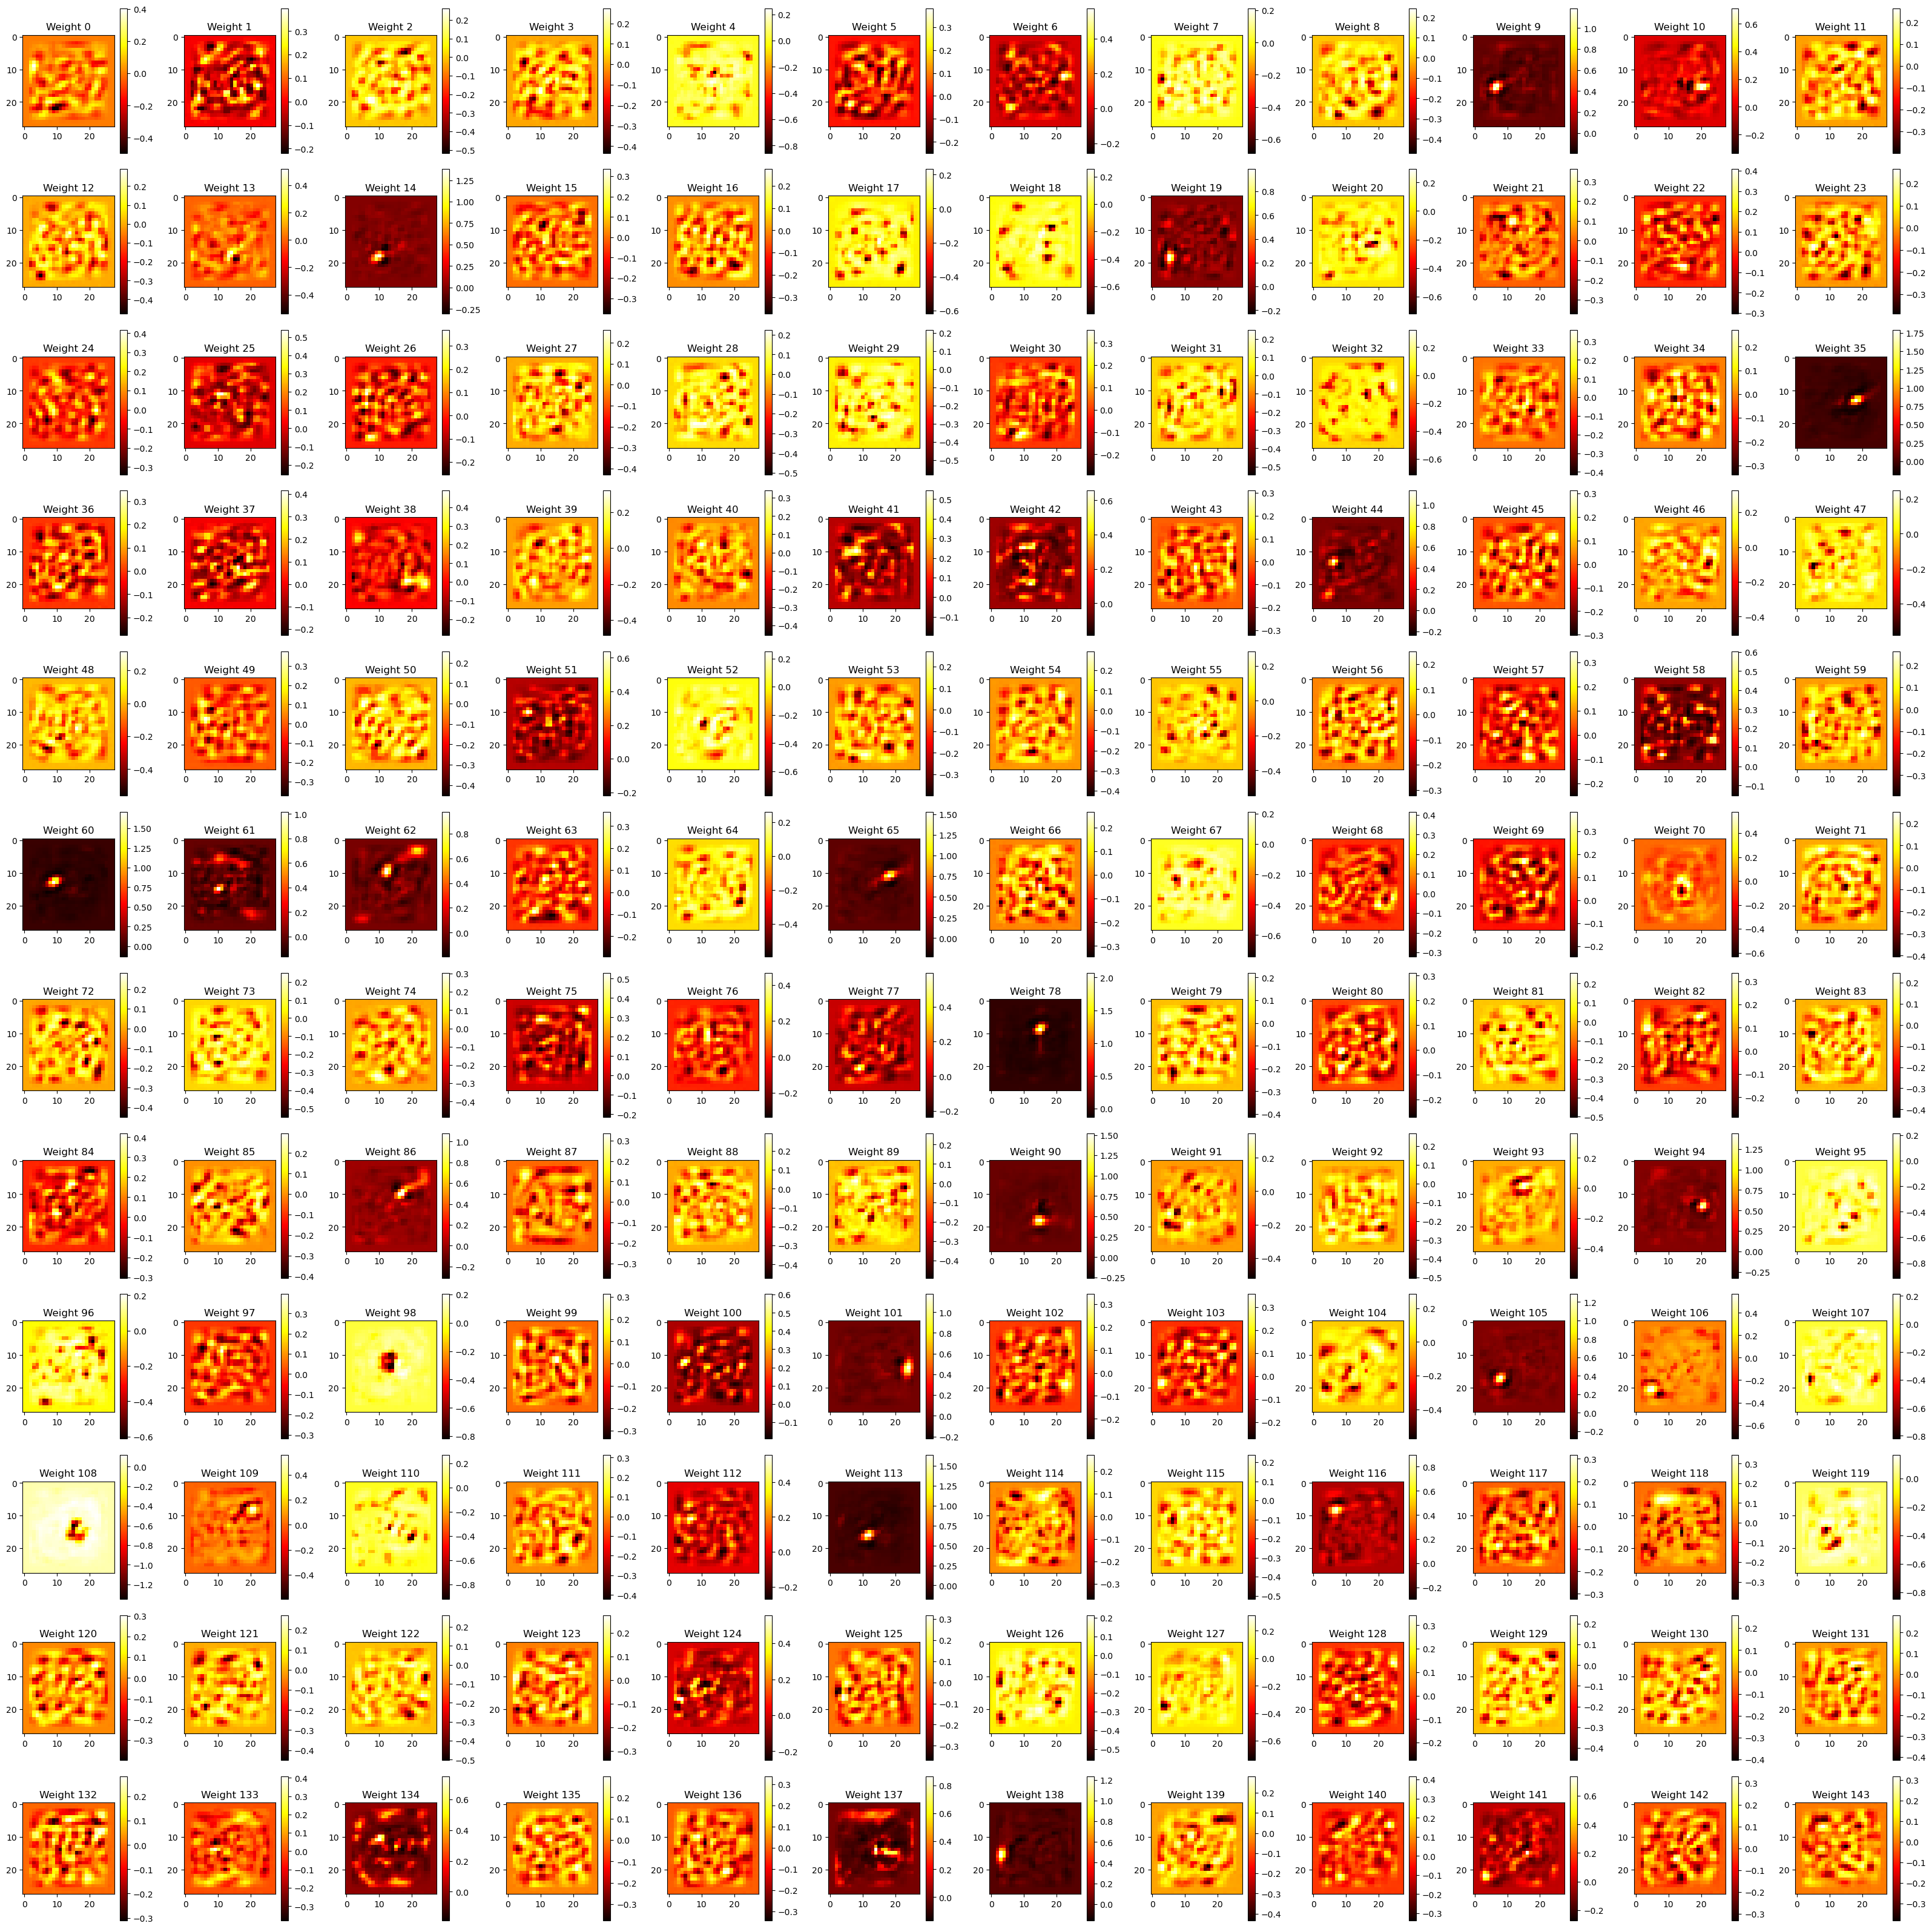

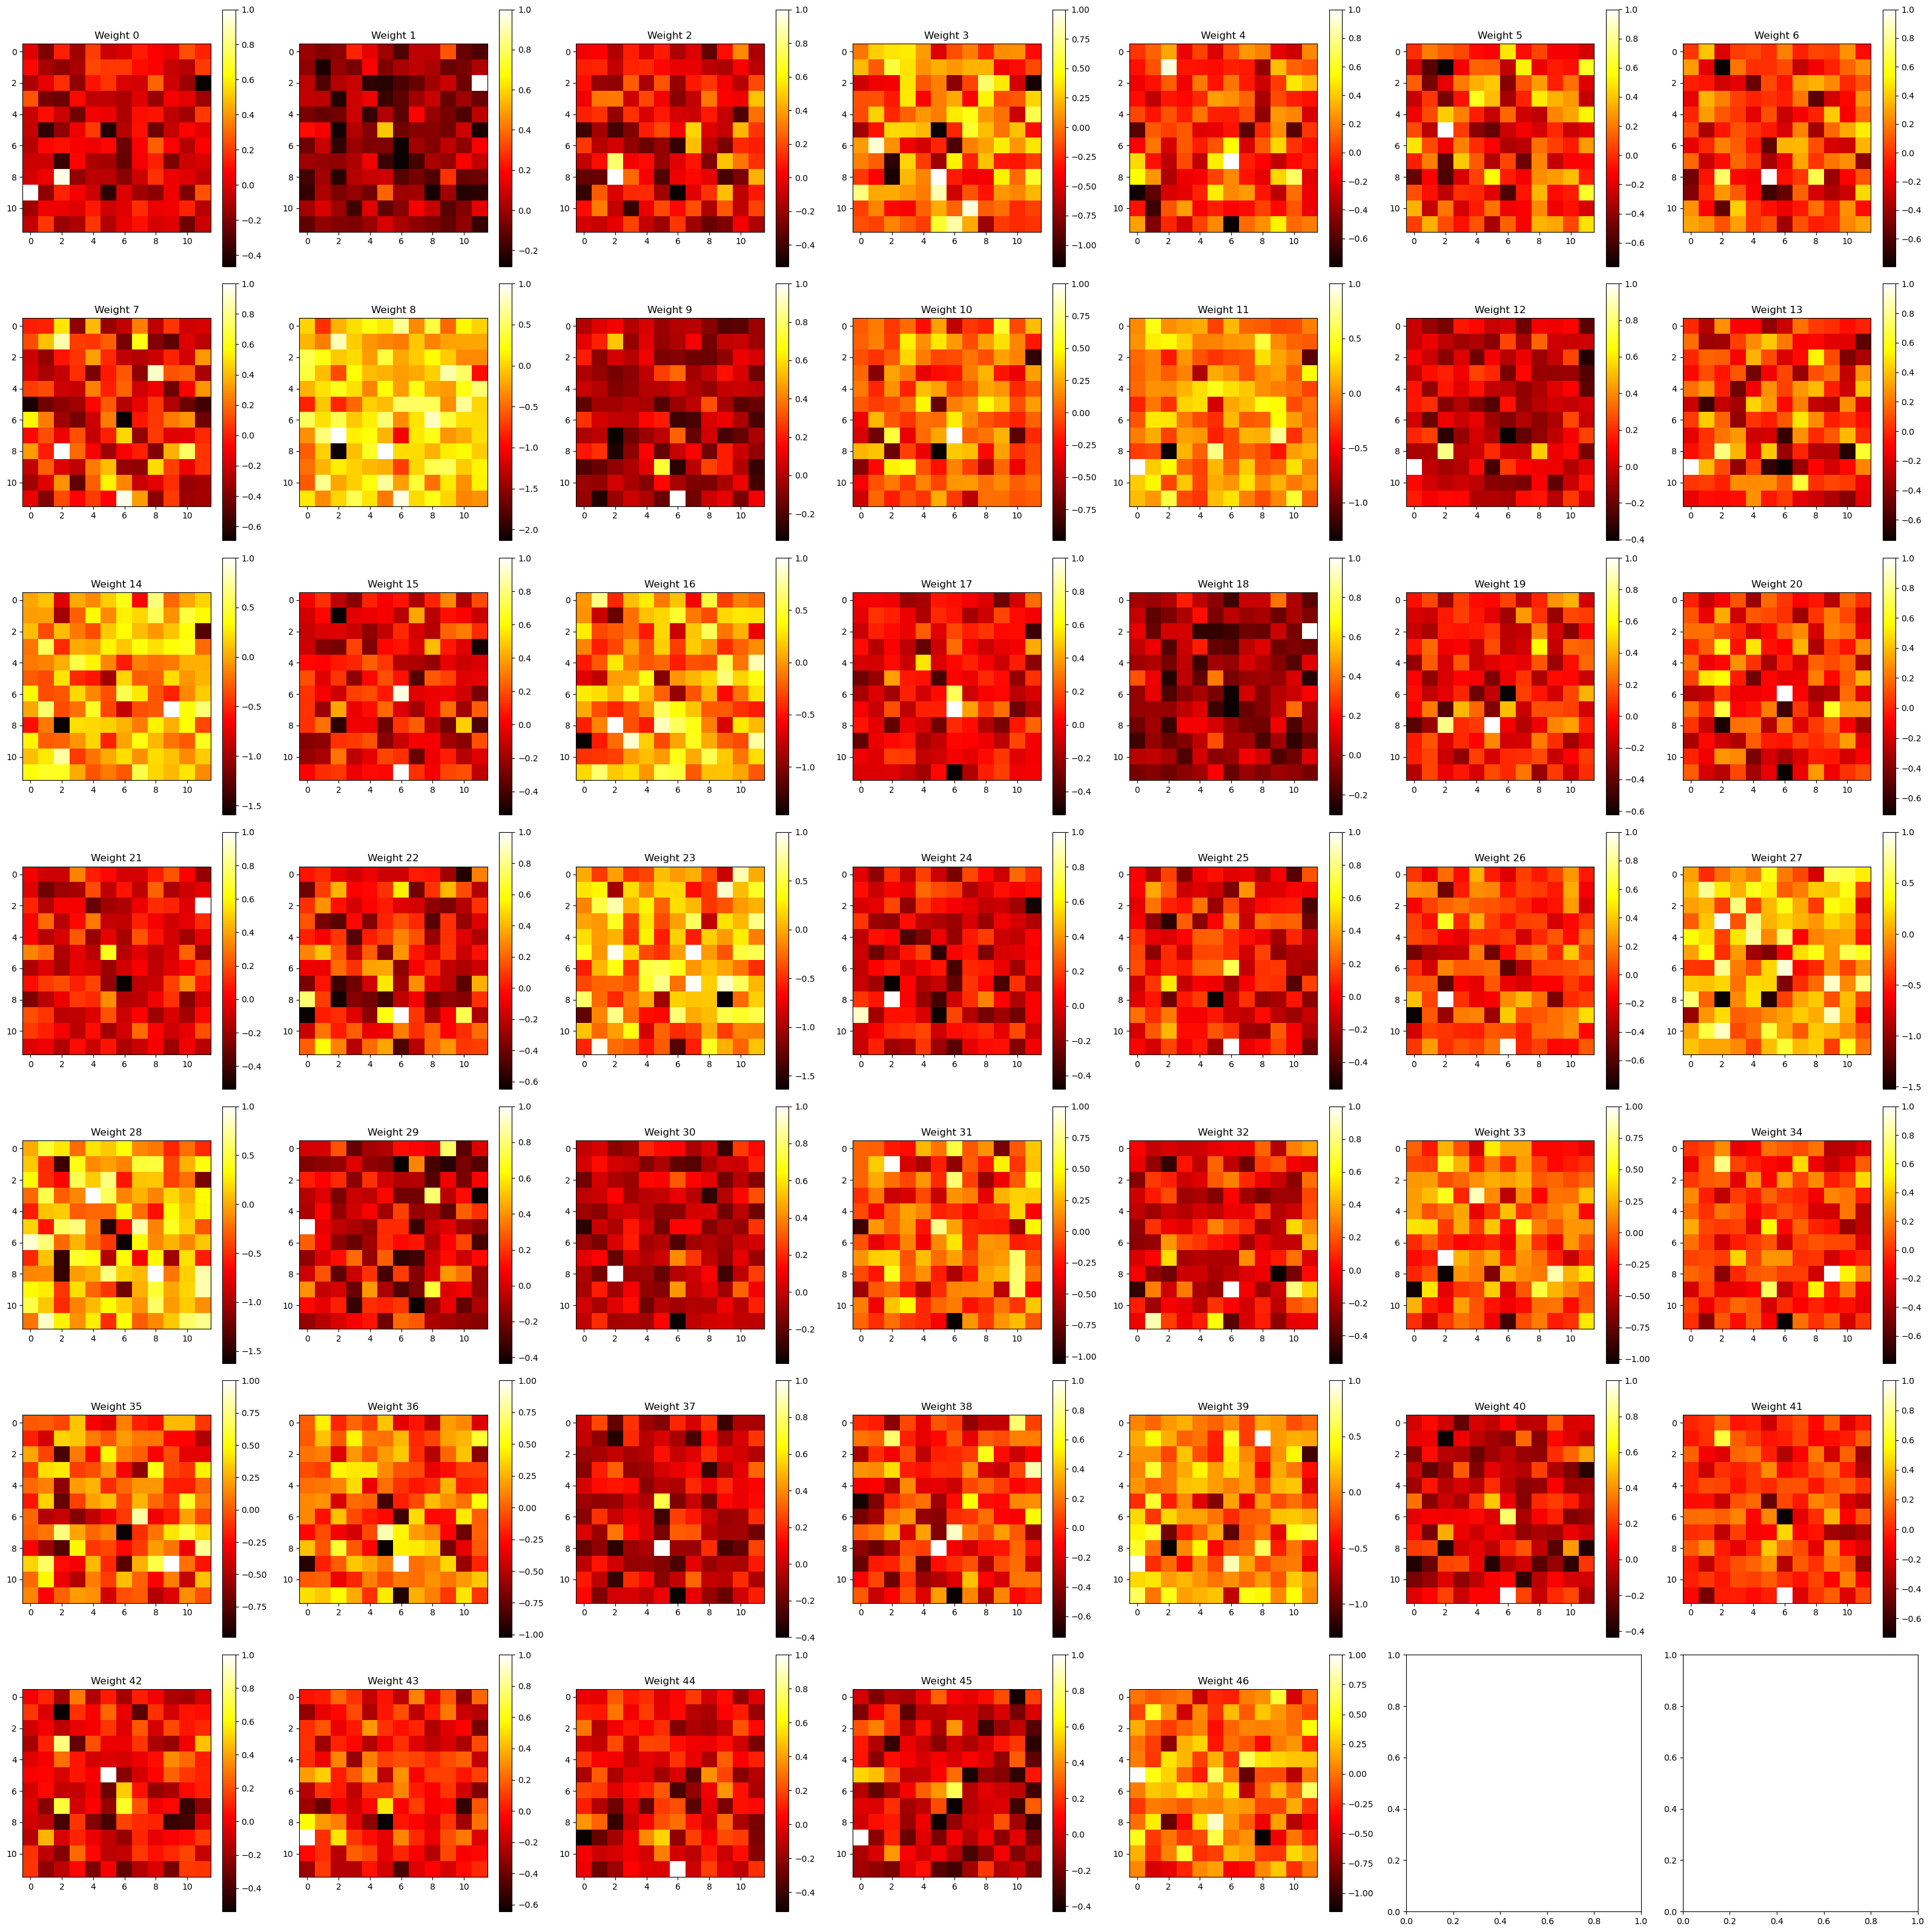

In [232]:
MLPBaseline_EMNIST.visualize_weights()

In [233]:
print(MLPBaseline_test_accuracy(MLPBaseline_EMNIST, emnist_train_loader))
print(MLPBaseline_test_accuracy(MLPBaseline_EMNIST, emnist_test_loader))

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.529281914893617, {45: (1693, 2400), 36: (1059, 2400), 43: (1621, 2400), 15: (700, 2400), 4: (1300, 2400), 42: (1382, 2400), 26: (1195, 2400), 32: (1859, 2400), 20: (1172, 2400), 1: (986, 2400), 46: (1091, 2400), 13: (1347, 2400), 24: (1212, 2400), 12: (1385, 2400), 5: (1001, 2400), 17: (1045, 2400), 3: (1711, 2400), 40: (1207, 2400), 14: (1299, 2400), 44: (480, 2400), 19: (676, 2400), 29: (1404, 2400), 25: (1588, 2400), 35: (1187, 2400), 28: (1401, 2400), 23: (1511, 2400), 22: (1908, 2400), 34: (993, 2400), 9: (1373, 2400), 30: (961, 2400), 38: (1693, 2400), 39: (1455, 2400), 37: (1594, 2400), 31: (1643, 2400), 16: (1544, 2400), 7: (1833, 2400), 2: (1060, 2400), 8: (1459, 2400), 10: (1644, 2400), 6: (1368, 2400), 27: (1400, 2400), 33: (1539, 2400), 11: (1250, 2400), 18: (684, 2400), 41: (437, 2400), 0: (930, 2400), 21: (423, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.5231382978723405, {16: (255, 400), 14: (218, 400), 23: (245, 400), 37: (257, 400), 4: (201, 400), 38: (304, 400), 15: (129, 400), 26: (197, 400), 3: (302, 400), 24: (214, 400), 11: (207, 400), 30: (156, 400), 44: (76, 400), 40: (189, 400), 5: (164, 400), 27: (209, 400), 42: (240, 400), 43: (269, 400), 2: (180, 400), 45: (273, 400), 29: (227, 400), 12: (235, 400), 25: (276, 400), 17: (179, 400), 10: (269, 400), 41: (71, 400), 33: (257, 400), 9: (215, 400), 39: (239, 400), 13: (219, 400), 34: (150, 400), 20: (188, 400), 6: (227, 400), 7: (300, 400), 8: (235, 400), 46: (174, 400), 18: (100, 400), 19: (112, 400), 35: (200, 400), 28: (223, 400), 0: (174, 400), 1: (153, 400), 32: (322, 400), 21: (81, 400), 22: (304, 400), 31: (254, 400), 36: (166, 400)})


In [222]:
MLPBaseline_EMNIST = MLPBaseline_Experiment(hsize=64, lamb=15, lr=0.005, learning=Learning.FullyOrthogonal, e=0.01, dataloader=emnist_train_loader, nclasses=47)

  0%|          | 0/112800 [00:00<?, ?it/s]

/Users/zhaoyizhe/miniconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

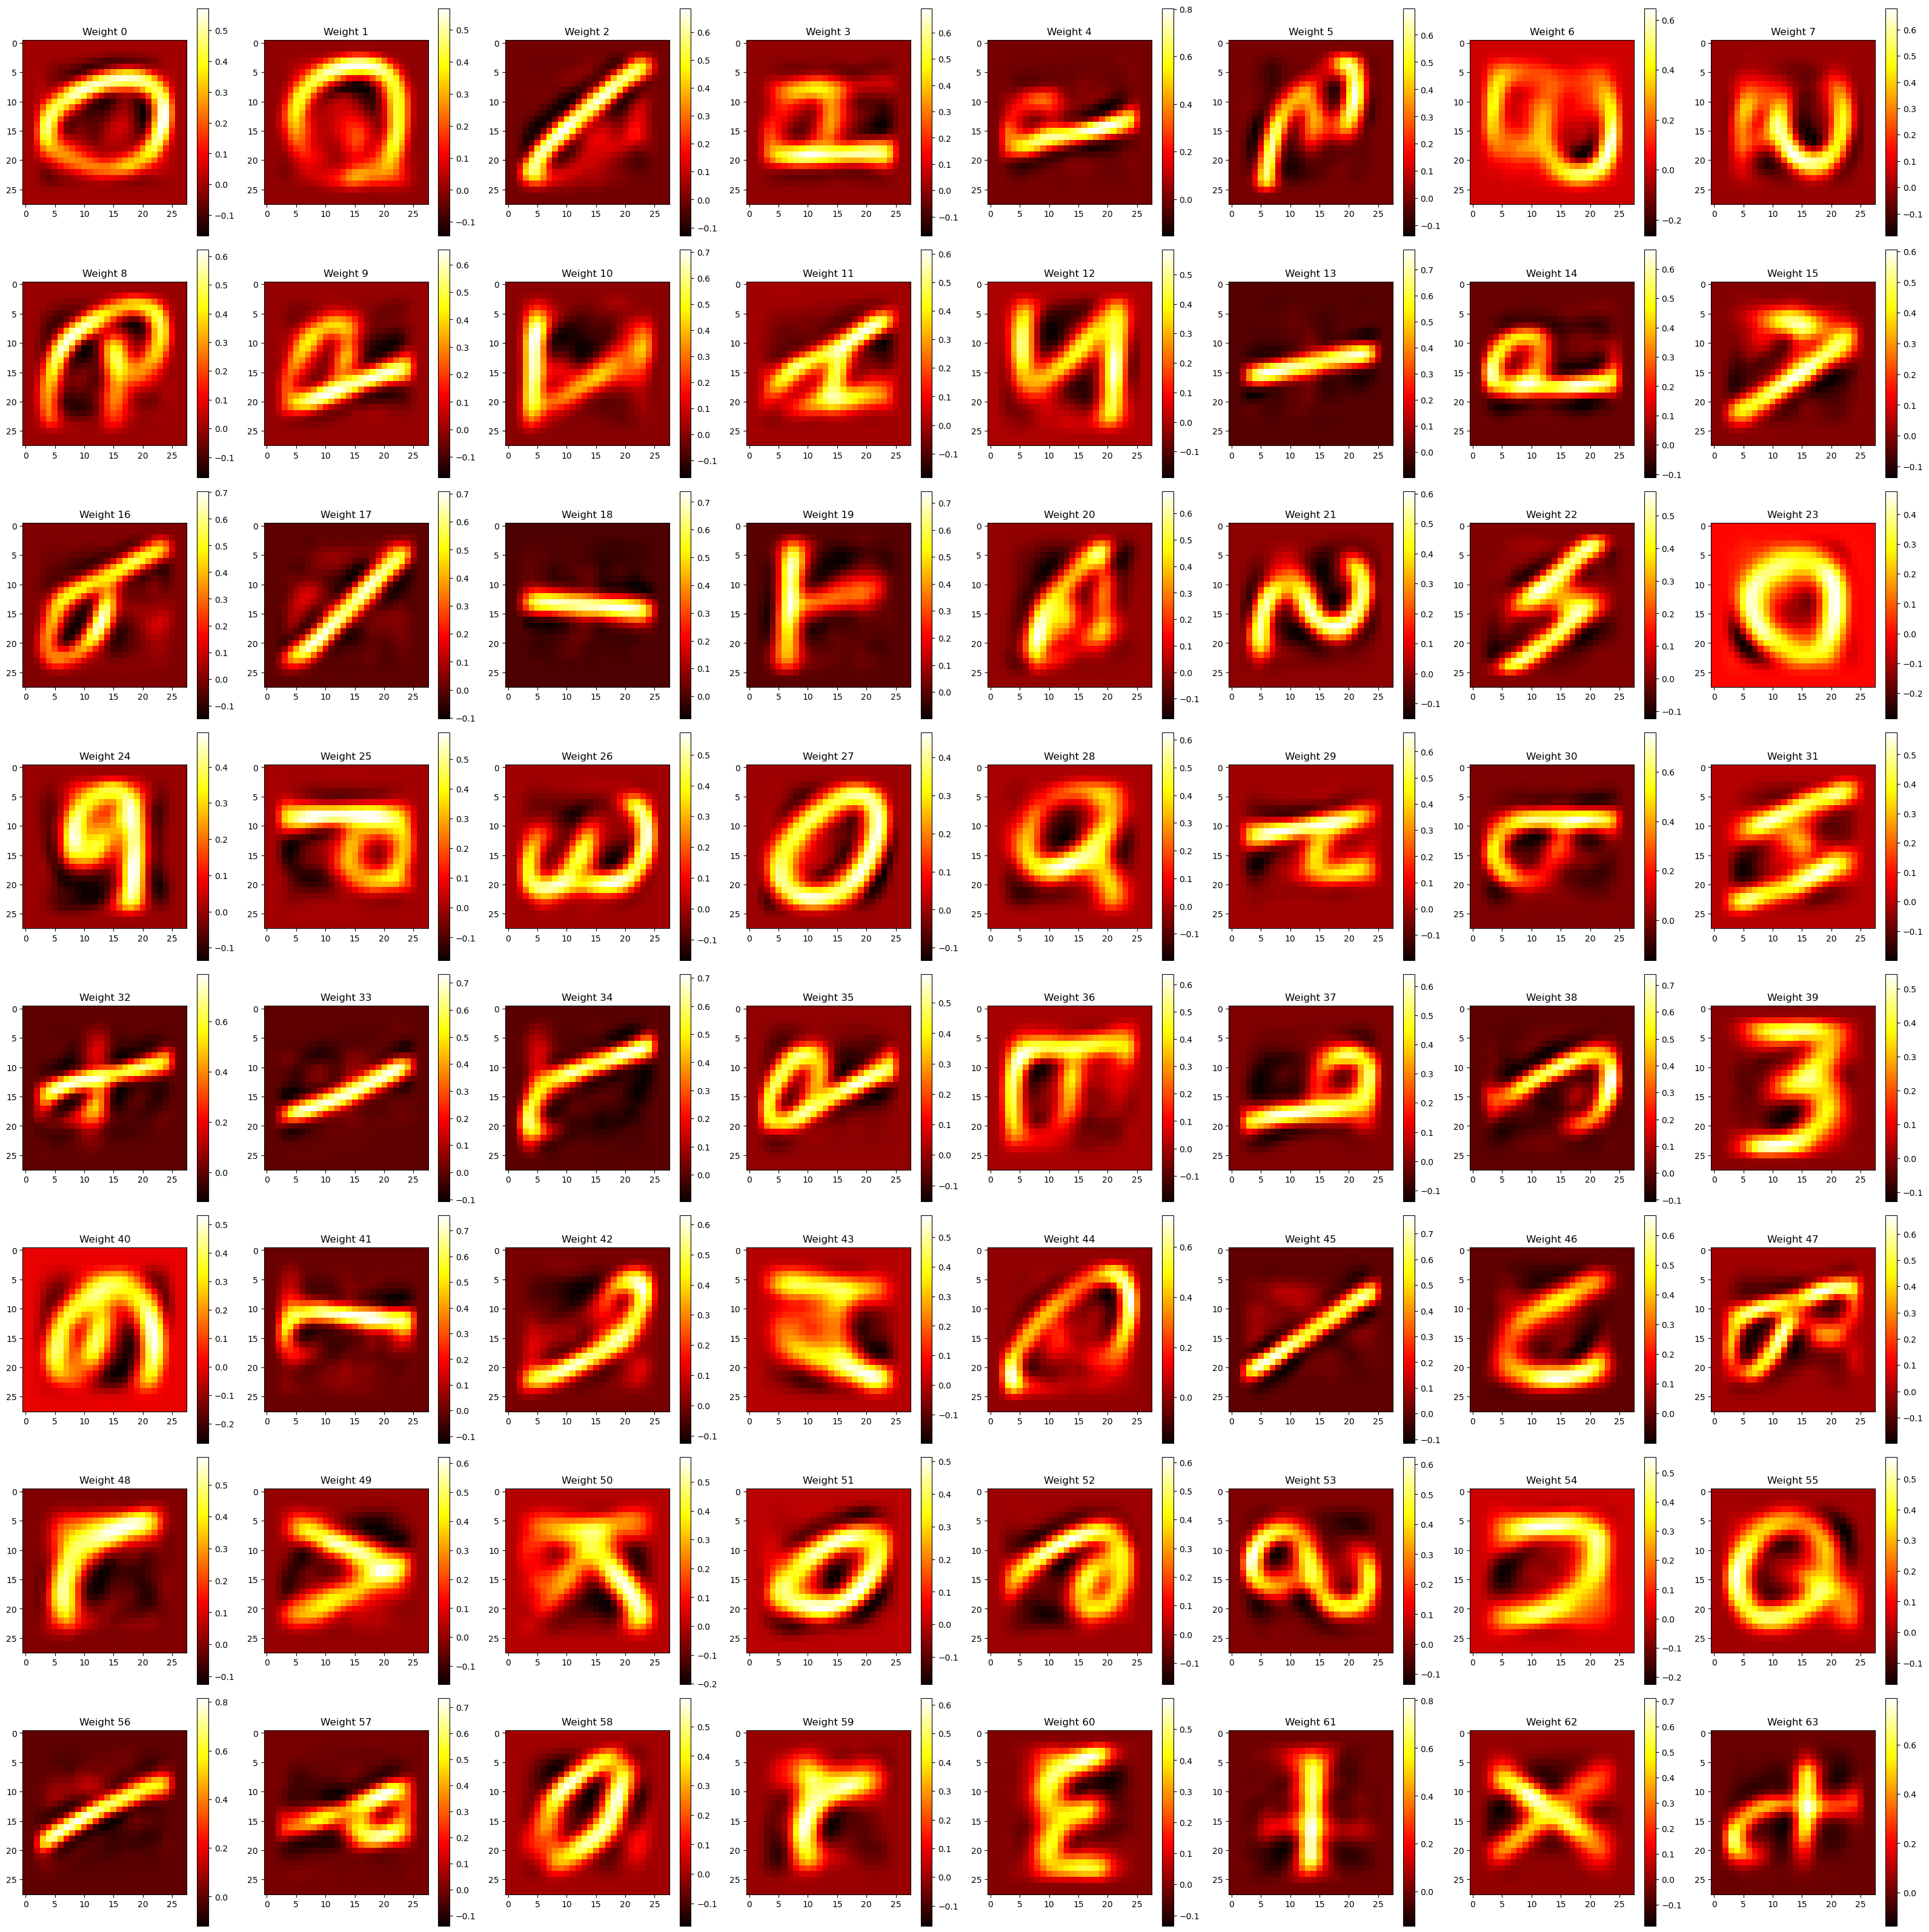

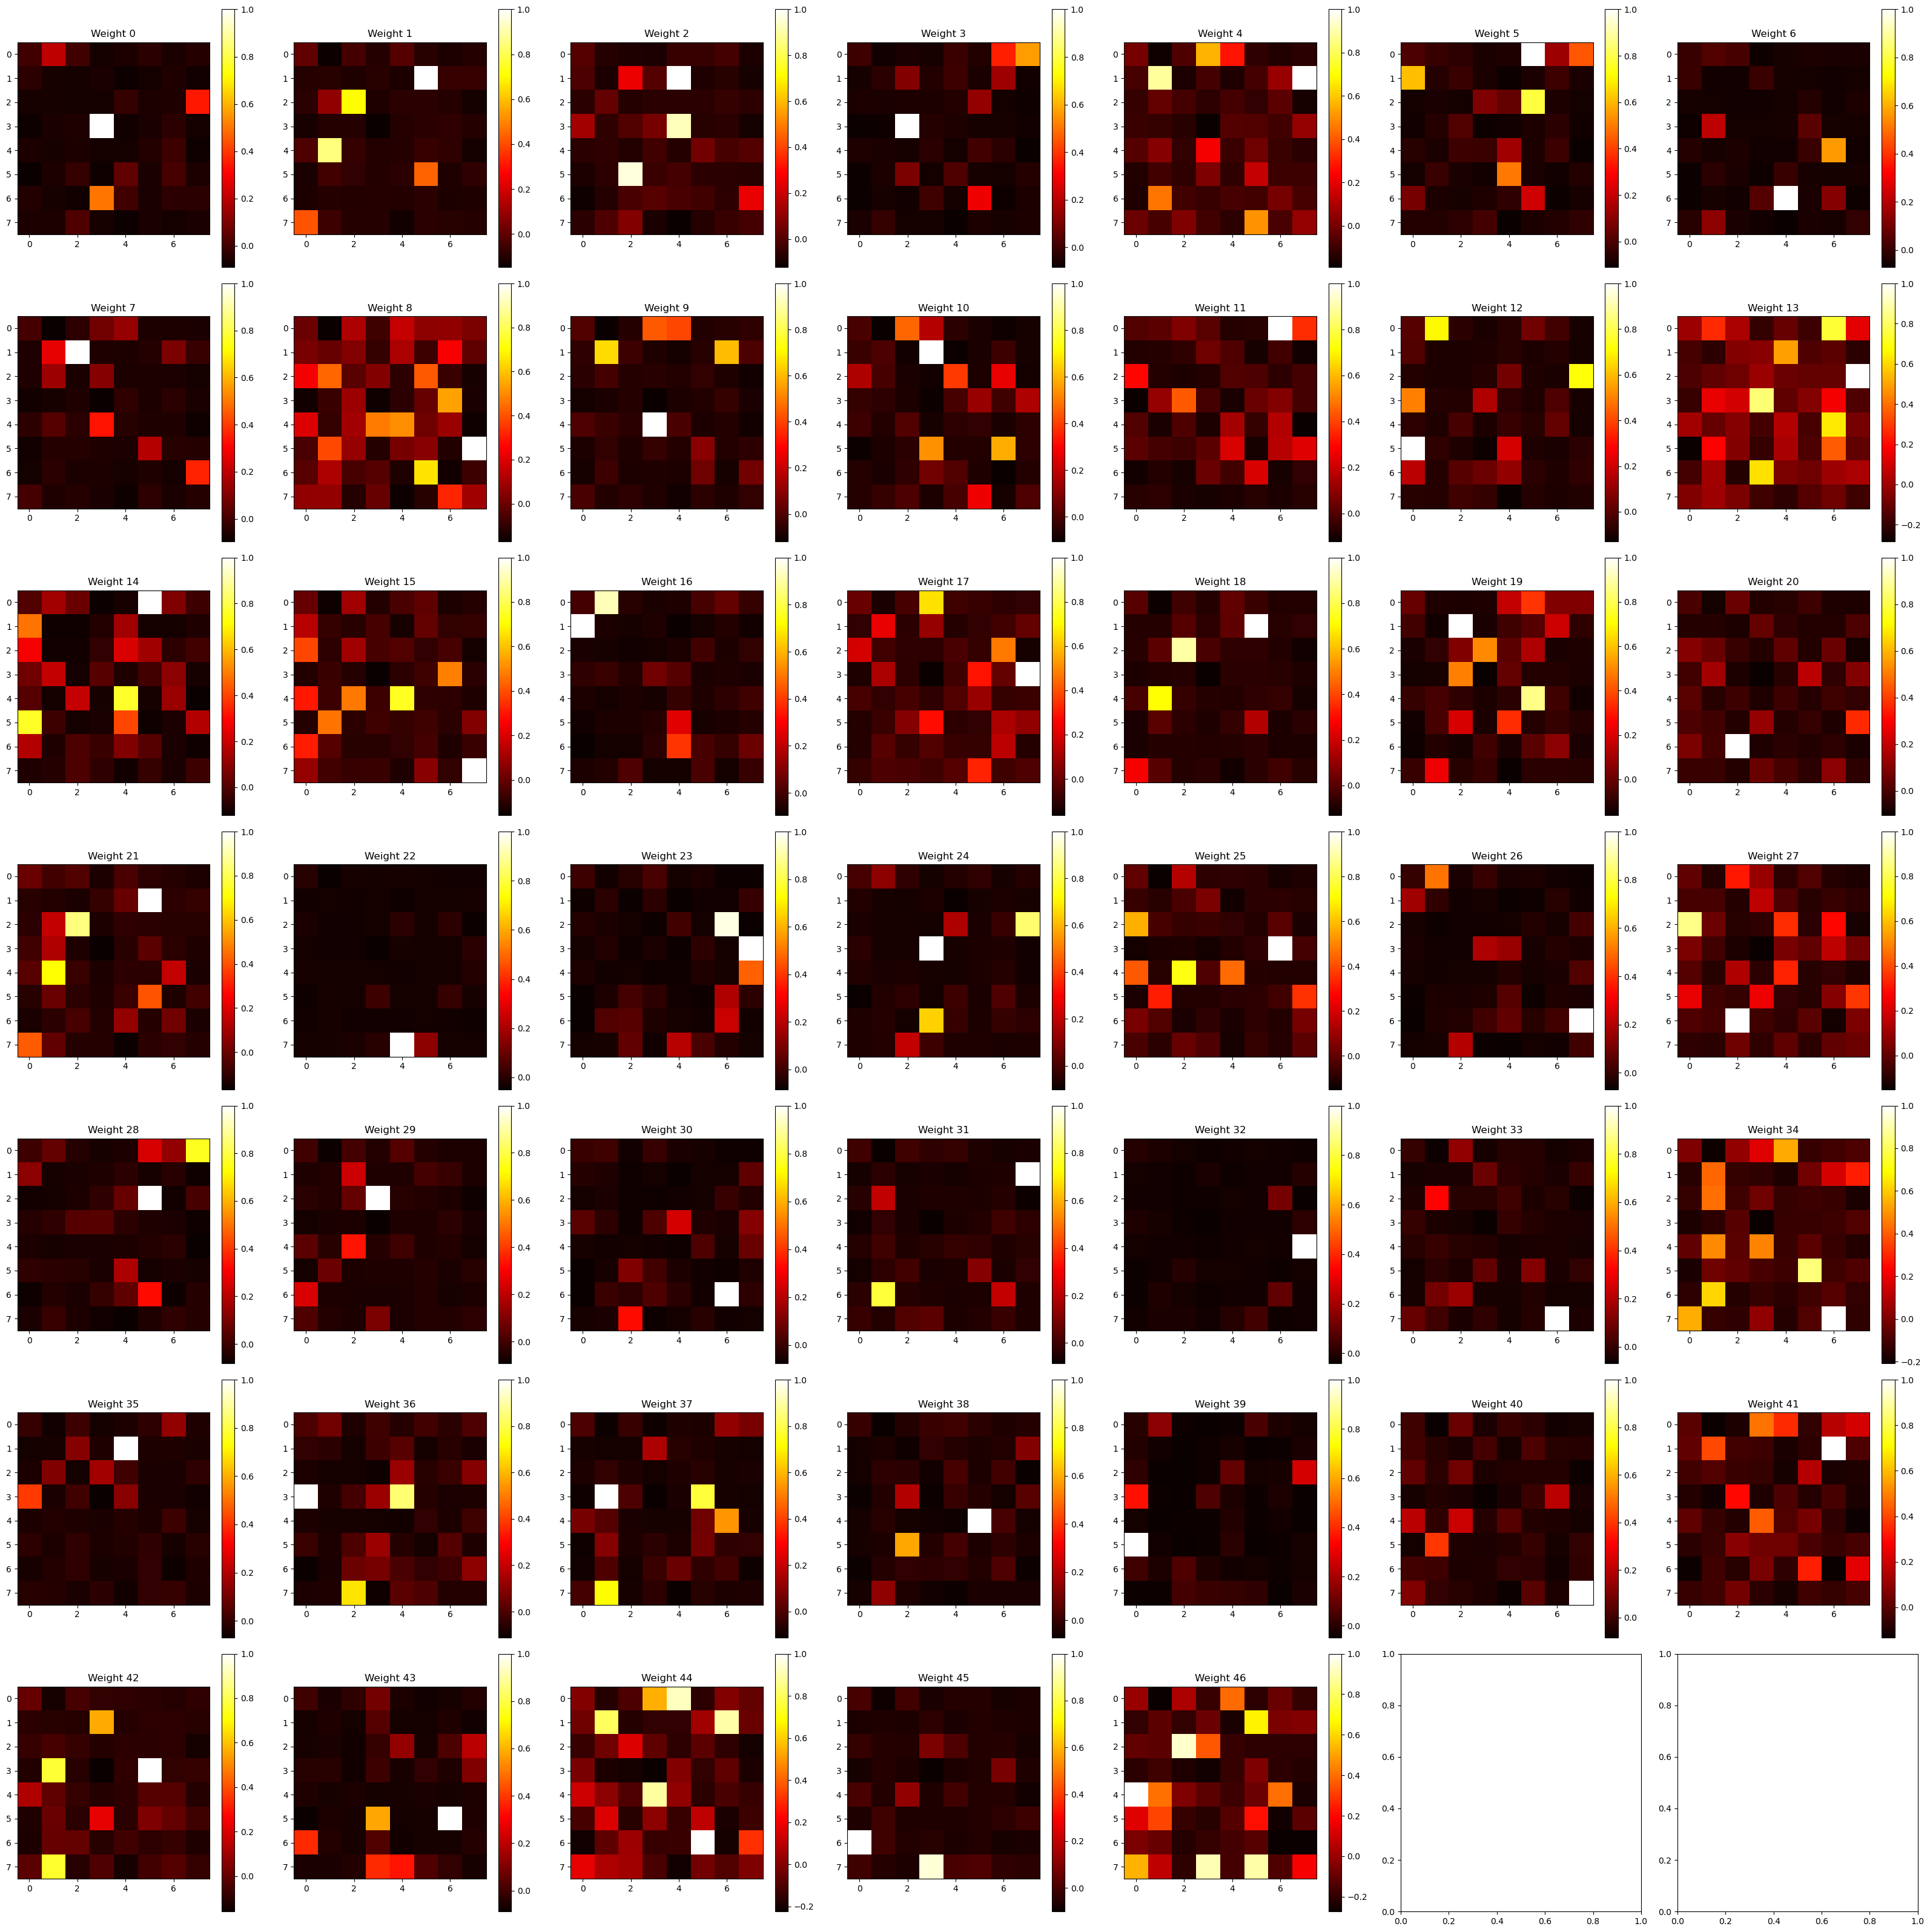

In [223]:
MLPBaseline_EMNIST.visualize_weights()

In [224]:
print(MLPBaseline_test_accuracy(MLPBaseline_EMNIST, emnist_train_loader))
print(MLPBaseline_test_accuracy(MLPBaseline_EMNIST, emnist_test_loader))

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.3749468085106383, {45: (1762, 2400), 36: (1363, 2400), 43: (1394, 2400), 15: (242, 2400), 4: (1073, 2400), 42: (1099, 2400), 26: (967, 2400), 32: (1685, 2400), 20: (634, 2400), 1: (1209, 2400), 46: (878, 2400), 13: (587, 2400), 24: (1115, 2400), 12: (637, 2400), 5: (503, 2400), 17: (1010, 2400), 3: (1156, 2400), 40: (630, 2400), 14: (1122, 2400), 44: (944, 2400), 19: (647, 2400), 29: (953, 2400), 25: (1014, 2400), 35: (189, 2400), 28: (1226, 2400), 23: (943, 2400), 22: (1862, 2400), 34: (834, 2400), 9: (506, 2400), 30: (969, 2400), 38: (906, 2400), 39: (509, 2400), 37: (724, 2400), 31: (679, 2400), 16: (1202, 2400), 7: (774, 2400), 2: (1435, 2400), 8: (721, 2400), 10: (947, 2400), 6: (1291, 2400), 27: (723, 2400), 33: (320, 2400), 11: (986, 2400), 18: (735, 2400), 41: (382, 2400), 0: (807, 2400), 21: (0, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.3720212765957447, {38: (158, 400), 15: (35, 400), 44: (148, 400), 0: (149, 400), 32: (293, 400), 12: (113, 400), 42: (188, 400), 3: (213, 400), 19: (104, 400), 35: (20, 400), 16: (208, 400), 22: (304, 400), 31: (107, 400), 43: (223, 400), 46: (151, 400), 24: (197, 400), 13: (117, 400), 33: (45, 400), 21: (1, 400), 29: (137, 400), 30: (156, 400), 23: (161, 400), 7: (140, 400), 18: (118, 400), 14: (195, 400), 45: (282, 400), 41: (59, 400), 40: (88, 400), 20: (100, 400), 26: (171, 400), 4: (193, 400), 11: (164, 400), 9: (79, 400), 39: (84, 400), 10: (163, 400), 1: (184, 400), 37: (128, 400), 34: (135, 400), 6: (214, 400), 5: (80, 400), 36: (214, 400), 27: (109, 400), 28: (197, 400), 25: (157, 400), 17: (179, 400), 2: (229, 400), 8: (104, 400)})


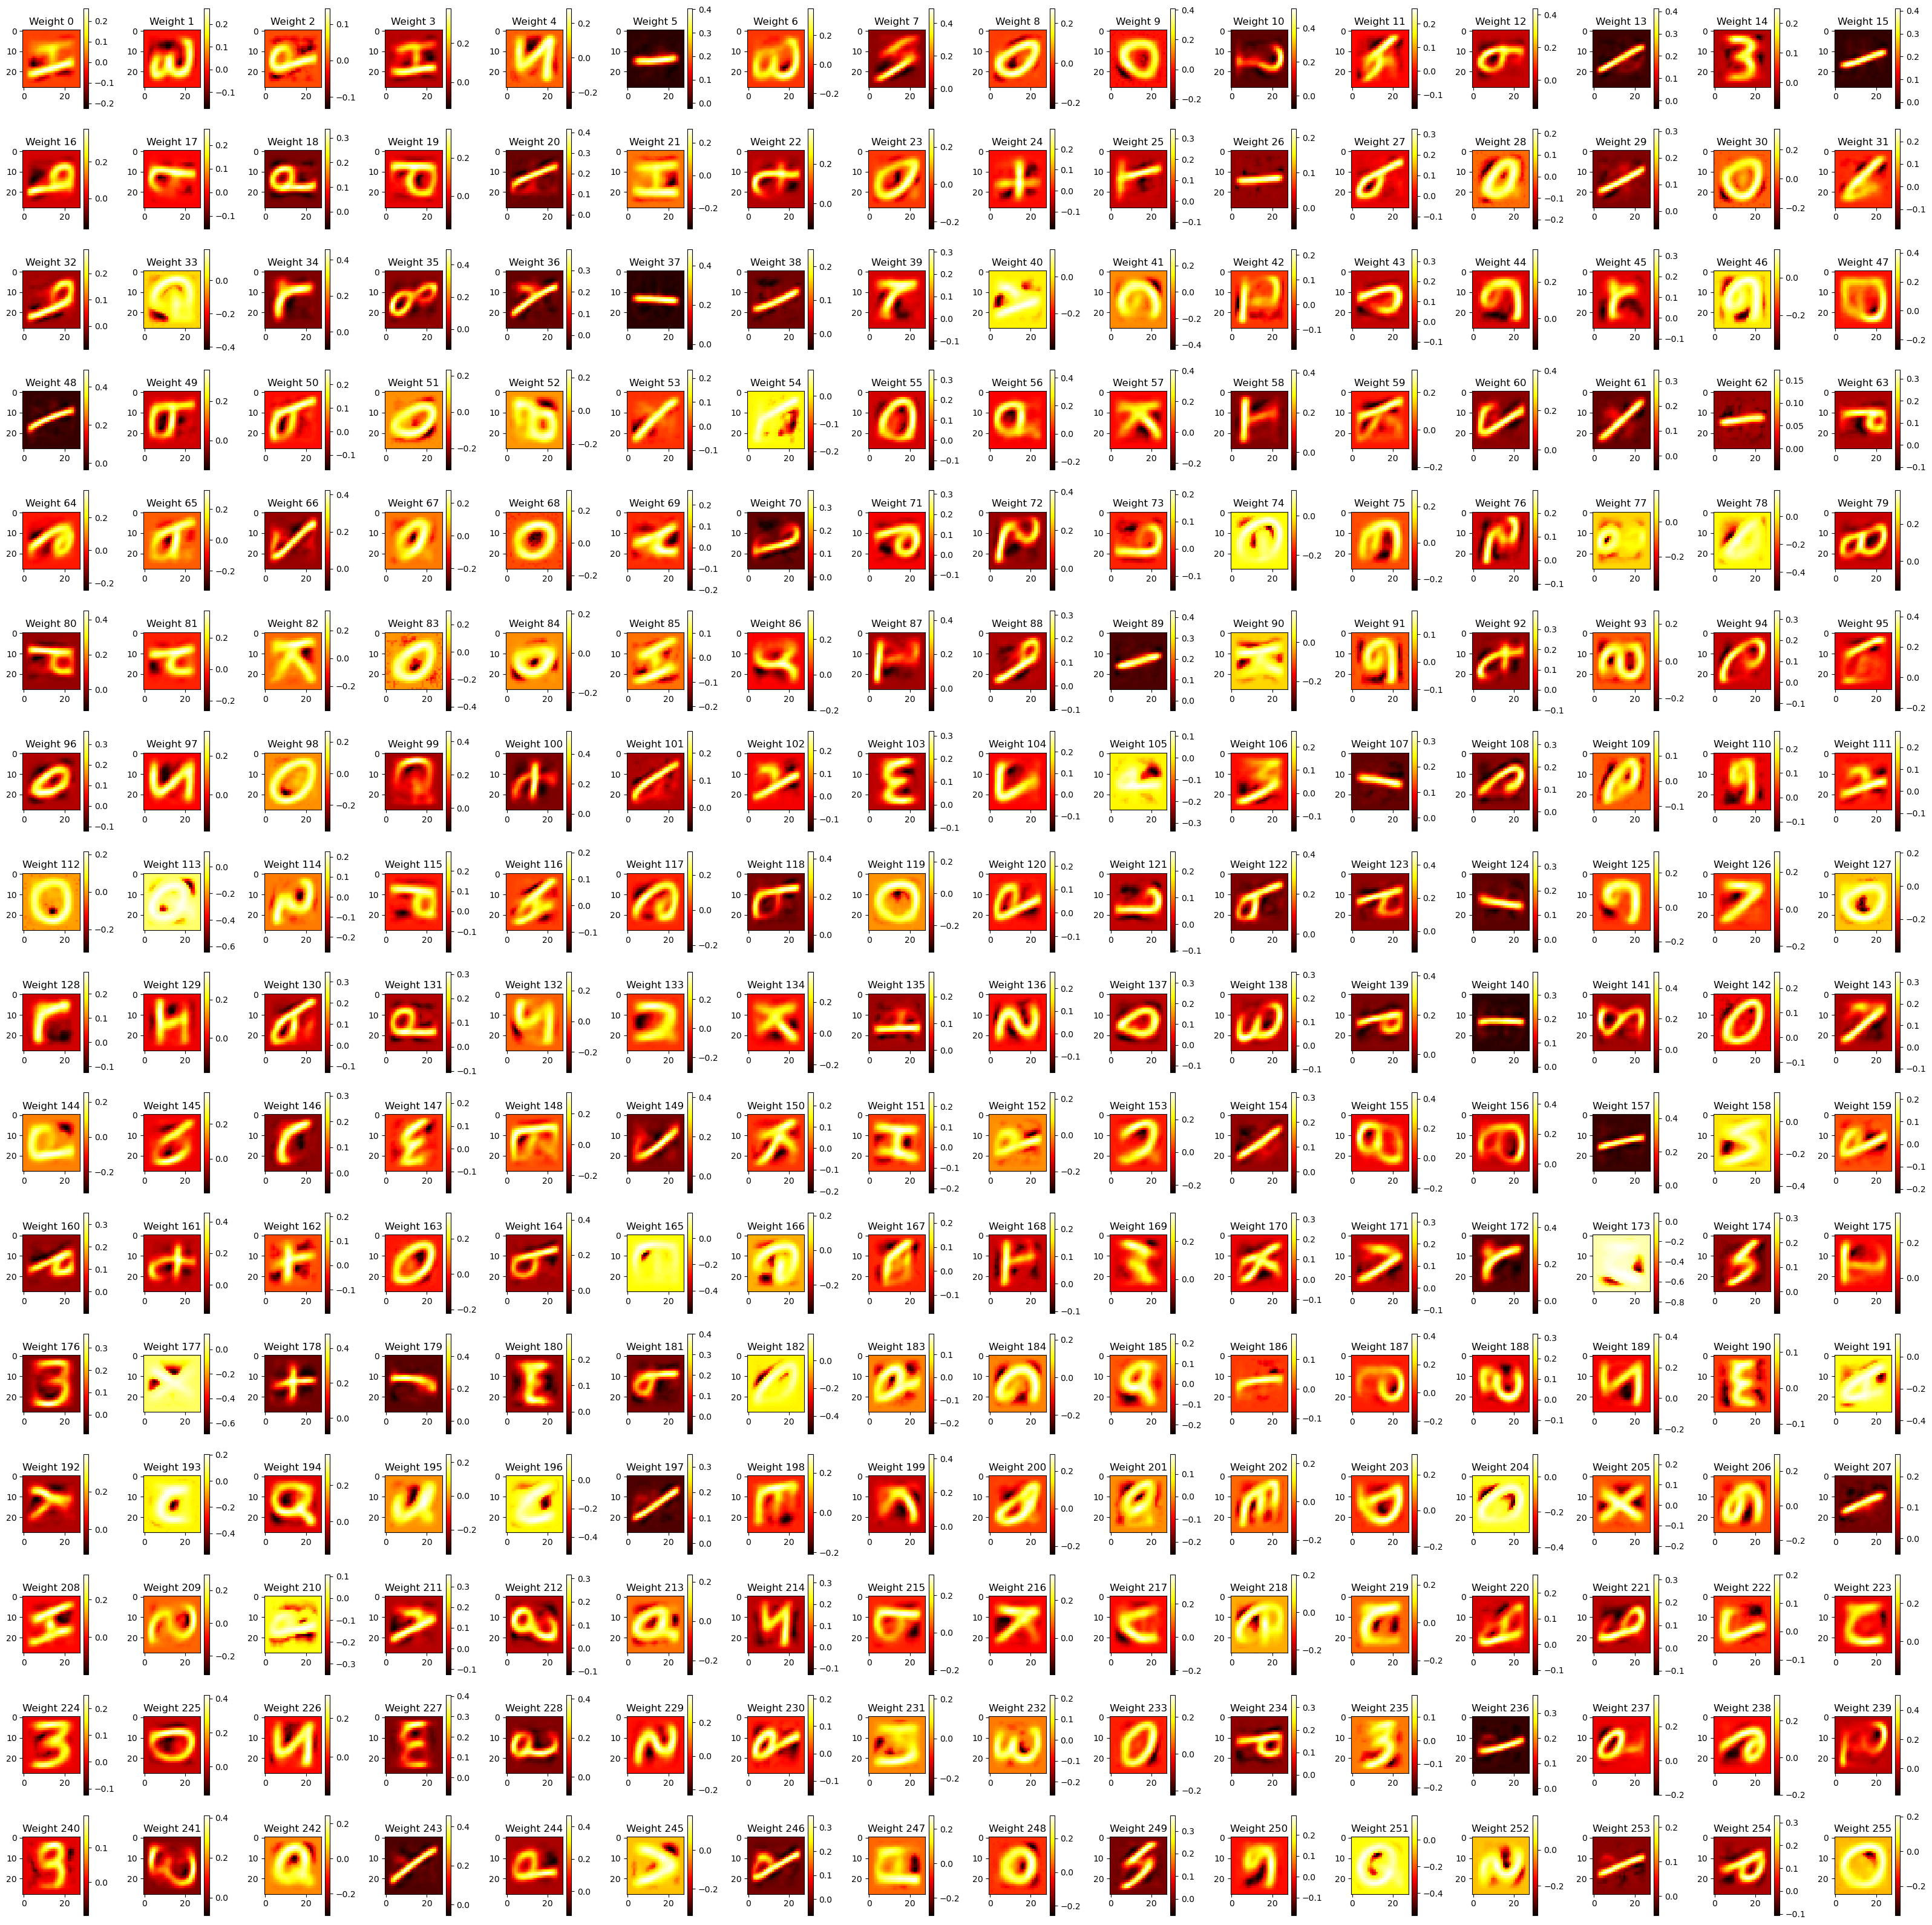

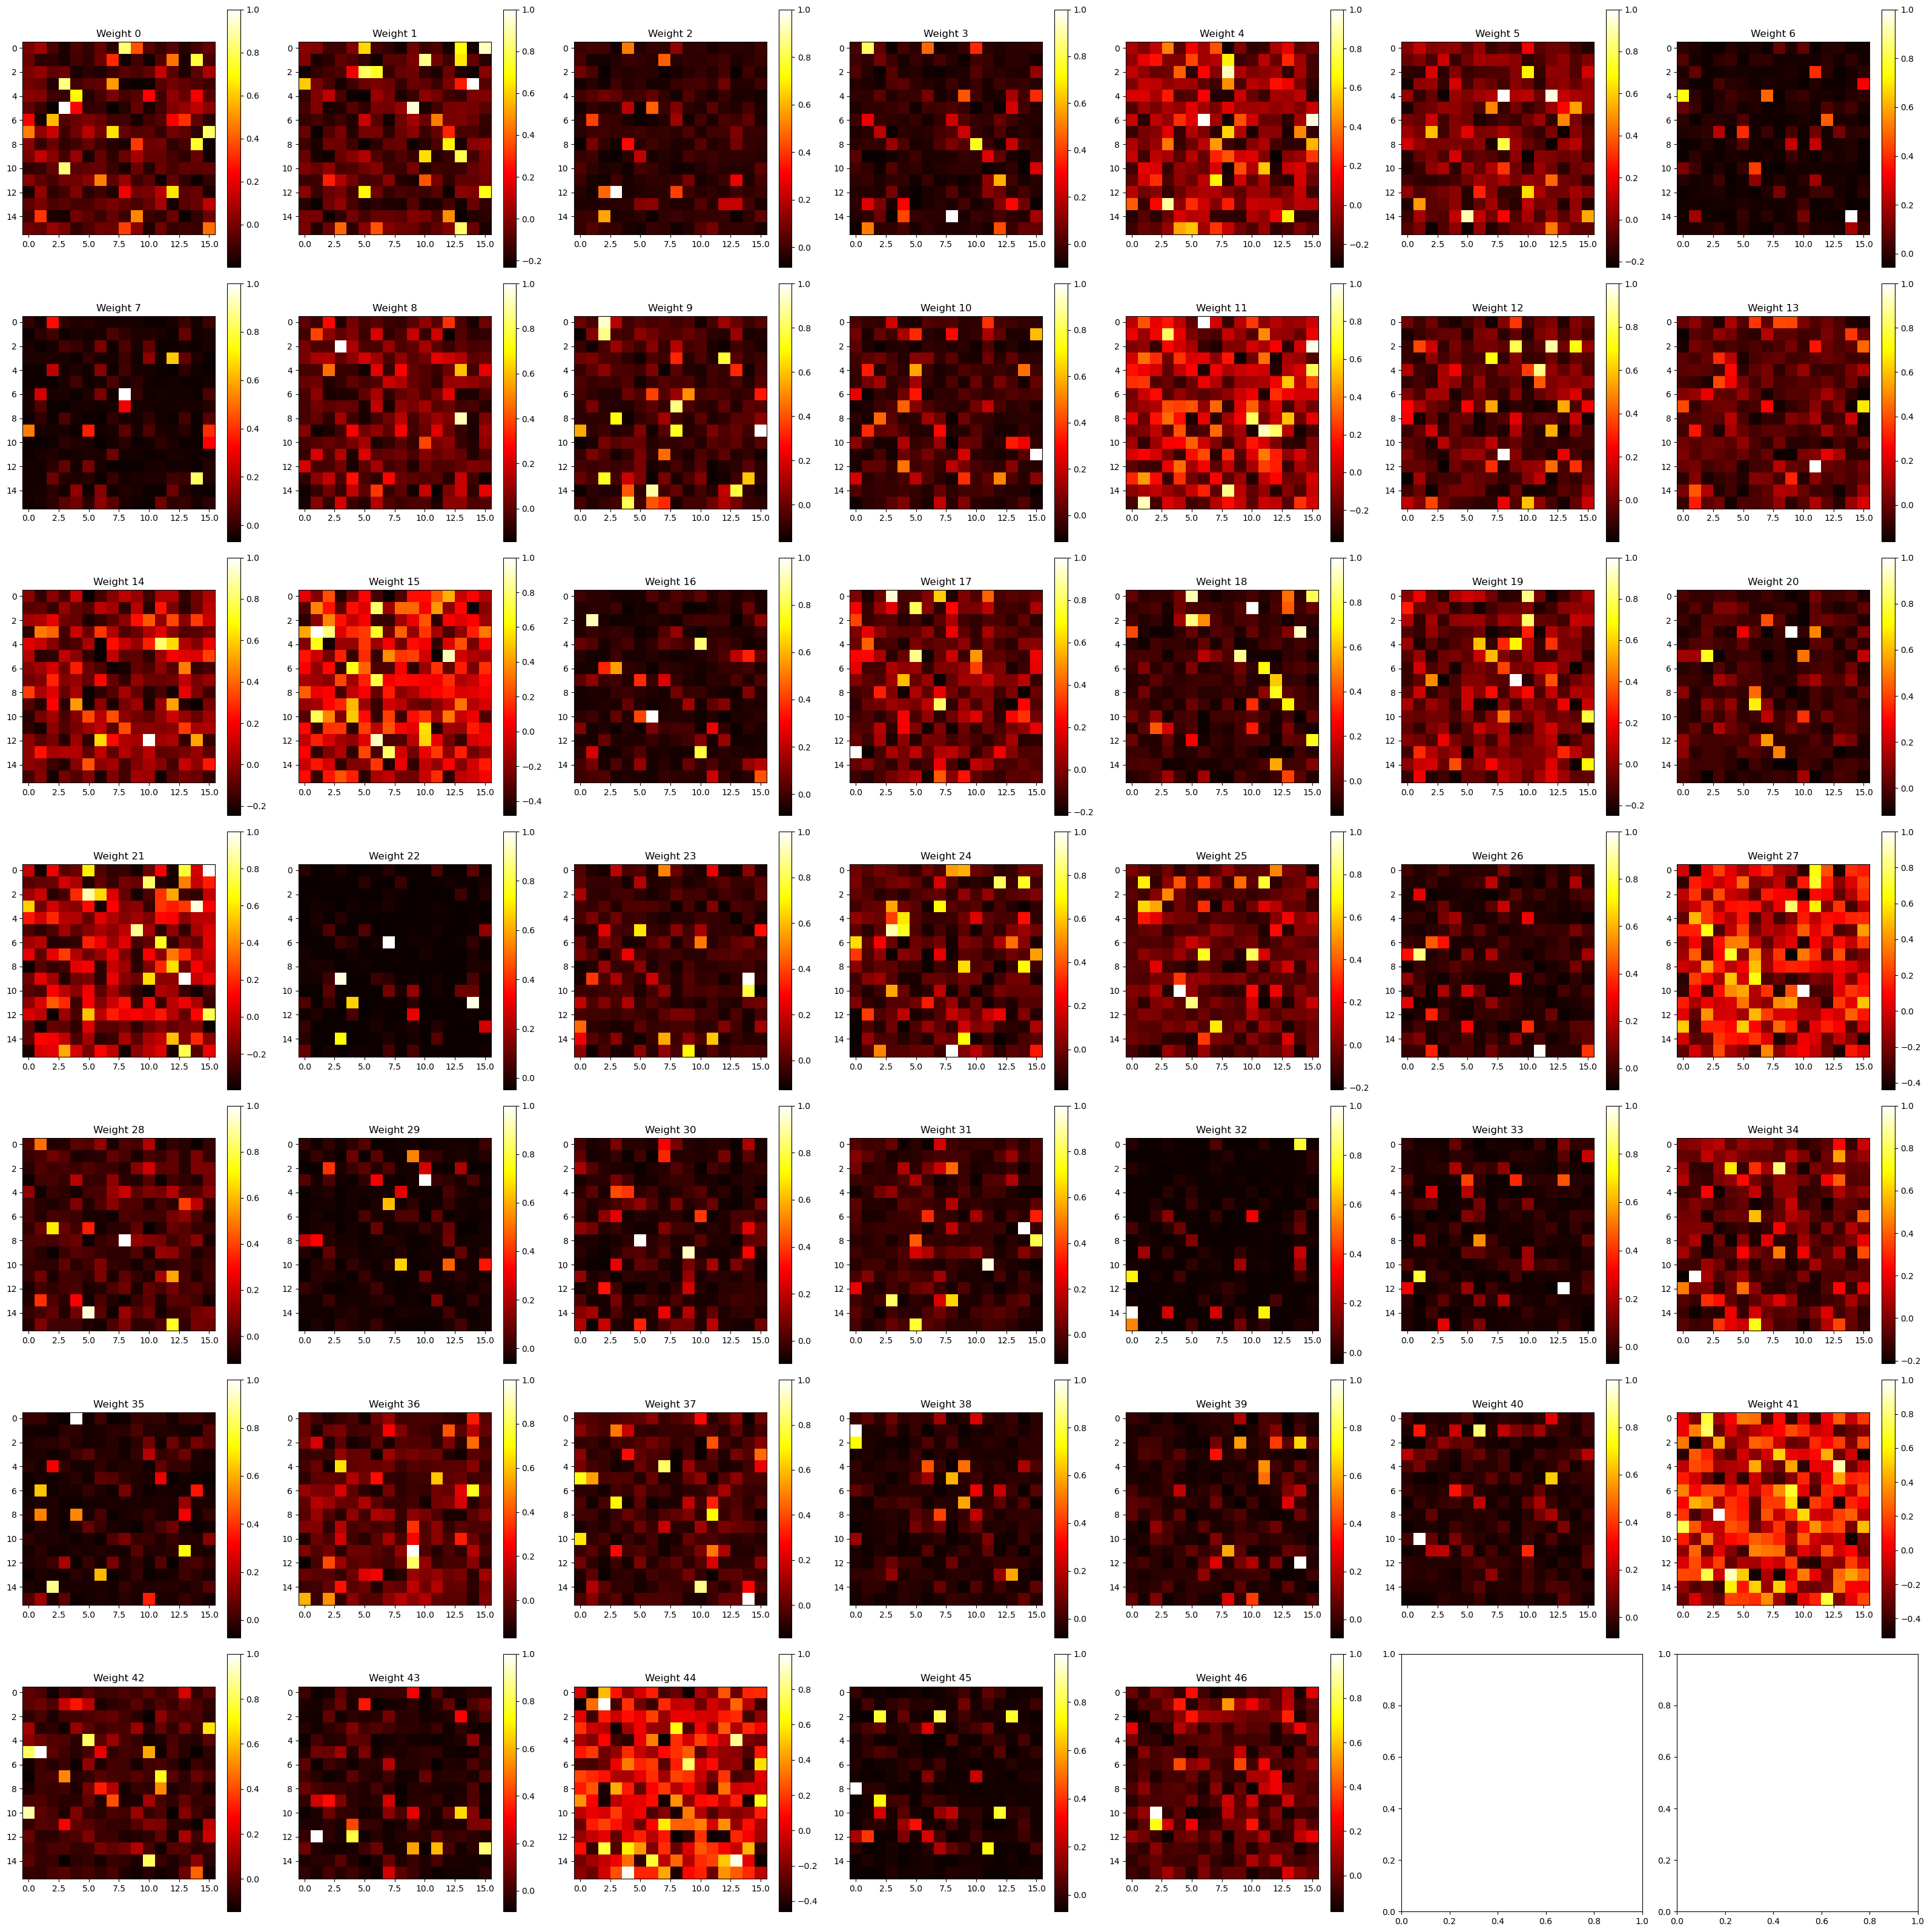

In [44]:
MLPBaseline_EMNIST.visualize_weights()

### Gaussian Noise

#### Memory patterns

In [333]:
MLPBaseline_EMNIST_MP = MLPBaseline_Experiment(256, 15, 0.005, Learning.FullyOrthogonal, 0.01, emnist_train_loader, 47)

  0%|          | 0/112800 [00:00<?, ?it/s]

/Users/zhaoyizhe/miniconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

(0.5359574468085107, {34: (131, 400), 29: (272, 400), 41: (68, 400), 16: (259, 400), 18: (168, 400), 23: (210, 400), 37: (218, 400), 19: (157, 400), 10: (237, 400), 30: (245, 400), 31: (238, 400), 6: (290, 400), 9: (139, 400), 7: (325, 400), 39: (212, 400), 13: (196, 400), 38: (294, 400), 42: (234, 400), 26: (235, 400), 35: (322, 400), 14: (276, 400), 0: (144, 400), 2: (216, 400), 22: (286, 400), 5: (62, 400), 4: (227, 400), 24: (244, 400), 46: (138, 400), 27: (152, 400), 33: (256, 400), 15: (235, 400), 8: (133, 400), 11: (212, 400), 17: (243, 400), 45: (191, 400), 44: (214, 400), 40: (27, 400), 1: (280, 400), 36: (211, 400), 43: (269, 400), 28: (278, 400), 12: (278, 400), 20: (226, 400), 21: (70, 400), 32: (327, 400), 3: (240, 400), 25: (191, 400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.5361170212765958, {20: (222, 400), 13: (201, 400), 38: (294, 400), 21: (67, 400), 9: (140, 400), 19: (159, 400), 3: (235, 400), 17: (240, 400), 34: (131, 400), 22: (284, 400), 33: (253, 400), 23: (212, 400), 35: (321, 400), 8: (133, 400), 15: (237, 400), 10: (237, 400), 41: (69, 400), 32: (327, 400), 30: (246, 400), 37: (223, 400), 7: (324, 400), 2: (220, 400), 28: (278, 400), 16: (257, 400), 25: (190, 400), 6: (291, 400), 44: (214, 400), 0: (132, 400), 31: (238, 400), 43: (269, 400), 5: (62, 400), 45: (195, 400), 29: (273, 400), 27: (155, 400), 14: (276, 400), 24: (241, 400), 42: (234, 400), 18: (171, 400), 11: (213, 400), 40: (28, 400), 26: (240, 400), 4: (229, 400), 1: (279, 400), 36: (209, 400), 46: (137, 400), 12: (281, 400), 39: (212, 400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.5309574468085106, {27: (163, 400), 0: (110, 400), 42: (240, 400), 24: (249, 400), 37: (228, 400), 13: (215, 400), 23: (211, 400), 20: (230, 400), 6: (287, 400), 29: (267, 400), 16: (255, 400), 43: (268, 400), 4: (227, 400), 45: (185, 400), 38: (296, 400), 8: (117, 400), 10: (234, 400), 9: (139, 400), 15: (231, 400), 32: (336, 400), 39: (205, 400), 2: (230, 400), 11: (216, 400), 31: (233, 400), 12: (286, 400), 35: (324, 400), 40: (32, 400), 22: (265, 400), 21: (47, 400), 34: (132, 400), 36: (208, 400), 33: (255, 400), 14: (264, 400), 17: (232, 400), 44: (198, 400), 41: (70, 400), 46: (139, 400), 28: (269, 400), 5: (58, 400), 30: (254, 400), 25: (174, 400), 1: (264, 400), 26: (256, 400), 7: (321, 400), 18: (183, 400), 19: (169, 400), 3: (210, 400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.5184042553191489, {8: (109, 400), 0: (90, 400), 45: (172, 400), 43: (256, 400), 28: (258, 400), 11: (215, 400), 3: (186, 400), 31: (226, 400), 23: (217, 400), 44: (188, 400), 38: (294, 400), 13: (223, 400), 32: (340, 400), 17: (219, 400), 33: (256, 400), 1: (241, 400), 16: (252, 400), 42: (242, 400), 40: (36, 400), 20: (229, 400), 21: (40, 400), 34: (123, 400), 29: (259, 400), 12: (275, 400), 37: (218, 400), 35: (318, 400), 4: (224, 400), 25: (165, 400), 36: (202, 400), 15: (221, 400), 10: (226, 400), 22: (244, 400), 46: (129, 400), 19: (173, 400), 26: (272, 400), 14: (250, 400), 30: (258, 400), 24: (249, 400), 7: (320, 400), 27: (166, 400), 9: (136, 400), 5: (52, 400), 41: (66, 400), 39: (191, 400), 6: (286, 400), 2: (239, 400), 18: (195, 400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.438563829787234, {30: (259, 400), 12: (242, 400), 5: (14, 400), 27: (157, 400), 0: (76, 400), 28: (182, 400), 18: (201, 400), 2: (241, 400), 42: (229, 400), 41: (63, 400), 31: (198, 400), 39: (123, 400), 10: (186, 400), 9: (113, 400), 37: (203, 400), 46: (82, 400), 4: (210, 400), 43: (205, 400), 8: (39, 400), 1: (131, 400), 35: (292, 400), 29: (211, 400), 32: (343, 400), 25: (110, 400), 24: (238, 400), 14: (201, 400), 45: (88, 400), 38: (284, 400), 34: (106, 400), 15: (138, 400), 3: (68, 400), 26: (314, 400), 7: (283, 400), 23: (206, 400), 6: (277, 400), 40: (38, 400), 36: (181, 400), 44: (133, 400), 21: (18, 400), 33: (247, 400), 20: (213, 400), 22: (124, 400), 19: (159, 400), 17: (189, 400), 16: (218, 400), 13: (216, 400), 11: (196, 400)})


In [350]:
gaussian_mlp_mp = []
for idx in range(5):
    d = MLPBaseline_test_accuracy(MLPBaseline_EMNIST_MP, emnist_test_dataloader_gaussian[idx])
    gaussian_mlp_mp.append(d[0])

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

#### Combinatorial Generalization

In [334]:
MLPBaseline_EMNIST_CG = MLPBaseline_Experiment(64, 0.75, 0.005, Learning.FullyOrthogonal, 0.1, emnist_train_loader, 47)

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

(0.5234042553191489, {28: (229, 400), 10: (266, 400), 43: (269, 400), 19: (101, 400), 25: (254, 400), 22: (291, 400), 2: (209, 400), 14: (248, 400), 35: (194, 400), 13: (212, 400), 0: (195, 400), 38: (323, 400), 4: (169, 400), 11: (253, 400), 42: (237, 400), 9: (197, 400), 3: (321, 400), 18: (156, 400), 24: (198, 400), 20: (180, 400), 32: (310, 400), 16: (254, 400), 46: (151, 400), 34: (151, 400), 36: (165, 400), 8: (249, 400), 5: (192, 400), 15: (90, 400), 41: (97, 400), 7: (322, 400), 45: (294, 400), 33: (255, 400), 37: (232, 400), 27: (166, 400), 39: (254, 400), 6: (225, 400), 40: (174, 400), 17: (221, 400), 12: (216, 400), 30: (181, 400), 26: (216, 400), 21: (16, 400), 29: (229, 400), 1: (136, 400), 23: (227, 400), 44: (71, 400), 31: (244, 400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.5228191489361702, {35: (199, 400), 43: (268, 400), 5: (191, 400), 2: (209, 400), 16: (256, 400), 15: (88, 400), 38: (328, 400), 23: (227, 400), 22: (289, 400), 20: (178, 400), 17: (222, 400), 6: (228, 400), 21: (22, 400), 41: (93, 400), 12: (219, 400), 46: (149, 400), 36: (164, 400), 11: (255, 400), 14: (248, 400), 0: (194, 400), 28: (228, 400), 8: (245, 400), 37: (232, 400), 26: (219, 400), 3: (325, 400), 39: (252, 400), 29: (229, 400), 18: (154, 400), 13: (218, 400), 25: (254, 400), 30: (186, 400), 19: (106, 400), 1: (131, 400), 10: (265, 400), 45: (293, 400), 34: (150, 400), 31: (239, 400), 44: (67, 400), 27: (167, 400), 24: (196, 400), 40: (168, 400), 7: (321, 400), 42: (239, 400), 4: (167, 400), 9: (196, 400), 32: (307, 400), 33: (248, 400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.5200531914893617, {23: (214, 400), 15: (77, 400), 12: (234, 400), 43: (270, 400), 38: (334, 400), 13: (231, 400), 11: (266, 400), 44: (51, 400), 19: (137, 400), 37: (225, 400), 42: (238, 400), 6: (229, 400), 1: (99, 400), 9: (186, 400), 2: (217, 400), 22: (280, 400), 35: (214, 400), 25: (262, 400), 26: (231, 400), 30: (198, 400), 24: (193, 400), 33: (231, 400), 3: (320, 400), 10: (264, 400), 40: (168, 400), 34: (151, 400), 8: (236, 400), 20: (192, 400), 29: (221, 400), 17: (227, 400), 16: (249, 400), 14: (252, 400), 41: (89, 400), 21: (66, 400), 45: (277, 400), 27: (169, 400), 32: (308, 400), 0: (192, 400), 5: (197, 400), 39: (242, 400), 18: (136, 400), 31: (212, 400), 7: (317, 400), 28: (230, 400), 4: (147, 400), 36: (164, 400), 46: (134, 400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.5069148936170212, {19: (149, 400), 5: (194, 400), 40: (152, 400), 1: (66, 400), 31: (183, 400), 9: (168, 400), 7: (315, 400), 23: (203, 400), 12: (232, 400), 42: (239, 400), 17: (226, 400), 32: (302, 400), 11: (271, 400), 20: (199, 400), 37: (219, 400), 16: (252, 400), 46: (109, 400), 24: (193, 400), 25: (267, 400), 36: (171, 400), 30: (209, 400), 45: (251, 400), 13: (243, 400), 41: (80, 400), 15: (79, 400), 0: (183, 400), 4: (129, 400), 27: (170, 400), 34: (149, 400), 14: (245, 400), 29: (215, 400), 2: (219, 400), 8: (222, 400), 18: (111, 400), 44: (33, 400), 6: (235, 400), 26: (240, 400), 38: (342, 400), 21: (98, 400), 35: (219, 400), 39: (230, 400), 43: (268, 400), 28: (214, 400), 33: (209, 400), 10: (264, 400), 3: (304, 400), 22: (259, 400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.45345744680851063, {17: (216, 400), 36: (164, 400), 24: (171, 400), 40: (114, 400), 45: (163, 400), 6: (221, 400), 33: (143, 400), 42: (221, 400), 11: (285, 400), 44: (7, 400), 10: (260, 400), 7: (274, 400), 2: (214, 400), 26: (256, 400), 3: (266, 400), 9: (117, 400), 21: (80, 400), 4: (85, 400), 34: (124, 400), 19: (167, 400), 18: (22, 400), 12: (240, 400), 16: (236, 400), 37: (204, 400), 20: (200, 400), 13: (268, 400), 38: (352, 400), 43: (257, 400), 8: (184, 400), 25: (257, 400), 0: (155, 400), 28: (180, 400), 30: (229, 400), 22: (225, 400), 46: (75, 400), 27: (197, 400), 23: (173, 400), 31: (121, 400), 14: (233, 400), 32: (273, 400), 1: (1, 400), 29: (176, 400), 15: (78, 400), 5: (177, 400), 35: (215, 400), 41: (55, 400), 39: (194, 400)})


In [352]:
gaussian_mlp_cg = []
for idx in range(5):
    d = MLPBaseline_test_accuracy(MLPBaseline_EMNIST_CG, emnist_test_dataloader_gaussian[idx])
    gaussian_mlp_cg.append(d[0])

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

### Speckle Noise

#### Noise level visualization

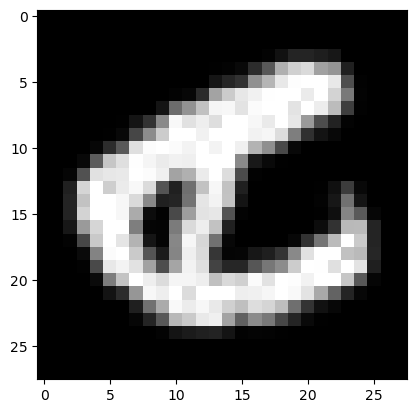

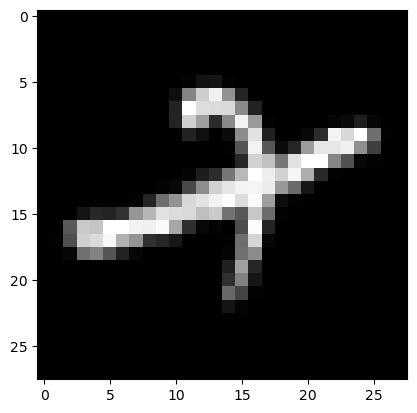

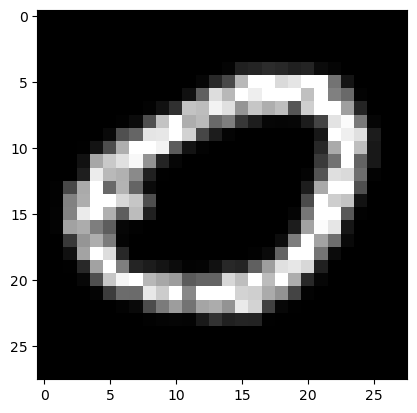

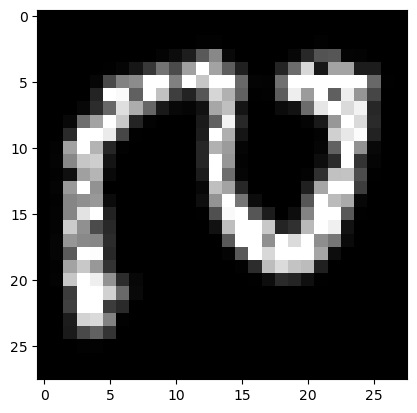

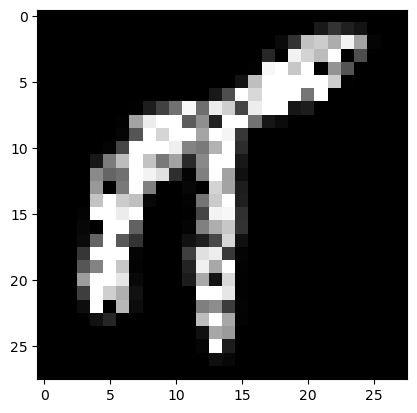

In [204]:
for idx in range(5):
    for data in emnist_test_dataloader_speckle[idx]:
        inputs, label = data
        plt.imshow(denormalize_grayscale_image(inputs), cmap='gray')
        plt.show()
        break

#### Memory pattern based

In [353]:
speckle_mlp_mp = []
for idx in range(5):
    d = MLPBaseline_test_accuracy(MLPBaseline_EMNIST_MP, emnist_test_dataloader_speckle[idx])
    speckle_mlp_mp.append(d[0])

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

#### Combinatorial Generalization

In [354]:
speckle_mlp_cg = []
for idx in range(5):
    d = MLPBaseline_test_accuracy(MLPBaseline_EMNIST_CG, emnist_test_dataloader_speckle[idx])
    speckle_mlp_cg.append(d[0])

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

### Occlusion Noise

#### Visualization of noise levels

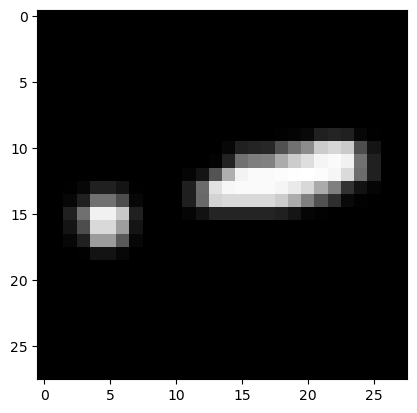

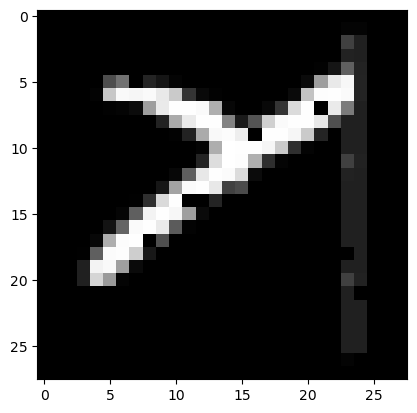

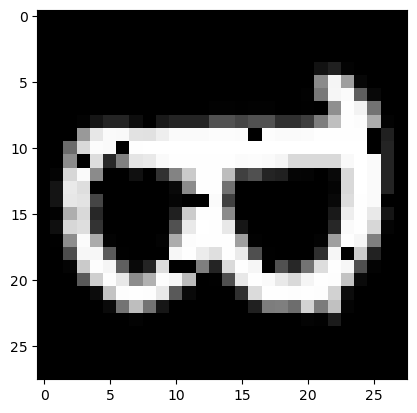

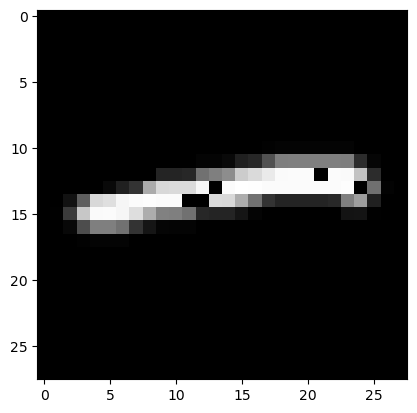

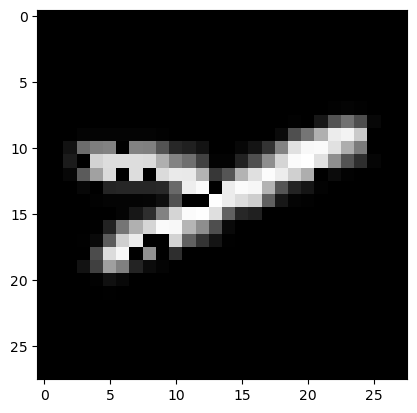

In [243]:
for idx in range(5):
    for data in emnist_test_dataloader_occlusion[idx]:
        inputs, label = data
        plt.imshow(denormalize_grayscale_image(inputs), cmap='gray')
        plt.show()
        break

#### MP

In [355]:
occlusion_mlp_mp = []
for idx in range(5):
    d = MLPBaseline_test_accuracy(MLPBaseline_EMNIST_MP, emnist_test_dataloader_occlusion[idx])
    occlusion_mlp_mp.append(d[0])

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

#### CG

In [356]:
occlusion_mlp_cg = []
for idx in range(5):
    d = MLPBaseline_test_accuracy(MLPBaseline_EMNIST_CG, emnist_test_dataloader_occlusion[idx])
    occlusion_mlp_cg.append(d[0])

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

### Average Blur

#### Noise level visualization

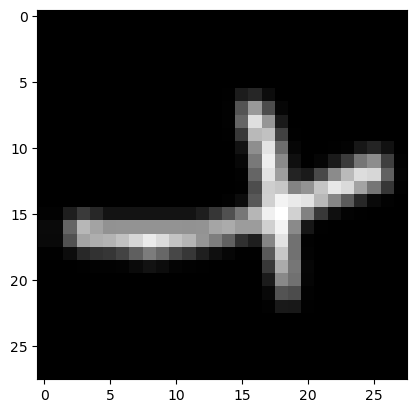

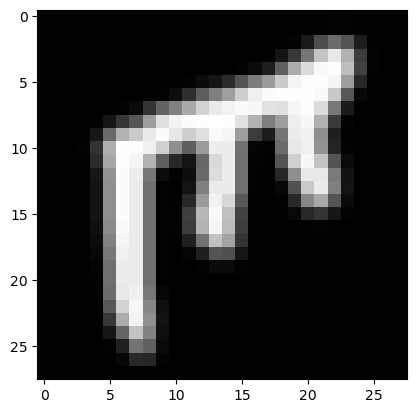

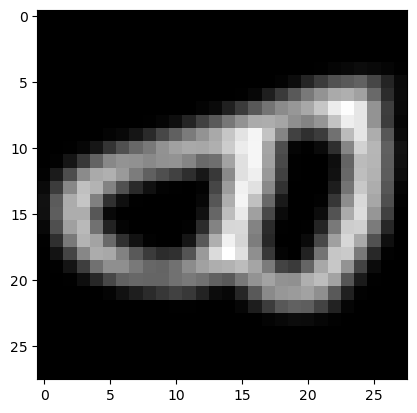

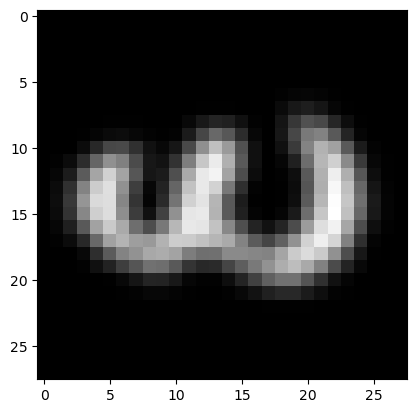

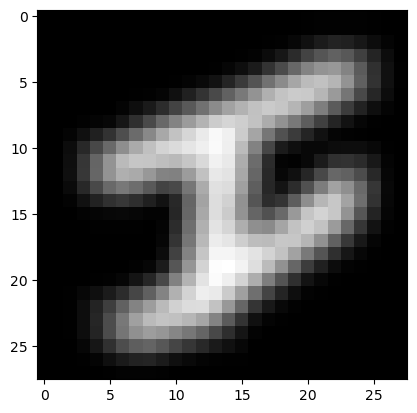

In [246]:
for idx in range(5):
    for data in emnist_test_dataloader_averageblur[idx]:
        inputs, label = data
        plt.imshow(denormalize_grayscale_image(inputs), cmap='gray')
        plt.show()
        break

#### MP

In [357]:
averageblur_mlp_mp = []
for idx in range(5):
    d = MLPBaseline_test_accuracy(MLPBaseline_EMNIST_MP, emnist_test_dataloader_averageblur[idx])
    averageblur_mlp_mp.append(d[0])

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

#### CG

In [358]:
averageblur_mlp_cg = []
for idx in range(5):
    d = MLPBaseline_test_accuracy(MLPBaseline_EMNIST_CG, emnist_test_dataloader_averageblur[idx])
    averageblur_mlp_cg.append(d[0])

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

### EMNIST Sanger

In [276]:
MLPBaseline_EMNIST_other = MLPBaseline_Experiment(hsize=64, lamb=15, lr=0.005, learning=Learning.Sanger, e=0.01, dataloader=emnist_train_loader, nclasses=47)

  0%|          | 0/112800 [00:00<?, ?it/s]

/Users/zhaoyizhe/miniconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

In [277]:
print(MLPBaseline_test_accuracy(MLPBaseline_EMNIST_other, emnist_train_loader))
print(MLPBaseline_test_accuracy(MLPBaseline_EMNIST_other, emnist_test_loader))

  0%|          | 0/112800 [00:00<?, ?it/s]

/Users/zhaoyizhe/miniconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


(0.3429609929078014, {45: (1315, 2400), 36: (1133, 2400), 43: (1038, 2400), 15: (780, 2400), 4: (615, 2400), 42: (884, 2400), 26: (558, 2400), 32: (1767, 2400), 20: (625, 2400), 1: (466, 2400), 46: (576, 2400), 13: (460, 2400), 24: (636, 2400), 12: (466, 2400), 5: (1132, 2400), 17: (1082, 2400), 3: (989, 2400), 40: (554, 2400), 14: (370, 2400), 44: (19, 2400), 19: (653, 2400), 29: (1606, 2400), 25: (1169, 2400), 35: (1294, 2400), 28: (406, 2400), 23: (806, 2400), 22: (1727, 2400), 34: (794, 2400), 9: (888, 2400), 30: (1360, 2400), 38: (334, 2400), 39: (303, 2400), 37: (896, 2400), 31: (943, 2400), 16: (740, 2400), 7: (1240, 2400), 2: (140, 2400), 8: (891, 2400), 10: (1320, 2400), 6: (1152, 2400), 27: (93, 2400), 33: (782, 2400), 11: (571, 2400), 18: (5, 2400), 41: (811, 2400), 0: (1205, 2400), 21: (1092, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.3400531914893617, {37: (146, 400), 33: (126, 400), 7: (207, 400), 3: (177, 400), 28: (69, 400), 34: (135, 400), 46: (88, 400), 22: (275, 400), 19: (108, 400), 16: (131, 400), 42: (139, 400), 6: (198, 400), 41: (135, 400), 31: (139, 400), 39: (44, 400), 25: (187, 400), 18: (2, 400), 44: (3, 400), 2: (21, 400), 23: (137, 400), 26: (98, 400), 0: (205, 400), 9: (143, 400), 32: (309, 400), 12: (91, 400), 43: (161, 400), 40: (88, 400), 11: (88, 400), 21: (188, 400), 14: (71, 400), 24: (111, 400), 8: (136, 400), 15: (141, 400), 29: (249, 400), 4: (115, 400), 10: (211, 400), 35: (212, 400), 17: (175, 400), 1: (76, 400), 20: (108, 400), 5: (189, 400), 38: (58, 400), 36: (176, 400), 13: (65, 400), 27: (21, 400), 30: (227, 400), 45: (214, 400)})


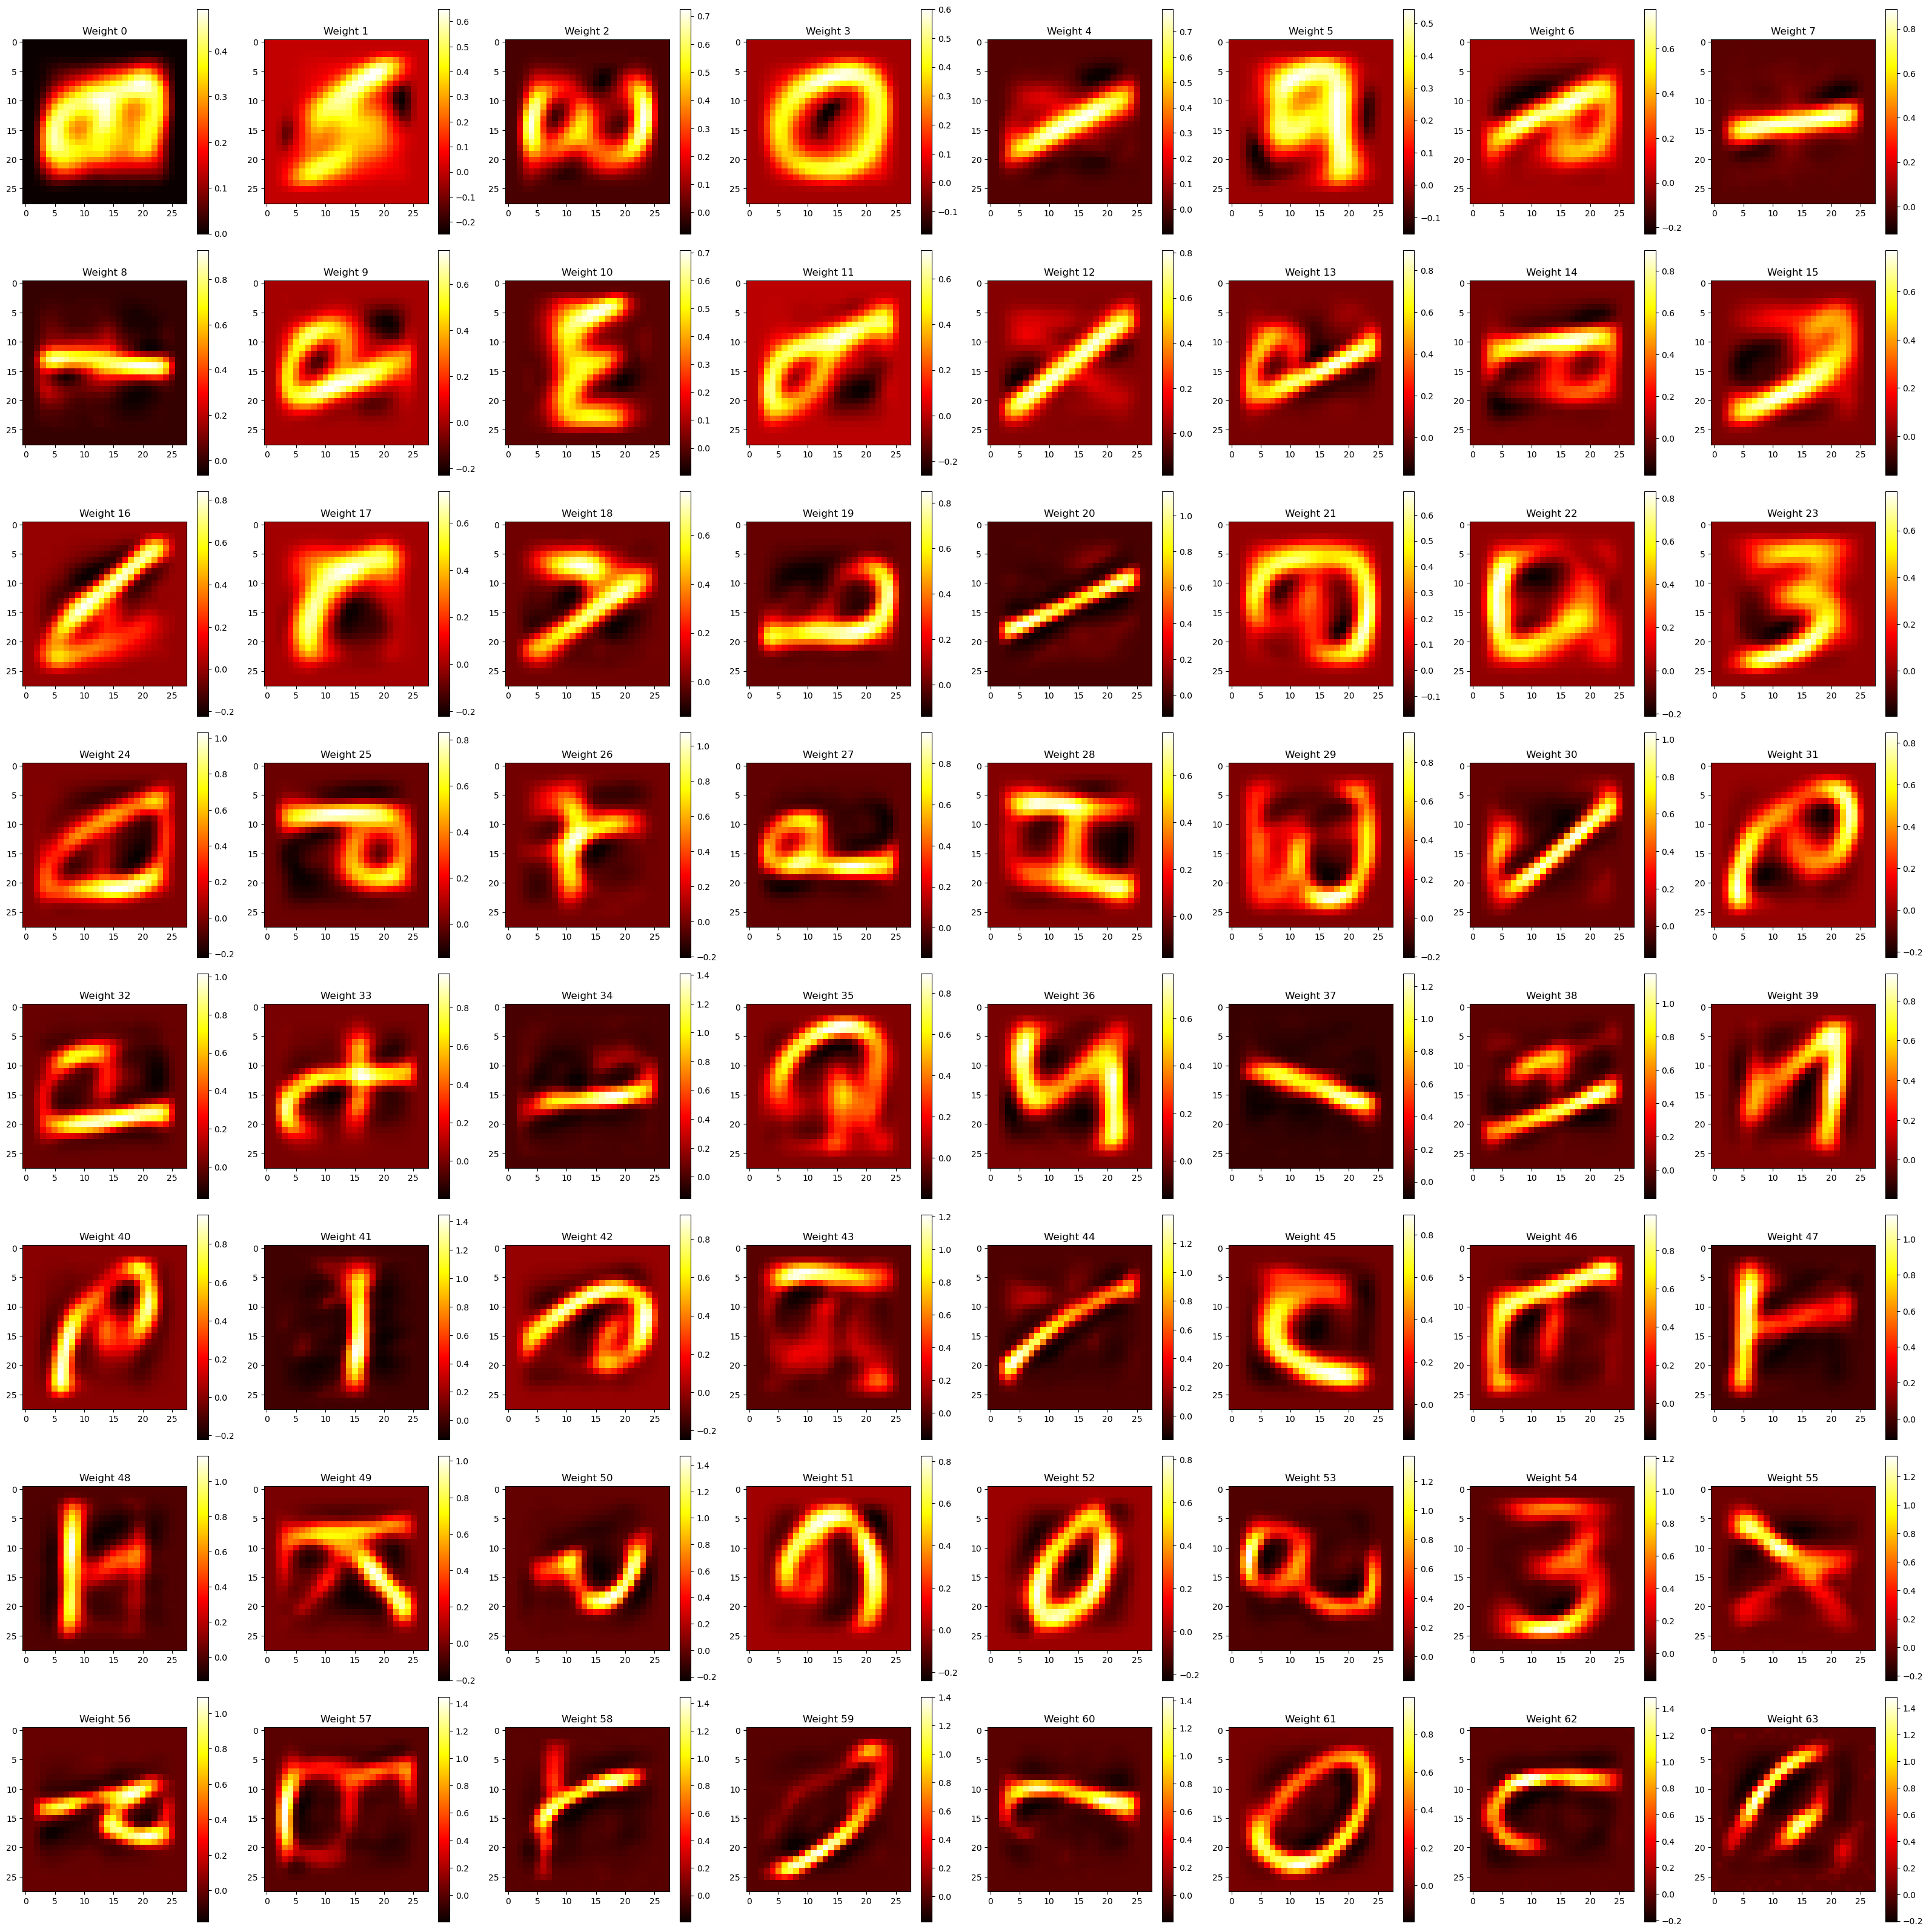

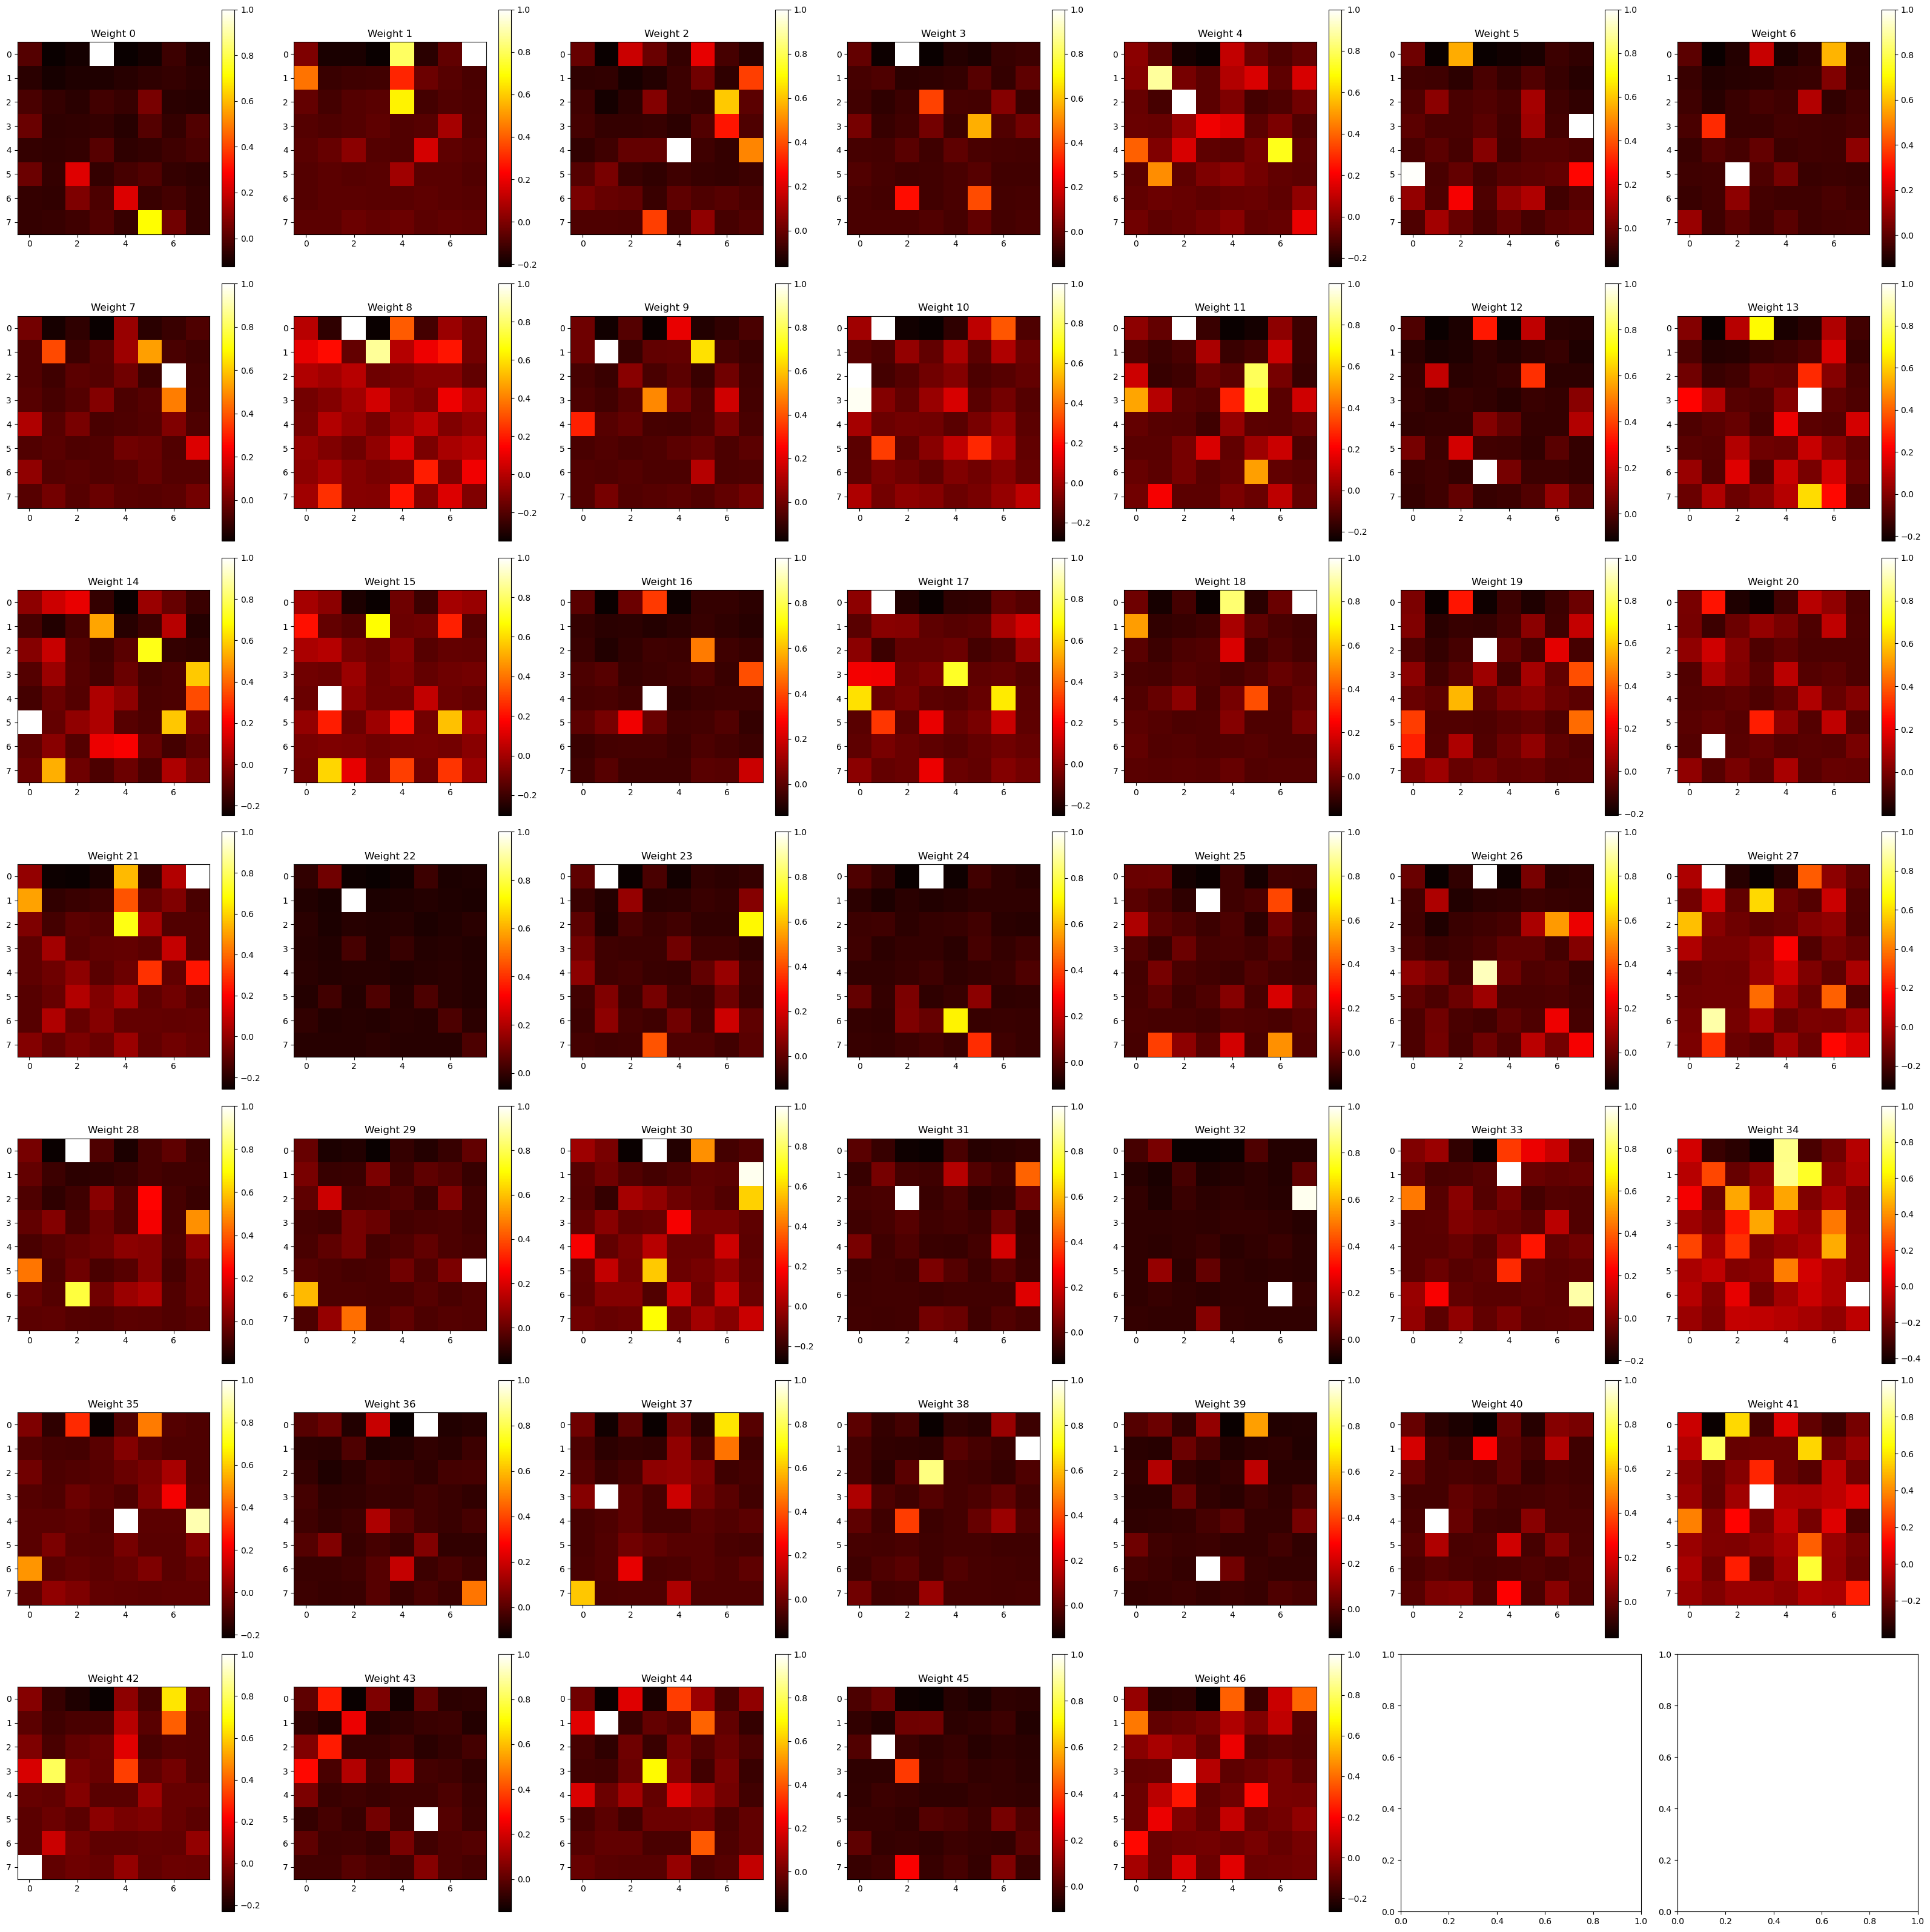

In [278]:
MLPBaseline_EMNIST_other.visualize_weights()

## Top Down

#### No Noise

In [263]:
for l in lambs:
    for e in eps:
        print("Hyper params : lambda = " + str(l) + ", epsilon = " + str(e))
        TOPDOWNBaseline_EMNIST = TopDownBaseline_Experiment(hsize=64, lamb=l, lr=0.005, learning=Learning.FullyOrthogonal, e=e, dataloader=emnist_train_loader, nclasses=47)
        print(MLPBaseline_test_accuracy(TOPDOWNBaseline_EMNIST, emnist_train_loader))
        print(MLPBaseline_test_accuracy(TOPDOWNBaseline_EMNIST, emnist_test_loader))

Hyper params : lambda = 0.4, epsilon = 0.001


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.2386081560283688, {45: (958, 2400), 36: (174, 2400), 43: (1202, 2400), 15: (222, 2400), 4: (276, 2400), 42: (1167, 2400), 26: (1837, 2400), 32: (2198, 2400), 20: (352, 2400), 1: (563, 2400), 46: (571, 2400), 13: (75, 2400), 24: (1073, 2400), 12: (334, 2400), 5: (819, 2400), 17: (747, 2400), 3: (842, 2400), 40: (751, 2400), 14: (9, 2400), 44: (4, 2400), 19: (327, 2400), 29: (1112, 2400), 25: (890, 2400), 35: (816, 2400), 28: (0, 2400), 23: (64, 2400), 22: (88, 2400), 34: (954, 2400), 9: (1147, 2400), 30: (711, 2400), 38: (1582, 2400), 39: (0, 2400), 37: (139, 2400), 31: (1110, 2400), 16: (592, 2400), 7: (690, 2400), 2: (6, 2400), 8: (180, 2400), 10: (202, 2400), 6: (611, 2400), 27: (0, 2400), 33: (1, 2400), 11: (350, 2400), 18: (96, 2400), 41: (0, 2400), 0: (117, 2400), 21: (956, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.23946808510638298, {44: (1, 400), 10: (46, 400), 27: (0, 400), 6: (99, 400), 5: (127, 400), 42: (202, 400), 2: (1, 400), 25: (145, 400), 28: (0, 400), 26: (316, 400), 38: (279, 400), 29: (172, 400), 16: (109, 400), 43: (194, 400), 18: (12, 400), 37: (25, 400), 36: (24, 400), 33: (1, 400), 32: (375, 400), 14: (1, 400), 17: (118, 400), 24: (182, 400), 21: (167, 400), 41: (0, 400), 0: (24, 400), 31: (181, 400), 39: (0, 400), 12: (59, 400), 11: (63, 400), 3: (146, 400), 30: (111, 400), 4: (40, 400), 1: (86, 400), 19: (49, 400), 7: (117, 400), 8: (32, 400), 46: (106, 400), 9: (187, 400), 15: (33, 400), 45: (152, 400), 22: (18, 400), 20: (59, 400), 35: (146, 400), 40: (119, 400), 13: (14, 400), 23: (13, 400), 34: (151, 400)})
Hyper params : lambda = 0.4, epsilon = 0.01


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.3235195035460993, {45: (651, 2400), 36: (616, 2400), 43: (926, 2400), 15: (80, 2400), 4: (1000, 2400), 42: (824, 2400), 26: (1721, 2400), 32: (2119, 2400), 20: (771, 2400), 1: (1265, 2400), 46: (843, 2400), 13: (1112, 2400), 24: (1109, 2400), 12: (327, 2400), 5: (1180, 2400), 17: (40, 2400), 3: (88, 2400), 40: (1598, 2400), 14: (0, 2400), 44: (1416, 2400), 19: (1230, 2400), 29: (1340, 2400), 25: (62, 2400), 35: (564, 2400), 28: (0, 2400), 23: (1484, 2400), 22: (2181, 2400), 34: (288, 2400), 9: (11, 2400), 30: (920, 2400), 38: (1428, 2400), 39: (0, 2400), 37: (355, 2400), 31: (1330, 2400), 16: (1183, 2400), 7: (501, 2400), 2: (1054, 2400), 8: (805, 2400), 10: (423, 2400), 6: (1374, 2400), 27: (113, 2400), 33: (1038, 2400), 11: (0, 2400), 18: (921, 2400), 41: (1, 2400), 0: (1, 2400), 21: (200, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.3219148936170213, {34: (43, 400), 9: (2, 400), 43: (145, 400), 42: (143, 400), 29: (210, 400), 5: (193, 400), 19: (203, 400), 37: (52, 400), 28: (0, 400), 41: (0, 400), 10: (78, 400), 25: (14, 400), 11: (0, 400), 36: (89, 400), 2: (186, 400), 32: (367, 400), 6: (237, 400), 38: (242, 400), 24: (193, 400), 3: (16, 400), 30: (137, 400), 39: (0, 400), 27: (16, 400), 16: (196, 400), 12: (68, 400), 7: (85, 400), 35: (93, 400), 23: (250, 400), 21: (37, 400), 14: (0, 400), 15: (16, 400), 4: (163, 400), 17: (11, 400), 26: (297, 400), 18: (130, 400), 40: (263, 400), 44: (241, 400), 22: (360, 400), 31: (197, 400), 45: (103, 400), 1: (202, 400), 13: (197, 400), 33: (178, 400), 20: (135, 400), 46: (137, 400), 0: (1, 400), 8: (126, 400)})
Hyper params : lambda = 0.4, epsilon = 0.1


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.3305141843971631, {45: (1468, 2400), 36: (1209, 2400), 43: (1529, 2400), 15: (201, 2400), 4: (300, 2400), 42: (92, 2400), 26: (1213, 2400), 32: (782, 2400), 20: (628, 2400), 1: (0, 2400), 46: (14, 2400), 13: (892, 2400), 24: (694, 2400), 12: (49, 2400), 5: (914, 2400), 17: (1196, 2400), 3: (308, 2400), 40: (138, 2400), 14: (1613, 2400), 44: (794, 2400), 19: (1, 2400), 29: (217, 2400), 25: (1202, 2400), 35: (974, 2400), 28: (1351, 2400), 23: (940, 2400), 22: (1335, 2400), 34: (43, 2400), 9: (71, 2400), 30: (223, 2400), 38: (1264, 2400), 39: (1784, 2400), 37: (319, 2400), 31: (1389, 2400), 16: (1128, 2400), 7: (900, 2400), 2: (931, 2400), 8: (1669, 2400), 10: (1945, 2400), 6: (1132, 2400), 27: (1317, 2400), 33: (1062, 2400), 11: (937, 2400), 18: (0, 2400), 41: (409, 2400), 0: (705, 2400), 21: (0, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.3302127659574468, {12: (13, 400), 24: (132, 400), 23: (150, 400), 1: (0, 400), 42: (10, 400), 45: (231, 400), 19: (0, 400), 38: (220, 400), 13: (158, 400), 16: (191, 400), 41: (70, 400), 29: (38, 400), 28: (219, 400), 5: (149, 400), 35: (169, 400), 7: (148, 400), 3: (61, 400), 32: (159, 400), 44: (130, 400), 27: (202, 400), 4: (39, 400), 14: (267, 400), 9: (16, 400), 20: (100, 400), 34: (5, 400), 15: (36, 400), 36: (196, 400), 17: (202, 400), 46: (4, 400), 11: (155, 400), 31: (209, 400), 26: (214, 400), 21: (0, 400), 30: (30, 400), 33: (188, 400), 37: (54, 400), 25: (198, 400), 39: (305, 400), 0: (126, 400), 8: (273, 400), 40: (19, 400), 2: (162, 400), 10: (306, 400), 18: (0, 400), 6: (173, 400), 22: (223, 400), 43: (258, 400)})
Hyper params : lambda = 0.7, epsilon = 0.001


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.2656560283687943, {45: (1209, 2400), 36: (12, 2400), 43: (837, 2400), 15: (297, 2400), 4: (408, 2400), 42: (660, 2400), 26: (114, 2400), 32: (752, 2400), 20: (176, 2400), 1: (0, 2400), 46: (862, 2400), 13: (1777, 2400), 24: (0, 2400), 12: (100, 2400), 5: (1141, 2400), 17: (810, 2400), 3: (856, 2400), 40: (269, 2400), 14: (855, 2400), 44: (354, 2400), 19: (565, 2400), 29: (808, 2400), 25: (772, 2400), 35: (807, 2400), 28: (7, 2400), 23: (1262, 2400), 22: (2287, 2400), 34: (1063, 2400), 9: (444, 2400), 30: (861, 2400), 38: (602, 2400), 39: (0, 2400), 37: (523, 2400), 31: (661, 2400), 16: (1608, 2400), 7: (1742, 2400), 2: (139, 2400), 8: (822, 2400), 10: (770, 2400), 6: (504, 2400), 27: (28, 2400), 33: (1251, 2400), 11: (5, 2400), 18: (3, 2400), 41: (19, 2400), 0: (0, 2400), 21: (924, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.2623404255319149, {6: (67, 400), 22: (377, 400), 31: (96, 400), 8: (124, 400), 45: (194, 400), 0: (0, 400), 39: (0, 400), 35: (139, 400), 17: (136, 400), 5: (200, 400), 25: (130, 400), 9: (64, 400), 44: (69, 400), 42: (121, 400), 21: (159, 400), 7: (288, 400), 41: (2, 400), 13: (292, 400), 46: (149, 400), 18: (0, 400), 14: (140, 400), 1: (0, 400), 34: (161, 400), 40: (37, 400), 28: (0, 400), 15: (53, 400), 12: (15, 400), 32: (146, 400), 36: (1, 400), 26: (13, 400), 33: (202, 400), 10: (131, 400), 19: (86, 400), 30: (153, 400), 11: (0, 400), 37: (80, 400), 20: (28, 400), 23: (223, 400), 38: (108, 400), 24: (0, 400), 3: (141, 400), 43: (132, 400), 29: (117, 400), 4: (63, 400), 2: (25, 400), 16: (268, 400), 27: (2, 400)})
Hyper params : lambda = 0.7, epsilon = 0.01


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.16602836879432625, {45: (6, 2400), 36: (266, 2400), 43: (8, 2400), 15: (336, 2400), 4: (138, 2400), 42: (141, 2400), 26: (352, 2400), 32: (1642, 2400), 20: (6, 2400), 1: (2203, 2400), 46: (649, 2400), 13: (414, 2400), 24: (9, 2400), 12: (171, 2400), 5: (258, 2400), 17: (0, 2400), 3: (523, 2400), 40: (323, 2400), 14: (0, 2400), 44: (635, 2400), 19: (551, 2400), 29: (459, 2400), 25: (13, 2400), 35: (117, 2400), 28: (40, 2400), 23: (488, 2400), 22: (2146, 2400), 34: (555, 2400), 9: (15, 2400), 30: (64, 2400), 38: (723, 2400), 39: (0, 2400), 37: (105, 2400), 31: (1118, 2400), 16: (1082, 2400), 7: (1349, 2400), 2: (4, 2400), 8: (9, 2400), 10: (11, 2400), 6: (1, 2400), 27: (1, 2400), 33: (950, 2400), 11: (26, 2400), 18: (215, 2400), 41: (38, 2400), 0: (20, 2400), 21: (548, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.1671808510638298, {36: (41, 400), 33: (145, 400), 18: (47, 400), 35: (13, 400), 29: (81, 400), 32: (295, 400), 42: (17, 400), 43: (0, 400), 3: (100, 400), 44: (99, 400), 4: (19, 400), 41: (5, 400), 8: (3, 400), 26: (66, 400), 13: (70, 400), 27: (0, 400), 23: (80, 400), 40: (53, 400), 25: (2, 400), 46: (105, 400), 14: (0, 400), 17: (0, 400), 19: (85, 400), 31: (174, 400), 45: (1, 400), 0: (5, 400), 20: (1, 400), 30: (14, 400), 12: (41, 400), 5: (44, 400), 38: (125, 400), 9: (2, 400), 37: (28, 400), 34: (88, 400), 2: (1, 400), 1: (352, 400), 24: (2, 400), 10: (3, 400), 15: (61, 400), 28: (10, 400), 7: (219, 400), 6: (0, 400), 22: (364, 400), 21: (89, 400), 39: (0, 400), 16: (188, 400), 11: (5, 400)})
Hyper params : lambda = 0.7, epsilon = 0.1


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.32711879432624114, {45: (979, 2400), 36: (1063, 2400), 43: (1706, 2400), 15: (5, 2400), 4: (584, 2400), 42: (98, 2400), 26: (1212, 2400), 32: (395, 2400), 20: (86, 2400), 1: (0, 2400), 46: (2, 2400), 13: (1160, 2400), 24: (805, 2400), 12: (0, 2400), 5: (797, 2400), 17: (1726, 2400), 3: (1113, 2400), 40: (542, 2400), 14: (1655, 2400), 44: (587, 2400), 19: (0, 2400), 29: (83, 2400), 25: (516, 2400), 35: (1244, 2400), 28: (1238, 2400), 23: (884, 2400), 22: (936, 2400), 34: (0, 2400), 9: (0, 2400), 30: (257, 2400), 38: (1117, 2400), 39: (2016, 2400), 37: (211, 2400), 31: (1324, 2400), 16: (1358, 2400), 7: (431, 2400), 2: (1335, 2400), 8: (1544, 2400), 10: (1798, 2400), 6: (1183, 2400), 27: (1052, 2400), 33: (1695, 2400), 11: (1292, 2400), 18: (0, 2400), 41: (318, 2400), 0: (552, 2400), 21: (0, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.3248936170212766, {44: (90, 400), 24: (142, 400), 10: (289, 400), 35: (205, 400), 32: (81, 400), 23: (142, 400), 40: (73, 400), 21: (0, 400), 41: (49, 400), 42: (14, 400), 25: (88, 400), 22: (154, 400), 43: (283, 400), 29: (9, 400), 45: (168, 400), 27: (144, 400), 37: (34, 400), 20: (18, 400), 30: (35, 400), 39: (347, 400), 4: (88, 400), 16: (225, 400), 18: (0, 400), 26: (220, 400), 17: (274, 400), 11: (211, 400), 5: (124, 400), 9: (0, 400), 14: (280, 400), 33: (282, 400), 12: (0, 400), 6: (193, 400), 15: (0, 400), 2: (233, 400), 28: (209, 400), 8: (256, 400), 13: (202, 400), 34: (0, 400), 3: (206, 400), 1: (0, 400), 19: (0, 400), 7: (79, 400), 38: (199, 400), 46: (0, 400), 31: (191, 400), 0: (106, 400), 36: (165, 400)})
Hyper params : lambda = 1, epsilon = 0.001


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.1914450354609929, {45: (654, 2400), 36: (302, 2400), 43: (1357, 2400), 15: (548, 2400), 4: (158, 2400), 42: (42, 2400), 26: (898, 2400), 32: (1613, 2400), 20: (817, 2400), 1: (340, 2400), 46: (62, 2400), 13: (60, 2400), 24: (126, 2400), 12: (158, 2400), 5: (310, 2400), 17: (769, 2400), 3: (608, 2400), 40: (366, 2400), 14: (355, 2400), 44: (773, 2400), 19: (828, 2400), 29: (597, 2400), 25: (112, 2400), 35: (378, 2400), 28: (79, 2400), 23: (416, 2400), 22: (319, 2400), 34: (202, 2400), 9: (14, 2400), 30: (108, 2400), 38: (1006, 2400), 39: (1710, 2400), 37: (17, 2400), 31: (722, 2400), 16: (1528, 2400), 7: (493, 2400), 2: (2, 2400), 8: (0, 2400), 10: (12, 2400), 6: (110, 2400), 27: (106, 2400), 33: (1220, 2400), 11: (21, 2400), 18: (1117, 2400), 41: (87, 2400), 0: (0, 2400), 21: (75, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.19180851063829787, {4: (23, 400), 3: (109, 400), 39: (291, 400), 12: (35, 400), 18: (161, 400), 23: (74, 400), 9: (6, 400), 15: (101, 400), 14: (59, 400), 16: (251, 400), 24: (22, 400), 22: (56, 400), 13: (19, 400), 20: (135, 400), 7: (82, 400), 21: (21, 400), 1: (56, 400), 26: (140, 400), 0: (0, 400), 41: (13, 400), 5: (51, 400), 2: (0, 400), 35: (64, 400), 45: (101, 400), 36: (46, 400), 31: (107, 400), 19: (131, 400), 43: (215, 400), 10: (2, 400), 32: (293, 400), 40: (56, 400), 42: (5, 400), 29: (103, 400), 44: (144, 400), 25: (19, 400), 11: (3, 400), 46: (8, 400), 38: (179, 400), 34: (17, 400), 28: (13, 400), 30: (17, 400), 8: (0, 400), 6: (19, 400), 33: (211, 400), 37: (3, 400), 17: (133, 400), 27: (12, 400)})
Hyper params : lambda = 1, epsilon = 0.01


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.3303191489361702, {45: (1681, 2400), 36: (916, 2400), 43: (1385, 2400), 15: (37, 2400), 4: (541, 2400), 42: (1010, 2400), 26: (775, 2400), 32: (1639, 2400), 20: (759, 2400), 1: (796, 2400), 46: (1274, 2400), 13: (1601, 2400), 24: (38, 2400), 12: (930, 2400), 5: (1401, 2400), 17: (1, 2400), 3: (781, 2400), 40: (805, 2400), 14: (9, 2400), 44: (1109, 2400), 19: (547, 2400), 29: (89, 2400), 25: (325, 2400), 35: (639, 2400), 28: (38, 2400), 23: (968, 2400), 22: (2011, 2400), 34: (1340, 2400), 9: (470, 2400), 30: (966, 2400), 38: (658, 2400), 39: (868, 2400), 37: (46, 2400), 31: (1211, 2400), 16: (885, 2400), 7: (2013, 2400), 2: (1166, 2400), 8: (115, 2400), 10: (234, 2400), 6: (1393, 2400), 27: (131, 2400), 33: (274, 2400), 11: (17, 2400), 18: (1771, 2400), 41: (0, 2400), 0: (1212, 2400), 21: (385, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.3293617021276596, {22: (339, 400), 2: (203, 400), 15: (5, 400), 27: (20, 400), 1: (133, 400), 37: (12, 400), 19: (97, 400), 36: (133, 400), 16: (157, 400), 3: (146, 400), 46: (206, 400), 25: (49, 400), 14: (2, 400), 11: (4, 400), 4: (82, 400), 26: (150, 400), 20: (132, 400), 18: (281, 400), 0: (193, 400), 33: (42, 400), 5: (250, 400), 12: (158, 400), 43: (236, 400), 9: (63, 400), 35: (101, 400), 21: (69, 400), 39: (149, 400), 6: (238, 400), 30: (154, 400), 10: (34, 400), 40: (122, 400), 45: (272, 400), 29: (9, 400), 31: (195, 400), 34: (226, 400), 41: (0, 400), 24: (6, 400), 42: (171, 400), 38: (108, 400), 44: (175, 400), 8: (16, 400), 23: (159, 400), 28: (2, 400), 32: (287, 400), 13: (256, 400), 17: (0, 400), 7: (350, 400)})
Hyper params : lambda = 1, epsilon = 0.1


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.3028014184397163, {45: (976, 2400), 36: (1378, 2400), 43: (1454, 2400), 15: (0, 2400), 4: (1126, 2400), 42: (0, 2400), 26: (1025, 2400), 32: (1, 2400), 20: (89, 2400), 1: (0, 2400), 46: (25, 2400), 13: (96, 2400), 24: (26, 2400), 12: (0, 2400), 5: (869, 2400), 17: (1570, 2400), 3: (1824, 2400), 40: (388, 2400), 14: (1407, 2400), 44: (381, 2400), 19: (0, 2400), 29: (13, 2400), 25: (55, 2400), 35: (1470, 2400), 28: (1584, 2400), 23: (567, 2400), 22: (649, 2400), 34: (0, 2400), 9: (0, 2400), 30: (623, 2400), 38: (1137, 2400), 39: (1837, 2400), 37: (8, 2400), 31: (871, 2400), 16: (1174, 2400), 7: (887, 2400), 2: (1011, 2400), 8: (1828, 2400), 10: (1718, 2400), 6: (2021, 2400), 27: (1740, 2400), 33: (1168, 2400), 11: (894, 2400), 18: (74, 2400), 41: (192, 2400), 0: (0, 2400), 21: (0, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.3, {18: (10, 400), 35: (254, 400), 9: (0, 400), 16: (194, 400), 8: (300, 400), 34: (0, 400), 4: (178, 400), 33: (193, 400), 42: (0, 400), 41: (34, 400), 17: (257, 400), 25: (8, 400), 26: (178, 400), 23: (100, 400), 31: (131, 400), 43: (236, 400), 21: (0, 400), 1: (0, 400), 22: (115, 400), 32: (0, 400), 6: (340, 400), 2: (177, 400), 45: (151, 400), 13: (19, 400), 19: (0, 400), 14: (239, 400), 20: (24, 400), 11: (152, 400), 44: (59, 400), 5: (124, 400), 24: (3, 400), 15: (0, 400), 40: (58, 400), 28: (252, 400), 27: (274, 400), 3: (325, 400), 10: (284, 400), 36: (227, 400), 46: (3, 400), 7: (146, 400), 29: (1, 400), 0: (0, 400), 30: (79, 400), 38: (200, 400), 12: (0, 400), 39: (314, 400), 37: (1, 400)})
Hyper params : lambda = 2, epsilon = 0.001


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.11993794326241135, {45: (531, 2400), 36: (1282, 2400), 43: (492, 2400), 15: (0, 2400), 4: (242, 2400), 42: (3, 2400), 26: (767, 2400), 32: (865, 2400), 20: (1603, 2400), 1: (58, 2400), 46: (4, 2400), 13: (0, 2400), 24: (0, 2400), 12: (235, 2400), 5: (0, 2400), 17: (116, 2400), 3: (175, 2400), 40: (628, 2400), 14: (4, 2400), 44: (332, 2400), 19: (300, 2400), 29: (46, 2400), 25: (1, 2400), 35: (275, 2400), 28: (9, 2400), 23: (90, 2400), 22: (1101, 2400), 34: (379, 2400), 9: (149, 2400), 30: (1, 2400), 38: (66, 2400), 39: (237, 2400), 37: (5, 2400), 31: (349, 2400), 16: (145, 2400), 7: (547, 2400), 2: (125, 2400), 8: (0, 2400), 10: (70, 2400), 6: (423, 2400), 27: (0, 2400), 33: (13, 2400), 11: (393, 2400), 18: (985, 2400), 41: (247, 2400), 0: (0, 2400), 21: (236, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.11776595744680851, {38: (15, 400), 11: (76, 400), 36: (205, 400), 32: (165, 400), 0: (0, 400), 29: (9, 400), 24: (0, 400), 39: (35, 400), 18: (135, 400), 20: (263, 400), 25: (0, 400), 26: (120, 400), 5: (0, 400), 14: (0, 400), 6: (73, 400), 43: (83, 400), 30: (0, 400), 44: (68, 400), 28: (1, 400), 46: (0, 400), 12: (45, 400), 2: (10, 400), 41: (42, 400), 15: (0, 400), 34: (61, 400), 1: (7, 400), 21: (43, 400), 45: (78, 400), 33: (3, 400), 37: (0, 400), 13: (0, 400), 42: (0, 400), 22: (184, 400), 23: (15, 400), 7: (92, 400), 17: (18, 400), 40: (102, 400), 27: (0, 400), 16: (29, 400), 10: (13, 400), 9: (14, 400), 19: (58, 400), 31: (44, 400), 35: (39, 400), 4: (39, 400), 8: (0, 400), 3: (30, 400)})
Hyper params : lambda = 2, epsilon = 0.01


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.35596631205673757, {45: (927, 2400), 36: (1389, 2400), 43: (1831, 2400), 15: (413, 2400), 4: (1889, 2400), 42: (1077, 2400), 26: (708, 2400), 32: (1093, 2400), 20: (732, 2400), 1: (3, 2400), 46: (681, 2400), 13: (1711, 2400), 24: (588, 2400), 12: (1037, 2400), 5: (1059, 2400), 17: (734, 2400), 3: (105, 2400), 40: (1363, 2400), 14: (290, 2400), 44: (915, 2400), 19: (1017, 2400), 29: (423, 2400), 25: (684, 2400), 35: (1078, 2400), 28: (897, 2400), 23: (1665, 2400), 22: (122, 2400), 34: (307, 2400), 9: (12, 2400), 30: (94, 2400), 38: (698, 2400), 39: (186, 2400), 37: (249, 2400), 31: (1163, 2400), 16: (1642, 2400), 7: (1437, 2400), 2: (1235, 2400), 8: (1075, 2400), 10: (233, 2400), 6: (1798, 2400), 27: (1000, 2400), 33: (1734, 2400), 11: (274, 2400), 18: (1565, 2400), 41: (1020, 2400), 0: (0, 2400), 21: (0, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.3522872340425532, {44: (153, 400), 46: (106, 400), 18: (246, 400), 22: (17, 400), 3: (17, 400), 34: (38, 400), 39: (27, 400), 42: (193, 400), 37: (45, 400), 30: (8, 400), 36: (230, 400), 17: (127, 400), 19: (160, 400), 2: (215, 400), 11: (52, 400), 24: (125, 400), 8: (172, 400), 38: (115, 400), 29: (52, 400), 45: (159, 400), 40: (211, 400), 13: (277, 400), 33: (289, 400), 35: (183, 400), 20: (129, 400), 5: (173, 400), 15: (64, 400), 25: (111, 400), 7: (239, 400), 23: (271, 400), 31: (180, 400), 27: (142, 400), 14: (49, 400), 4: (313, 400), 28: (151, 400), 43: (305, 400), 10: (46, 400), 1: (3, 400), 12: (188, 400), 0: (0, 400), 26: (101, 400), 32: (210, 400), 21: (0, 400), 16: (267, 400), 9: (2, 400), 41: (163, 400), 6: (299, 400)})
Hyper params : lambda = 2, epsilon = 0.1


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.3402659574468085, {45: (1213, 2400), 36: (1269, 2400), 43: (1099, 2400), 15: (21, 2400), 4: (326, 2400), 42: (660, 2400), 26: (1334, 2400), 32: (218, 2400), 20: (101, 2400), 1: (162, 2400), 46: (628, 2400), 13: (1295, 2400), 24: (403, 2400), 12: (0, 2400), 5: (201, 2400), 17: (2092, 2400), 3: (1219, 2400), 40: (754, 2400), 14: (1679, 2400), 44: (1174, 2400), 19: (256, 2400), 29: (313, 2400), 25: (1269, 2400), 35: (1175, 2400), 28: (1114, 2400), 23: (811, 2400), 22: (56, 2400), 34: (438, 2400), 9: (3, 2400), 30: (813, 2400), 38: (974, 2400), 39: (1771, 2400), 37: (1032, 2400), 31: (915, 2400), 16: (816, 2400), 7: (261, 2400), 2: (1231, 2400), 8: (1345, 2400), 10: (1672, 2400), 6: (1684, 2400), 27: (697, 2400), 33: (1493, 2400), 11: (1123, 2400), 18: (507, 2400), 41: (573, 2400), 0: (192, 2400), 21: (0, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.335531914893617, {43: (182, 400), 39: (307, 400), 32: (44, 400), 31: (137, 400), 41: (98, 400), 29: (34, 400), 16: (128, 400), 42: (110, 400), 13: (216, 400), 28: (180, 400), 1: (24, 400), 8: (223, 400), 26: (226, 400), 4: (61, 400), 18: (69, 400), 10: (287, 400), 35: (211, 400), 5: (26, 400), 30: (120, 400), 45: (187, 400), 9: (0, 400), 38: (164, 400), 11: (181, 400), 40: (112, 400), 12: (0, 400), 3: (219, 400), 7: (39, 400), 22: (6, 400), 15: (3, 400), 0: (37, 400), 17: (345, 400), 25: (209, 400), 46: (111, 400), 6: (274, 400), 24: (74, 400), 27: (102, 400), 20: (17, 400), 14: (293, 400), 23: (126, 400), 36: (213, 400), 37: (161, 400), 33: (251, 400), 19: (37, 400), 44: (199, 400), 2: (205, 400), 34: (60, 400), 21: (0, 400)})
Hyper params : lambda = 5, epsilon = 0.001


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.049813829787234046, {45: (87, 2400), 36: (27, 2400), 43: (252, 2400), 15: (0, 2400), 4: (149, 2400), 42: (2161, 2400), 26: (170, 2400), 32: (215, 2400), 20: (0, 2400), 1: (0, 2400), 46: (41, 2400), 13: (144, 2400), 24: (0, 2400), 12: (48, 2400), 5: (0, 2400), 17: (15, 2400), 3: (2, 2400), 40: (0, 2400), 14: (253, 2400), 44: (249, 2400), 19: (100, 2400), 29: (0, 2400), 25: (0, 2400), 35: (1, 2400), 28: (236, 2400), 23: (0, 2400), 22: (921, 2400), 34: (0, 2400), 9: (0, 2400), 30: (57, 2400), 38: (2, 2400), 39: (40, 2400), 37: (1, 2400), 31: (0, 2400), 16: (0, 2400), 7: (1, 2400), 2: (0, 2400), 8: (0, 2400), 10: (0, 2400), 6: (0, 2400), 27: (0, 2400), 33: (0, 2400), 11: (0, 2400), 18: (4, 2400), 41: (115, 2400), 0: (272, 2400), 21: (56, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.049148936170212765, {27: (0, 400), 1: (0, 400), 16: (0, 400), 33: (0, 400), 44: (48, 400), 13: (23, 400), 18: (0, 400), 42: (363, 400), 11: (0, 400), 6: (0, 400), 25: (1, 400), 35: (0, 400), 21: (6, 400), 15: (0, 400), 40: (0, 400), 8: (0, 400), 5: (0, 400), 28: (29, 400), 45: (11, 400), 30: (8, 400), 32: (41, 400), 0: (44, 400), 4: (23, 400), 29: (0, 400), 26: (32, 400), 14: (41, 400), 22: (150, 400), 9: (0, 400), 31: (0, 400), 36: (9, 400), 2: (0, 400), 19: (13, 400), 3: (0, 400), 10: (0, 400), 43: (40, 400), 41: (18, 400), 12: (8, 400), 46: (8, 400), 39: (5, 400), 20: (0, 400), 23: (0, 400), 34: (0, 400), 24: (0, 400), 38: (0, 400), 7: (0, 400), 17: (3, 400), 37: (0, 400)})
Hyper params : lambda = 5, epsilon = 0.01


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.3353191489361702, {45: (1378, 2400), 36: (1347, 2400), 43: (1162, 2400), 15: (151, 2400), 4: (225, 2400), 42: (245, 2400), 26: (995, 2400), 32: (1768, 2400), 20: (708, 2400), 1: (754, 2400), 46: (1134, 2400), 13: (1036, 2400), 24: (161, 2400), 12: (1160, 2400), 5: (573, 2400), 17: (1248, 2400), 3: (1039, 2400), 40: (498, 2400), 14: (1113, 2400), 44: (469, 2400), 19: (491, 2400), 29: (674, 2400), 25: (742, 2400), 35: (551, 2400), 28: (917, 2400), 23: (873, 2400), 22: (1387, 2400), 34: (436, 2400), 9: (163, 2400), 30: (525, 2400), 38: (578, 2400), 39: (127, 2400), 37: (1020, 2400), 31: (836, 2400), 16: (768, 2400), 7: (650, 2400), 2: (733, 2400), 8: (2144, 2400), 10: (1654, 2400), 6: (1358, 2400), 27: (1132, 2400), 33: (271, 2400), 11: (757, 2400), 18: (0, 2400), 41: (357, 2400), 0: (1516, 2400), 21: (0, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.33037234042553193, {7: (108, 400), 35: (84, 400), 17: (215, 400), 15: (31, 400), 18: (0, 400), 1: (122, 400), 19: (73, 400), 44: (75, 400), 34: (67, 400), 46: (196, 400), 21: (0, 400), 14: (197, 400), 27: (161, 400), 39: (23, 400), 40: (69, 400), 30: (74, 400), 10: (271, 400), 36: (214, 400), 24: (24, 400), 37: (153, 400), 3: (178, 400), 12: (200, 400), 11: (123, 400), 16: (129, 400), 25: (142, 400), 42: (41, 400), 26: (163, 400), 4: (35, 400), 6: (211, 400), 0: (252, 400), 32: (319, 400), 20: (121, 400), 23: (162, 400), 2: (130, 400), 22: (222, 400), 13: (173, 400), 31: (120, 400), 29: (101, 400), 33: (44, 400), 28: (152, 400), 45: (210, 400), 9: (28, 400), 43: (192, 400), 5: (102, 400), 38: (96, 400), 41: (45, 400), 8: (363, 400)})
Hyper params : lambda = 5, epsilon = 0.1


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.3612322695035461, {45: (1295, 2400), 36: (982, 2400), 43: (1093, 2400), 15: (251, 2400), 4: (856, 2400), 42: (1508, 2400), 26: (1005, 2400), 32: (655, 2400), 20: (1449, 2400), 1: (668, 2400), 46: (720, 2400), 13: (555, 2400), 24: (1895, 2400), 12: (446, 2400), 5: (591, 2400), 17: (691, 2400), 3: (1467, 2400), 40: (104, 2400), 14: (1236, 2400), 44: (149, 2400), 19: (1023, 2400), 29: (878, 2400), 25: (150, 2400), 35: (266, 2400), 28: (504, 2400), 23: (1590, 2400), 22: (1659, 2400), 34: (662, 2400), 9: (177, 2400), 30: (1019, 2400), 38: (1134, 2400), 39: (690, 2400), 37: (159, 2400), 31: (705, 2400), 16: (1141, 2400), 7: (1067, 2400), 2: (302, 2400), 8: (1643, 2400), 10: (1298, 2400), 6: (1104, 2400), 27: (1081, 2400), 33: (1406, 2400), 11: (1182, 2400), 18: (1088, 2400), 41: (982, 2400), 0: (221, 2400), 21: (0, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.3536170212765957, {38: (190, 400), 4: (132, 400), 21: (0, 400), 35: (34, 400), 30: (165, 400), 24: (313, 400), 8: (274, 400), 9: (27, 400), 45: (195, 400), 31: (102, 400), 2: (47, 400), 34: (100, 400), 32: (128, 400), 16: (202, 400), 3: (256, 400), 14: (202, 400), 12: (82, 400), 44: (32, 400), 36: (142, 400), 29: (123, 400), 22: (273, 400), 27: (157, 400), 39: (123, 400), 40: (17, 400), 13: (100, 400), 42: (253, 400), 41: (150, 400), 33: (227, 400), 23: (245, 400), 26: (158, 400), 25: (28, 400), 20: (242, 400), 0: (39, 400), 10: (217, 400), 37: (19, 400), 17: (124, 400), 18: (162, 400), 6: (184, 400), 19: (169, 400), 43: (164, 400), 5: (100, 400), 1: (117, 400), 7: (174, 400), 11: (203, 400), 15: (42, 400), 28: (88, 400), 46: (127, 400)})
Hyper params : lambda = 8, epsilon = 0.001


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.0325177304964539, {45: (0, 2400), 36: (0, 2400), 43: (612, 2400), 15: (0, 2400), 4: (2, 2400), 42: (0, 2400), 26: (2, 2400), 32: (0, 2400), 20: (1, 2400), 1: (0, 2400), 46: (109, 2400), 13: (22, 2400), 24: (0, 2400), 12: (44, 2400), 5: (0, 2400), 17: (0, 2400), 3: (1, 2400), 40: (0, 2400), 14: (0, 2400), 44: (93, 2400), 19: (0, 2400), 29: (0, 2400), 25: (0, 2400), 35: (0, 2400), 28: (1582, 2400), 23: (2, 2400), 22: (0, 2400), 34: (0, 2400), 9: (4, 2400), 30: (10, 2400), 38: (0, 2400), 39: (0, 2400), 37: (183, 2400), 31: (0, 2400), 16: (0, 2400), 7: (0, 2400), 2: (0, 2400), 8: (0, 2400), 10: (343, 2400), 6: (0, 2400), 27: (1, 2400), 33: (1, 2400), 11: (54, 2400), 18: (563, 2400), 41: (0, 2400), 0: (39, 2400), 21: (0, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.029521276595744682, {39: (0, 400), 43: (105, 400), 37: (27, 400), 31: (0, 400), 20: (1, 400), 0: (1, 400), 23: (0, 400), 30: (4, 400), 28: (255, 400), 42: (0, 400), 18: (68, 400), 13: (4, 400), 3: (0, 400), 12: (2, 400), 10: (50, 400), 27: (0, 400), 1: (0, 400), 45: (0, 400), 41: (0, 400), 14: (0, 400), 8: (0, 400), 5: (0, 400), 24: (0, 400), 29: (0, 400), 21: (0, 400), 11: (6, 400), 35: (0, 400), 16: (0, 400), 4: (1, 400), 33: (0, 400), 7: (0, 400), 26: (0, 400), 2: (0, 400), 15: (0, 400), 46: (10, 400), 38: (0, 400), 17: (0, 400), 34: (0, 400), 19: (0, 400), 25: (0, 400), 36: (0, 400), 44: (20, 400), 6: (0, 400), 40: (0, 400), 9: (1, 400), 32: (0, 400), 22: (0, 400)})
Hyper params : lambda = 8, epsilon = 0.01


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.37193262411347516, {45: (1340, 2400), 36: (1329, 2400), 43: (1159, 2400), 15: (497, 2400), 4: (799, 2400), 42: (768, 2400), 26: (963, 2400), 32: (1430, 2400), 20: (619, 2400), 1: (577, 2400), 46: (589, 2400), 13: (956, 2400), 24: (12, 2400), 12: (1214, 2400), 5: (671, 2400), 17: (891, 2400), 3: (834, 2400), 40: (704, 2400), 14: (971, 2400), 44: (593, 2400), 19: (996, 2400), 29: (1001, 2400), 25: (723, 2400), 35: (1054, 2400), 28: (989, 2400), 23: (1358, 2400), 22: (1863, 2400), 34: (569, 2400), 9: (646, 2400), 30: (1021, 2400), 38: (801, 2400), 39: (690, 2400), 37: (1586, 2400), 31: (967, 2400), 16: (1198, 2400), 7: (1100, 2400), 2: (47, 2400), 8: (1863, 2400), 10: (1687, 2400), 6: (1556, 2400), 27: (307, 2400), 33: (282, 2400), 11: (946, 2400), 18: (1384, 2400), 41: (320, 2400), 0: (0, 2400), 21: (84, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.36819148936170215, {11: (152, 400), 38: (142, 400), 31: (142, 400), 16: (205, 400), 25: (124, 400), 23: (220, 400), 14: (178, 400), 1: (94, 400), 34: (82, 400), 28: (153, 400), 4: (132, 400), 21: (11, 400), 27: (52, 400), 46: (102, 400), 39: (105, 400), 8: (310, 400), 35: (174, 400), 17: (145, 400), 26: (182, 400), 32: (256, 400), 33: (40, 400), 40: (104, 400), 41: (48, 400), 36: (207, 400), 20: (97, 400), 24: (2, 400), 5: (112, 400), 29: (154, 400), 0: (0, 400), 15: (96, 400), 6: (251, 400), 18: (212, 400), 2: (7, 400), 45: (211, 400), 37: (260, 400), 13: (163, 400), 44: (103, 400), 10: (269, 400), 22: (314, 400), 12: (209, 400), 3: (167, 400), 7: (187, 400), 43: (190, 400), 9: (101, 400), 30: (178, 400), 42: (116, 400), 19: (163, 400)})
Hyper params : lambda = 8, epsilon = 0.1


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.34768617021276593, {45: (1736, 2400), 36: (1091, 2400), 43: (275, 2400), 15: (406, 2400), 4: (674, 2400), 42: (797, 2400), 26: (1255, 2400), 32: (1032, 2400), 20: (49, 2400), 1: (1155, 2400), 46: (831, 2400), 13: (123, 2400), 24: (885, 2400), 12: (557, 2400), 5: (607, 2400), 17: (1790, 2400), 3: (782, 2400), 40: (454, 2400), 14: (1371, 2400), 44: (289, 2400), 19: (173, 2400), 29: (1194, 2400), 25: (1009, 2400), 35: (187, 2400), 28: (785, 2400), 23: (107, 2400), 22: (875, 2400), 34: (661, 2400), 9: (75, 2400), 30: (482, 2400), 38: (1219, 2400), 39: (891, 2400), 37: (931, 2400), 31: (1167, 2400), 16: (1233, 2400), 7: (1564, 2400), 2: (1098, 2400), 8: (950, 2400), 10: (918, 2400), 6: (1132, 2400), 27: (1212, 2400), 33: (1164, 2400), 11: (1102, 2400), 18: (321, 2400), 41: (870, 2400), 0: (1738, 2400), 21: (2, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.3454255319148936, {6: (185, 400), 10: (153, 400), 30: (68, 400), 4: (96, 400), 24: (174, 400), 13: (31, 400), 39: (158, 400), 9: (12, 400), 29: (189, 400), 45: (284, 400), 36: (163, 400), 26: (204, 400), 8: (161, 400), 22: (136, 400), 23: (19, 400), 18: (47, 400), 35: (28, 400), 21: (1, 400), 44: (48, 400), 41: (138, 400), 1: (190, 400), 34: (98, 400), 37: (145, 400), 31: (181, 400), 17: (302, 400), 15: (70, 400), 42: (131, 400), 12: (100, 400), 11: (181, 400), 7: (270, 400), 16: (198, 400), 0: (303, 400), 25: (176, 400), 33: (178, 400), 38: (204, 400), 3: (151, 400), 46: (150, 400), 14: (225, 400), 43: (34, 400), 27: (181, 400), 28: (131, 400), 32: (196, 400), 19: (27, 400), 40: (83, 400), 20: (16, 400), 5: (95, 400), 2: (183, 400)})
Hyper params : lambda = 11, epsilon = 0.001


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.02530141843971631, {45: (19, 2400), 36: (7, 2400), 43: (27, 2400), 15: (1240, 2400), 4: (0, 2400), 42: (0, 2400), 26: (1, 2400), 32: (0, 2400), 20: (332, 2400), 1: (0, 2400), 46: (17, 2400), 13: (0, 2400), 24: (1, 2400), 12: (2, 2400), 5: (0, 2400), 17: (0, 2400), 3: (0, 2400), 40: (0, 2400), 14: (0, 2400), 44: (0, 2400), 19: (0, 2400), 29: (11, 2400), 25: (0, 2400), 35: (42, 2400), 28: (0, 2400), 23: (0, 2400), 22: (0, 2400), 34: (0, 2400), 9: (20, 2400), 30: (13, 2400), 38: (3, 2400), 39: (0, 2400), 37: (2, 2400), 31: (0, 2400), 16: (0, 2400), 7: (1, 2400), 2: (1, 2400), 8: (0, 2400), 10: (0, 2400), 6: (0, 2400), 27: (204, 2400), 33: (0, 2400), 11: (0, 2400), 18: (911, 2400), 41: (0, 2400), 0: (0, 2400), 21: (0, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.023882978723404256, {15: (211, 400), 1: (0, 400), 31: (0, 400), 3: (0, 400), 45: (4, 400), 9: (0, 400), 35: (8, 400), 44: (0, 400), 24: (1, 400), 40: (0, 400), 38: (1, 400), 20: (63, 400), 29: (2, 400), 42: (0, 400), 43: (4, 400), 10: (0, 400), 34: (0, 400), 11: (0, 400), 4: (1, 400), 23: (0, 400), 17: (0, 400), 25: (0, 400), 13: (0, 400), 19: (0, 400), 46: (4, 400), 39: (0, 400), 41: (0, 400), 2: (0, 400), 16: (0, 400), 30: (3, 400), 0: (0, 400), 8: (0, 400), 26: (1, 400), 28: (0, 400), 36: (1, 400), 37: (0, 400), 22: (0, 400), 12: (0, 400), 14: (0, 400), 7: (1, 400), 32: (0, 400), 27: (28, 400), 18: (116, 400), 21: (0, 400), 33: (0, 400), 6: (0, 400), 5: (0, 400)})
Hyper params : lambda = 11, epsilon = 0.01


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.3891223404255319, {45: (1345, 2400), 36: (1062, 2400), 43: (1477, 2400), 15: (101, 2400), 4: (736, 2400), 42: (1345, 2400), 26: (1086, 2400), 32: (1600, 2400), 20: (184, 2400), 1: (821, 2400), 46: (674, 2400), 13: (265, 2400), 24: (1745, 2400), 12: (1037, 2400), 5: (1028, 2400), 17: (958, 2400), 3: (1162, 2400), 40: (748, 2400), 14: (726, 2400), 44: (108, 2400), 19: (794, 2400), 29: (1006, 2400), 25: (1208, 2400), 35: (867, 2400), 28: (754, 2400), 23: (1139, 2400), 22: (1891, 2400), 34: (819, 2400), 9: (708, 2400), 30: (1207, 2400), 38: (1410, 2400), 39: (1077, 2400), 37: (619, 2400), 31: (192, 2400), 16: (1171, 2400), 7: (1322, 2400), 2: (852, 2400), 8: (1513, 2400), 10: (1014, 2400), 6: (1544, 2400), 27: (977, 2400), 33: (889, 2400), 11: (732, 2400), 18: (1158, 2400), 41: (709, 2400), 0: (113, 2400), 21: (0, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.38643617021276594, {15: (18, 400), 17: (164, 400), 22: (306, 400), 14: (135, 400), 20: (43, 400), 1: (132, 400), 45: (221, 400), 4: (110, 400), 30: (199, 400), 9: (117, 400), 19: (124, 400), 36: (162, 400), 8: (251, 400), 0: (25, 400), 35: (145, 400), 3: (207, 400), 28: (127, 400), 16: (203, 400), 18: (175, 400), 40: (114, 400), 38: (247, 400), 37: (106, 400), 6: (257, 400), 11: (120, 400), 39: (185, 400), 41: (111, 400), 5: (175, 400), 26: (193, 400), 10: (160, 400), 2: (142, 400), 12: (184, 400), 13: (47, 400), 27: (140, 400), 33: (139, 400), 46: (115, 400), 7: (220, 400), 43: (245, 400), 23: (200, 400), 25: (200, 400), 24: (279, 400), 44: (16, 400), 32: (287, 400), 34: (129, 400), 29: (154, 400), 42: (217, 400), 31: (19, 400), 21: (0, 400)})
Hyper params : lambda = 11, epsilon = 0.1


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.28034574468085105, {45: (1071, 2400), 36: (918, 2400), 43: (96, 2400), 15: (51, 2400), 4: (772, 2400), 42: (0, 2400), 26: (840, 2400), 32: (873, 2400), 20: (1149, 2400), 1: (275, 2400), 46: (1161, 2400), 13: (136, 2400), 24: (1993, 2400), 12: (838, 2400), 5: (637, 2400), 17: (1239, 2400), 3: (956, 2400), 40: (1, 2400), 14: (411, 2400), 44: (89, 2400), 19: (621, 2400), 29: (251, 2400), 25: (1032, 2400), 35: (231, 2400), 28: (272, 2400), 23: (41, 2400), 22: (690, 2400), 34: (936, 2400), 9: (1150, 2400), 30: (491, 2400), 38: (866, 2400), 39: (257, 2400), 37: (1434, 2400), 31: (1339, 2400), 16: (1105, 2400), 7: (938, 2400), 2: (341, 2400), 8: (910, 2400), 10: (7, 2400), 6: (604, 2400), 27: (1232, 2400), 33: (775, 2400), 11: (1297, 2400), 18: (519, 2400), 41: (665, 2400), 0: (113, 2400), 21: (0, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.2772872340425532, {16: (187, 400), 6: (84, 400), 27: (192, 400), 1: (37, 400), 31: (198, 400), 41: (105, 400), 5: (111, 400), 28: (52, 400), 35: (30, 400), 34: (152, 400), 29: (36, 400), 36: (140, 400), 15: (10, 400), 13: (15, 400), 43: (19, 400), 20: (202, 400), 24: (329, 400), 10: (1, 400), 14: (77, 400), 25: (166, 400), 46: (196, 400), 44: (13, 400), 4: (126, 400), 23: (5, 400), 40: (0, 400), 39: (51, 400), 26: (146, 400), 22: (119, 400), 42: (0, 400), 12: (160, 400), 3: (179, 400), 17: (207, 400), 19: (101, 400), 0: (23, 400), 32: (163, 400), 8: (139, 400), 2: (68, 400), 37: (231, 400), 7: (152, 400), 9: (180, 400), 18: (75, 400), 38: (154, 400), 21: (0, 400), 11: (210, 400), 33: (130, 400), 30: (67, 400), 45: (175, 400)})
Hyper params : lambda = 14, epsilon = 0.001


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.0726950354609929, {45: (0, 2400), 36: (223, 2400), 43: (100, 2400), 15: (0, 2400), 4: (0, 2400), 42: (1, 2400), 26: (914, 2400), 32: (999, 2400), 20: (42, 2400), 1: (0, 2400), 46: (286, 2400), 13: (863, 2400), 24: (3, 2400), 12: (0, 2400), 5: (0, 2400), 17: (0, 2400), 3: (73, 2400), 40: (0, 2400), 14: (18, 2400), 44: (0, 2400), 19: (11, 2400), 29: (62, 2400), 25: (0, 2400), 35: (0, 2400), 28: (0, 2400), 23: (78, 2400), 22: (1308, 2400), 34: (1681, 2400), 9: (0, 2400), 30: (3, 2400), 38: (1, 2400), 39: (0, 2400), 37: (0, 2400), 31: (47, 2400), 16: (681, 2400), 7: (1, 2400), 2: (0, 2400), 8: (2, 2400), 10: (0, 2400), 6: (0, 2400), 27: (0, 2400), 33: (0, 2400), 11: (5, 2400), 18: (792, 2400), 41: (6, 2400), 0: (0, 2400), 21: (0, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.07053191489361701, {4: (0, 400), 39: (0, 400), 6: (0, 400), 25: (0, 400), 8: (1, 400), 44: (0, 400), 7: (1, 400), 13: (145, 400), 42: (0, 400), 46: (40, 400), 37: (0, 400), 5: (0, 400), 45: (0, 400), 2: (0, 400), 1: (0, 400), 30: (2, 400), 33: (1, 400), 12: (0, 400), 41: (2, 400), 17: (1, 400), 15: (0, 400), 9: (0, 400), 22: (206, 400), 10: (0, 400), 23: (15, 400), 20: (3, 400), 21: (0, 400), 29: (10, 400), 32: (195, 400), 26: (144, 400), 28: (0, 400), 35: (0, 400), 31: (2, 400), 40: (0, 400), 16: (109, 400), 24: (1, 400), 19: (0, 400), 3: (11, 400), 38: (0, 400), 0: (0, 400), 27: (0, 400), 34: (276, 400), 14: (4, 400), 36: (41, 400), 11: (1, 400), 43: (18, 400), 18: (97, 400)})
Hyper params : lambda = 14, epsilon = 0.01


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.3736081560283688, {45: (1647, 2400), 36: (883, 2400), 43: (1265, 2400), 15: (1073, 2400), 4: (1172, 2400), 42: (1747, 2400), 26: (1032, 2400), 32: (1852, 2400), 20: (1269, 2400), 1: (648, 2400), 46: (855, 2400), 13: (587, 2400), 24: (1494, 2400), 12: (986, 2400), 5: (617, 2400), 17: (923, 2400), 3: (1129, 2400), 40: (14, 2400), 14: (1232, 2400), 44: (862, 2400), 19: (961, 2400), 29: (849, 2400), 25: (703, 2400), 35: (193, 2400), 28: (1080, 2400), 23: (943, 2400), 22: (1928, 2400), 34: (971, 2400), 9: (79, 2400), 30: (959, 2400), 38: (769, 2400), 39: (28, 2400), 37: (349, 2400), 31: (366, 2400), 16: (1405, 2400), 7: (1124, 2400), 2: (1165, 2400), 8: (727, 2400), 10: (1071, 2400), 6: (1414, 2400), 27: (499, 2400), 33: (810, 2400), 11: (885, 2400), 18: (1232, 2400), 41: (221, 2400), 0: (125, 2400), 21: (0, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.37106382978723407, {23: (159, 400), 43: (201, 400), 9: (20, 400), 45: (270, 400), 0: (21, 400), 15: (198, 400), 14: (220, 400), 30: (155, 400), 41: (32, 400), 25: (112, 400), 17: (147, 400), 29: (127, 400), 26: (175, 400), 16: (242, 400), 18: (172, 400), 46: (145, 400), 35: (35, 400), 42: (281, 400), 38: (151, 400), 13: (102, 400), 19: (158, 400), 4: (179, 400), 24: (240, 400), 3: (214, 400), 44: (142, 400), 40: (2, 400), 28: (177, 400), 32: (330, 400), 36: (130, 400), 10: (179, 400), 8: (125, 400), 6: (230, 400), 12: (176, 400), 11: (152, 400), 31: (48, 400), 33: (116, 400), 39: (4, 400), 34: (166, 400), 7: (185, 400), 1: (111, 400), 5: (107, 400), 22: (317, 400), 20: (210, 400), 37: (59, 400), 2: (185, 400), 27: (69, 400), 21: (0, 400)})
Hyper params : lambda = 14, epsilon = 0.1


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.2845390070921986, {45: (1314, 2400), 36: (185, 2400), 43: (460, 2400), 15: (72, 2400), 4: (656, 2400), 42: (155, 2400), 26: (1088, 2400), 32: (1011, 2400), 20: (340, 2400), 1: (2, 2400), 46: (703, 2400), 13: (365, 2400), 24: (1184, 2400), 12: (1591, 2400), 5: (521, 2400), 17: (587, 2400), 3: (1161, 2400), 40: (106, 2400), 14: (1085, 2400), 44: (63, 2400), 19: (607, 2400), 29: (292, 2400), 25: (636, 2400), 35: (174, 2400), 28: (265, 2400), 23: (1131, 2400), 22: (1386, 2400), 34: (771, 2400), 9: (1339, 2400), 30: (167, 2400), 38: (733, 2400), 39: (19, 2400), 37: (1631, 2400), 31: (1135, 2400), 16: (770, 2400), 7: (0, 2400), 2: (282, 2400), 8: (1191, 2400), 10: (1031, 2400), 6: (1250, 2400), 27: (1083, 2400), 33: (868, 2400), 11: (1127, 2400), 18: (2, 2400), 41: (251, 2400), 0: (482, 2400), 21: (824, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.2848936170212766, {23: (188, 400), 25: (100, 400), 44: (14, 400), 9: (228, 400), 15: (9, 400), 16: (127, 400), 4: (106, 400), 20: (68, 400), 19: (108, 400), 46: (122, 400), 28: (37, 400), 41: (30, 400), 14: (191, 400), 18: (0, 400), 6: (211, 400), 38: (123, 400), 13: (55, 400), 12: (276, 400), 34: (118, 400), 2: (55, 400), 43: (65, 400), 29: (46, 400), 3: (223, 400), 17: (92, 400), 10: (176, 400), 37: (266, 400), 31: (169, 400), 26: (180, 400), 22: (231, 400), 39: (4, 400), 45: (204, 400), 11: (177, 400), 0: (86, 400), 30: (26, 400), 40: (15, 400), 7: (0, 400), 24: (225, 400), 35: (26, 400), 32: (192, 400), 27: (190, 400), 1: (0, 400), 42: (28, 400), 8: (193, 400), 33: (122, 400), 5: (79, 400), 21: (142, 400), 36: (33, 400)})
Hyper params : lambda = 15, epsilon = 0.001


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.05471631205673759, {45: (4, 2400), 36: (9, 2400), 43: (9, 2400), 15: (0, 2400), 4: (1473, 2400), 42: (104, 2400), 26: (1783, 2400), 32: (2, 2400), 20: (0, 2400), 1: (0, 2400), 46: (36, 2400), 13: (15, 2400), 24: (0, 2400), 12: (3, 2400), 5: (523, 2400), 17: (113, 2400), 3: (5, 2400), 40: (0, 2400), 14: (0, 2400), 44: (0, 2400), 19: (79, 2400), 29: (32, 2400), 25: (4, 2400), 35: (0, 2400), 28: (0, 2400), 23: (0, 2400), 22: (1045, 2400), 34: (42, 2400), 9: (311, 2400), 30: (0, 2400), 38: (162, 2400), 39: (365, 2400), 37: (0, 2400), 31: (1, 2400), 16: (36, 2400), 7: (0, 2400), 2: (10, 2400), 8: (0, 2400), 10: (3, 2400), 6: (0, 2400), 27: (3, 2400), 33: (0, 2400), 11: (0, 2400), 18: (0, 2400), 41: (0, 2400), 0: (0, 2400), 21: (0, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.0523404255319149, {13: (2, 400), 30: (1, 400), 15: (0, 400), 45: (0, 400), 42: (19, 400), 35: (0, 400), 8: (0, 400), 23: (0, 400), 40: (0, 400), 38: (26, 400), 28: (0, 400), 19: (7, 400), 10: (0, 400), 18: (0, 400), 29: (2, 400), 39: (65, 400), 9: (49, 400), 5: (77, 400), 32: (0, 400), 3: (0, 400), 46: (5, 400), 20: (0, 400), 44: (0, 400), 7: (0, 400), 1: (0, 400), 36: (0, 400), 6: (0, 400), 37: (0, 400), 2: (2, 400), 21: (0, 400), 43: (1, 400), 0: (0, 400), 17: (18, 400), 4: (244, 400), 24: (0, 400), 22: (165, 400), 25: (1, 400), 11: (0, 400), 31: (0, 400), 27: (0, 400), 33: (0, 400), 26: (289, 400), 34: (7, 400), 16: (4, 400), 41: (0, 400), 14: (0, 400), 12: (0, 400)})
Hyper params : lambda = 15, epsilon = 0.01


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.3742464539007092, {45: (1401, 2400), 36: (1240, 2400), 43: (1383, 2400), 15: (960, 2400), 4: (629, 2400), 42: (654, 2400), 26: (981, 2400), 32: (1787, 2400), 20: (375, 2400), 1: (729, 2400), 46: (438, 2400), 13: (744, 2400), 24: (393, 2400), 12: (1045, 2400), 5: (1049, 2400), 17: (1535, 2400), 3: (847, 2400), 40: (239, 2400), 14: (1302, 2400), 44: (590, 2400), 19: (183, 2400), 29: (938, 2400), 25: (933, 2400), 35: (1127, 2400), 28: (123, 2400), 23: (224, 2400), 22: (1904, 2400), 34: (609, 2400), 9: (1113, 2400), 30: (1163, 2400), 38: (1536, 2400), 39: (179, 2400), 37: (471, 2400), 31: (841, 2400), 16: (943, 2400), 7: (1072, 2400), 2: (1059, 2400), 8: (887, 2400), 10: (1121, 2400), 6: (1286, 2400), 27: (787, 2400), 33: (1255, 2400), 11: (1237, 2400), 18: (778, 2400), 41: (531, 2400), 0: (1202, 2400), 21: (392, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.373936170212766, {0: (217, 400), 1: (113, 400), 24: (80, 400), 41: (81, 400), 44: (104, 400), 36: (189, 400), 29: (138, 400), 35: (181, 400), 15: (162, 400), 25: (139, 400), 32: (310, 400), 37: (77, 400), 19: (28, 400), 11: (198, 400), 33: (200, 400), 27: (110, 400), 30: (189, 400), 13: (132, 400), 7: (171, 400), 21: (75, 400), 8: (149, 400), 46: (72, 400), 9: (171, 400), 5: (169, 400), 4: (110, 400), 43: (220, 400), 39: (28, 400), 31: (124, 400), 14: (228, 400), 45: (225, 400), 16: (167, 400), 3: (161, 400), 22: (315, 400), 18: (133, 400), 6: (218, 400), 28: (14, 400), 12: (178, 400), 2: (179, 400), 23: (42, 400), 20: (80, 400), 40: (51, 400), 34: (101, 400), 17: (248, 400), 26: (180, 400), 42: (114, 400), 38: (270, 400), 10: (189, 400)})
Hyper params : lambda = 15, epsilon = 0.1


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.2855939716312057, {45: (1140, 2400), 36: (608, 2400), 43: (65, 2400), 15: (52, 2400), 4: (549, 2400), 42: (286, 2400), 26: (487, 2400), 32: (415, 2400), 20: (721, 2400), 1: (388, 2400), 46: (945, 2400), 13: (294, 2400), 24: (1885, 2400), 12: (1245, 2400), 5: (819, 2400), 17: (1568, 2400), 3: (1261, 2400), 40: (0, 2400), 14: (500, 2400), 44: (88, 2400), 19: (220, 2400), 29: (929, 2400), 25: (1291, 2400), 35: (199, 2400), 28: (590, 2400), 23: (927, 2400), 22: (502, 2400), 34: (471, 2400), 9: (110, 2400), 30: (768, 2400), 38: (1444, 2400), 39: (478, 2400), 37: (1394, 2400), 31: (1035, 2400), 16: (950, 2400), 7: (1254, 2400), 2: (896, 2400), 8: (297, 2400), 10: (780, 2400), 6: (839, 2400), 27: (564, 2400), 33: (1384, 2400), 11: (422, 2400), 18: (20, 2400), 41: (530, 2400), 0: (24, 2400), 21: (581, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.28356382978723405, {34: (74, 400), 16: (172, 400), 22: (70, 400), 14: (90, 400), 24: (307, 400), 40: (0, 400), 2: (147, 400), 1: (56, 400), 20: (125, 400), 44: (9, 400), 18: (6, 400), 26: (76, 400), 25: (200, 400), 43: (10, 400), 19: (31, 400), 4: (90, 400), 0: (3, 400), 23: (158, 400), 7: (208, 400), 45: (189, 400), 32: (93, 400), 8: (55, 400), 11: (72, 400), 37: (231, 400), 42: (52, 400), 33: (222, 400), 12: (220, 400), 5: (128, 400), 39: (79, 400), 28: (100, 400), 15: (7, 400), 9: (17, 400), 46: (152, 400), 13: (43, 400), 17: (255, 400), 27: (91, 400), 3: (237, 400), 31: (156, 400), 35: (40, 400), 38: (245, 400), 29: (156, 400), 30: (121, 400), 41: (76, 400), 21: (105, 400), 10: (131, 400), 36: (96, 400), 6: (130, 400)})
Hyper params : lambda = 16, epsilon = 0.001


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.060301418439716314, {45: (0, 2400), 36: (50, 2400), 43: (38, 2400), 15: (2, 2400), 4: (0, 2400), 42: (1, 2400), 26: (39, 2400), 32: (764, 2400), 20: (2, 2400), 1: (987, 2400), 46: (0, 2400), 13: (3, 2400), 24: (558, 2400), 12: (2, 2400), 5: (0, 2400), 17: (0, 2400), 3: (0, 2400), 40: (4, 2400), 14: (0, 2400), 44: (0, 2400), 19: (3, 2400), 29: (427, 2400), 25: (2, 2400), 35: (0, 2400), 28: (0, 2400), 23: (5, 2400), 22: (0, 2400), 34: (0, 2400), 9: (888, 2400), 30: (39, 2400), 38: (0, 2400), 39: (10, 2400), 37: (0, 2400), 31: (0, 2400), 16: (1445, 2400), 7: (0, 2400), 2: (0, 2400), 8: (25, 2400), 10: (4, 2400), 6: (1, 2400), 27: (1466, 2400), 33: (0, 2400), 11: (0, 2400), 18: (0, 2400), 41: (31, 2400), 0: (6, 2400), 21: (0, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.06042553191489362, {34: (0, 400), 41: (8, 400), 2: (0, 400), 42: (1, 400), 6: (0, 400), 8: (2, 400), 26: (6, 400), 13: (0, 400), 22: (0, 400), 7: (0, 400), 38: (0, 400), 3: (0, 400), 25: (0, 400), 44: (1, 400), 19: (0, 400), 21: (0, 400), 20: (1, 400), 17: (0, 400), 33: (0, 400), 4: (0, 400), 29: (64, 400), 15: (0, 400), 23: (1, 400), 46: (0, 400), 32: (148, 400), 16: (251, 400), 12: (0, 400), 31: (0, 400), 0: (3, 400), 14: (0, 400), 45: (0, 400), 9: (159, 400), 18: (0, 400), 37: (0, 400), 24: (97, 400), 30: (8, 400), 43: (9, 400), 10: (0, 400), 35: (0, 400), 28: (0, 400), 40: (1, 400), 11: (0, 400), 1: (139, 400), 5: (0, 400), 27: (224, 400), 39: (3, 400), 36: (10, 400)})
Hyper params : lambda = 16, epsilon = 0.01


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.385718085106383, {45: (1592, 2400), 36: (1204, 2400), 43: (1428, 2400), 15: (739, 2400), 4: (921, 2400), 42: (840, 2400), 26: (885, 2400), 32: (1699, 2400), 20: (829, 2400), 1: (518, 2400), 46: (1050, 2400), 13: (1246, 2400), 24: (1074, 2400), 12: (686, 2400), 5: (640, 2400), 17: (1079, 2400), 3: (1040, 2400), 40: (18, 2400), 14: (1159, 2400), 44: (1010, 2400), 19: (682, 2400), 29: (848, 2400), 25: (1146, 2400), 35: (1558, 2400), 28: (1063, 2400), 23: (986, 2400), 22: (1903, 2400), 34: (1033, 2400), 9: (572, 2400), 30: (818, 2400), 38: (971, 2400), 39: (1324, 2400), 37: (573, 2400), 31: (298, 2400), 16: (1067, 2400), 7: (1129, 2400), 2: (1143, 2400), 8: (705, 2400), 10: (957, 2400), 6: (1578, 2400), 27: (366, 2400), 33: (698, 2400), 11: (984, 2400), 18: (424, 2400), 41: (62, 2400), 0: (964, 2400), 21: (0, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.3873936170212766, {31: (47, 400), 19: (120, 400), 35: (266, 400), 42: (132, 400), 0: (172, 400), 40: (1, 400), 29: (120, 400), 38: (158, 400), 18: (60, 400), 33: (106, 400), 17: (177, 400), 28: (165, 400), 5: (108, 400), 2: (198, 400), 44: (166, 400), 14: (206, 400), 13: (210, 400), 4: (160, 400), 34: (162, 400), 10: (156, 400), 1: (82, 400), 36: (190, 400), 32: (310, 400), 11: (162, 400), 37: (105, 400), 43: (226, 400), 45: (265, 400), 26: (158, 400), 9: (91, 400), 30: (130, 400), 8: (108, 400), 24: (193, 400), 21: (0, 400), 6: (266, 400), 7: (194, 400), 23: (163, 400), 3: (190, 400), 41: (13, 400), 25: (201, 400), 12: (124, 400), 16: (188, 400), 15: (125, 400), 39: (220, 400), 20: (142, 400), 27: (58, 400), 22: (317, 400), 46: (172, 400)})
Hyper params : lambda = 16, epsilon = 0.1


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.2529166666666667, {45: (537, 2400), 36: (384, 2400), 43: (448, 2400), 15: (194, 2400), 4: (796, 2400), 42: (426, 2400), 26: (519, 2400), 32: (871, 2400), 20: (475, 2400), 1: (122, 2400), 46: (375, 2400), 13: (367, 2400), 24: (1244, 2400), 12: (186, 2400), 5: (15, 2400), 17: (760, 2400), 3: (169, 2400), 40: (1, 2400), 14: (1147, 2400), 44: (61, 2400), 19: (713, 2400), 29: (1237, 2400), 25: (117, 2400), 35: (128, 2400), 28: (107, 2400), 23: (1286, 2400), 22: (146, 2400), 34: (1007, 2400), 9: (240, 2400), 30: (201, 2400), 38: (843, 2400), 39: (1061, 2400), 37: (1221, 2400), 31: (986, 2400), 16: (981, 2400), 7: (1242, 2400), 2: (396, 2400), 8: (1418, 2400), 10: (994, 2400), 6: (947, 2400), 27: (389, 2400), 33: (583, 2400), 11: (1366, 2400), 18: (1, 2400), 41: (238, 2400), 0: (601, 2400), 21: (983, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.2522340425531915, {9: (45, 400), 36: (70, 400), 10: (176, 400), 1: (17, 400), 29: (198, 400), 21: (162, 400), 46: (58, 400), 34: (160, 400), 35: (20, 400), 19: (110, 400), 38: (144, 400), 44: (11, 400), 22: (19, 400), 39: (175, 400), 14: (208, 400), 40: (0, 400), 37: (198, 400), 33: (86, 400), 43: (72, 400), 4: (126, 400), 30: (27, 400), 42: (58, 400), 3: (28, 400), 25: (23, 400), 13: (57, 400), 41: (32, 400), 26: (82, 400), 15: (38, 400), 31: (151, 400), 28: (15, 400), 2: (71, 400), 24: (224, 400), 11: (225, 400), 17: (137, 400), 16: (169, 400), 5: (2, 400), 7: (206, 400), 0: (119, 400), 6: (147, 400), 32: (163, 400), 23: (221, 400), 20: (75, 400), 27: (53, 400), 8: (249, 400), 45: (80, 400), 12: (35, 400), 18: (0, 400)})


In [340]:
TOPDOWNBaseline_EMNIST = TopDownBaseline_Experiment(hsize=256, lamb=16, lr=0.005, learning=Learning.FullyOrthogonal, e=0.01, dataloader=emnist_train_loader, nclasses=47)

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

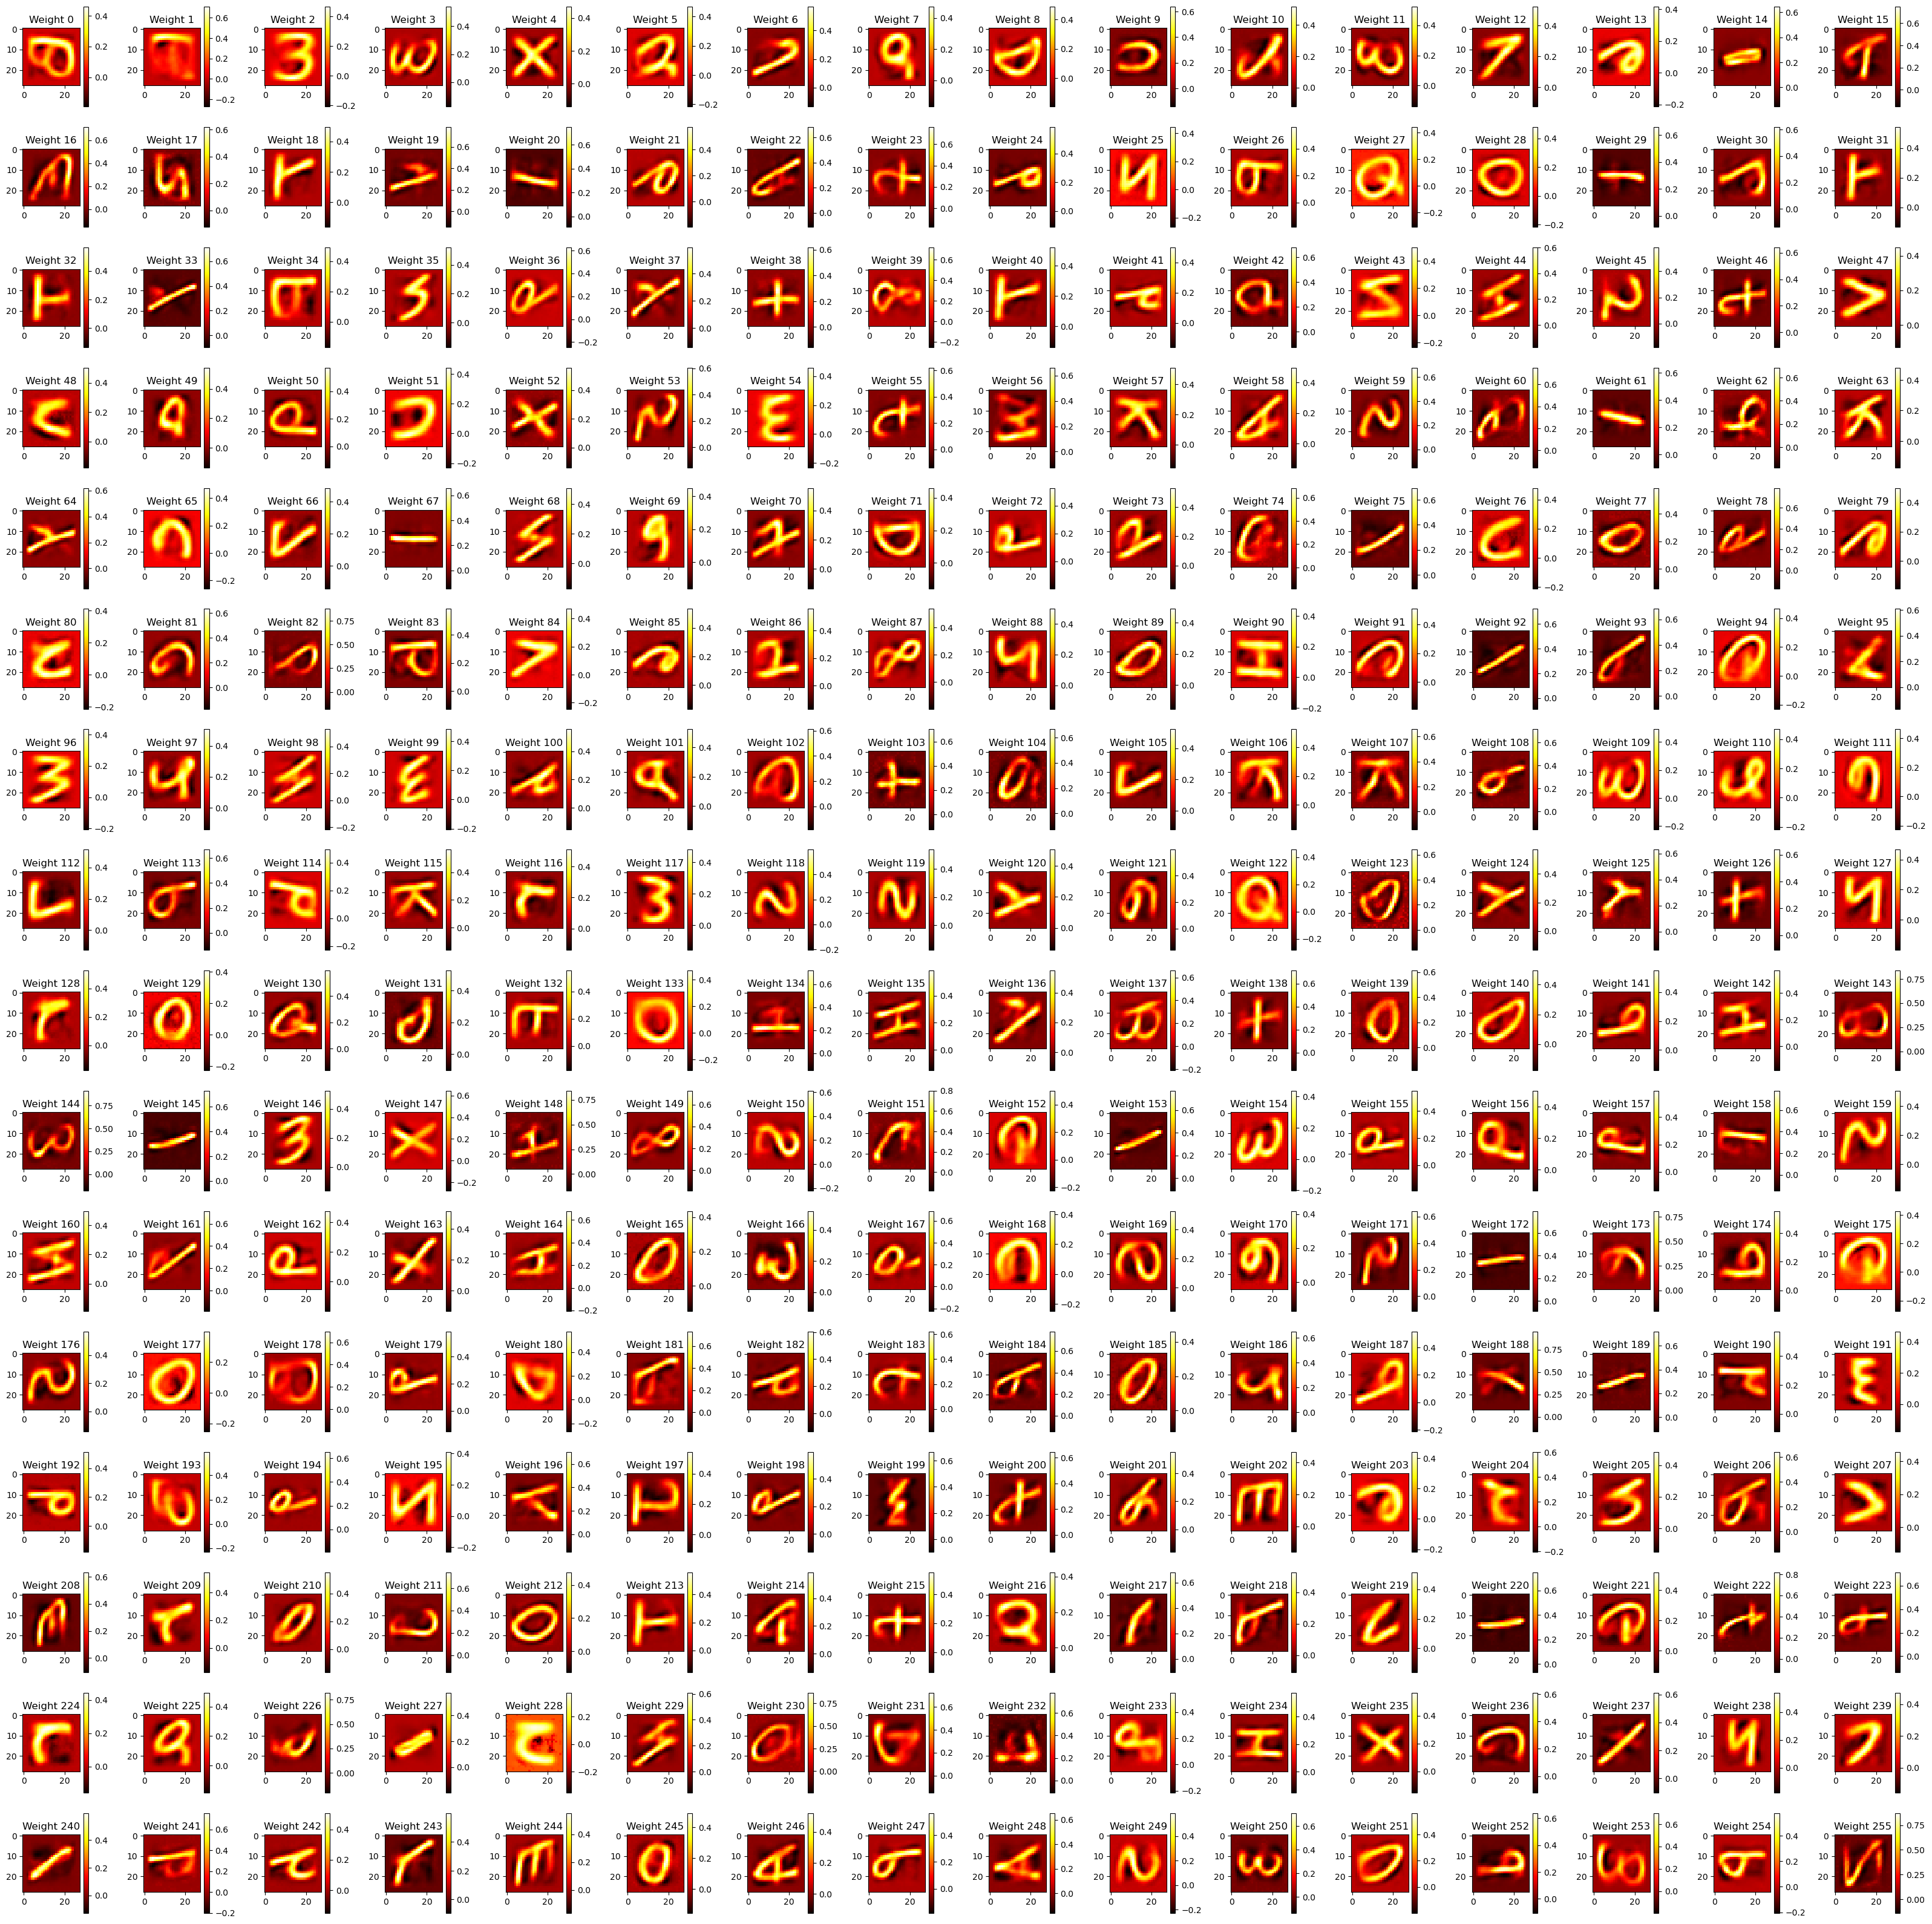

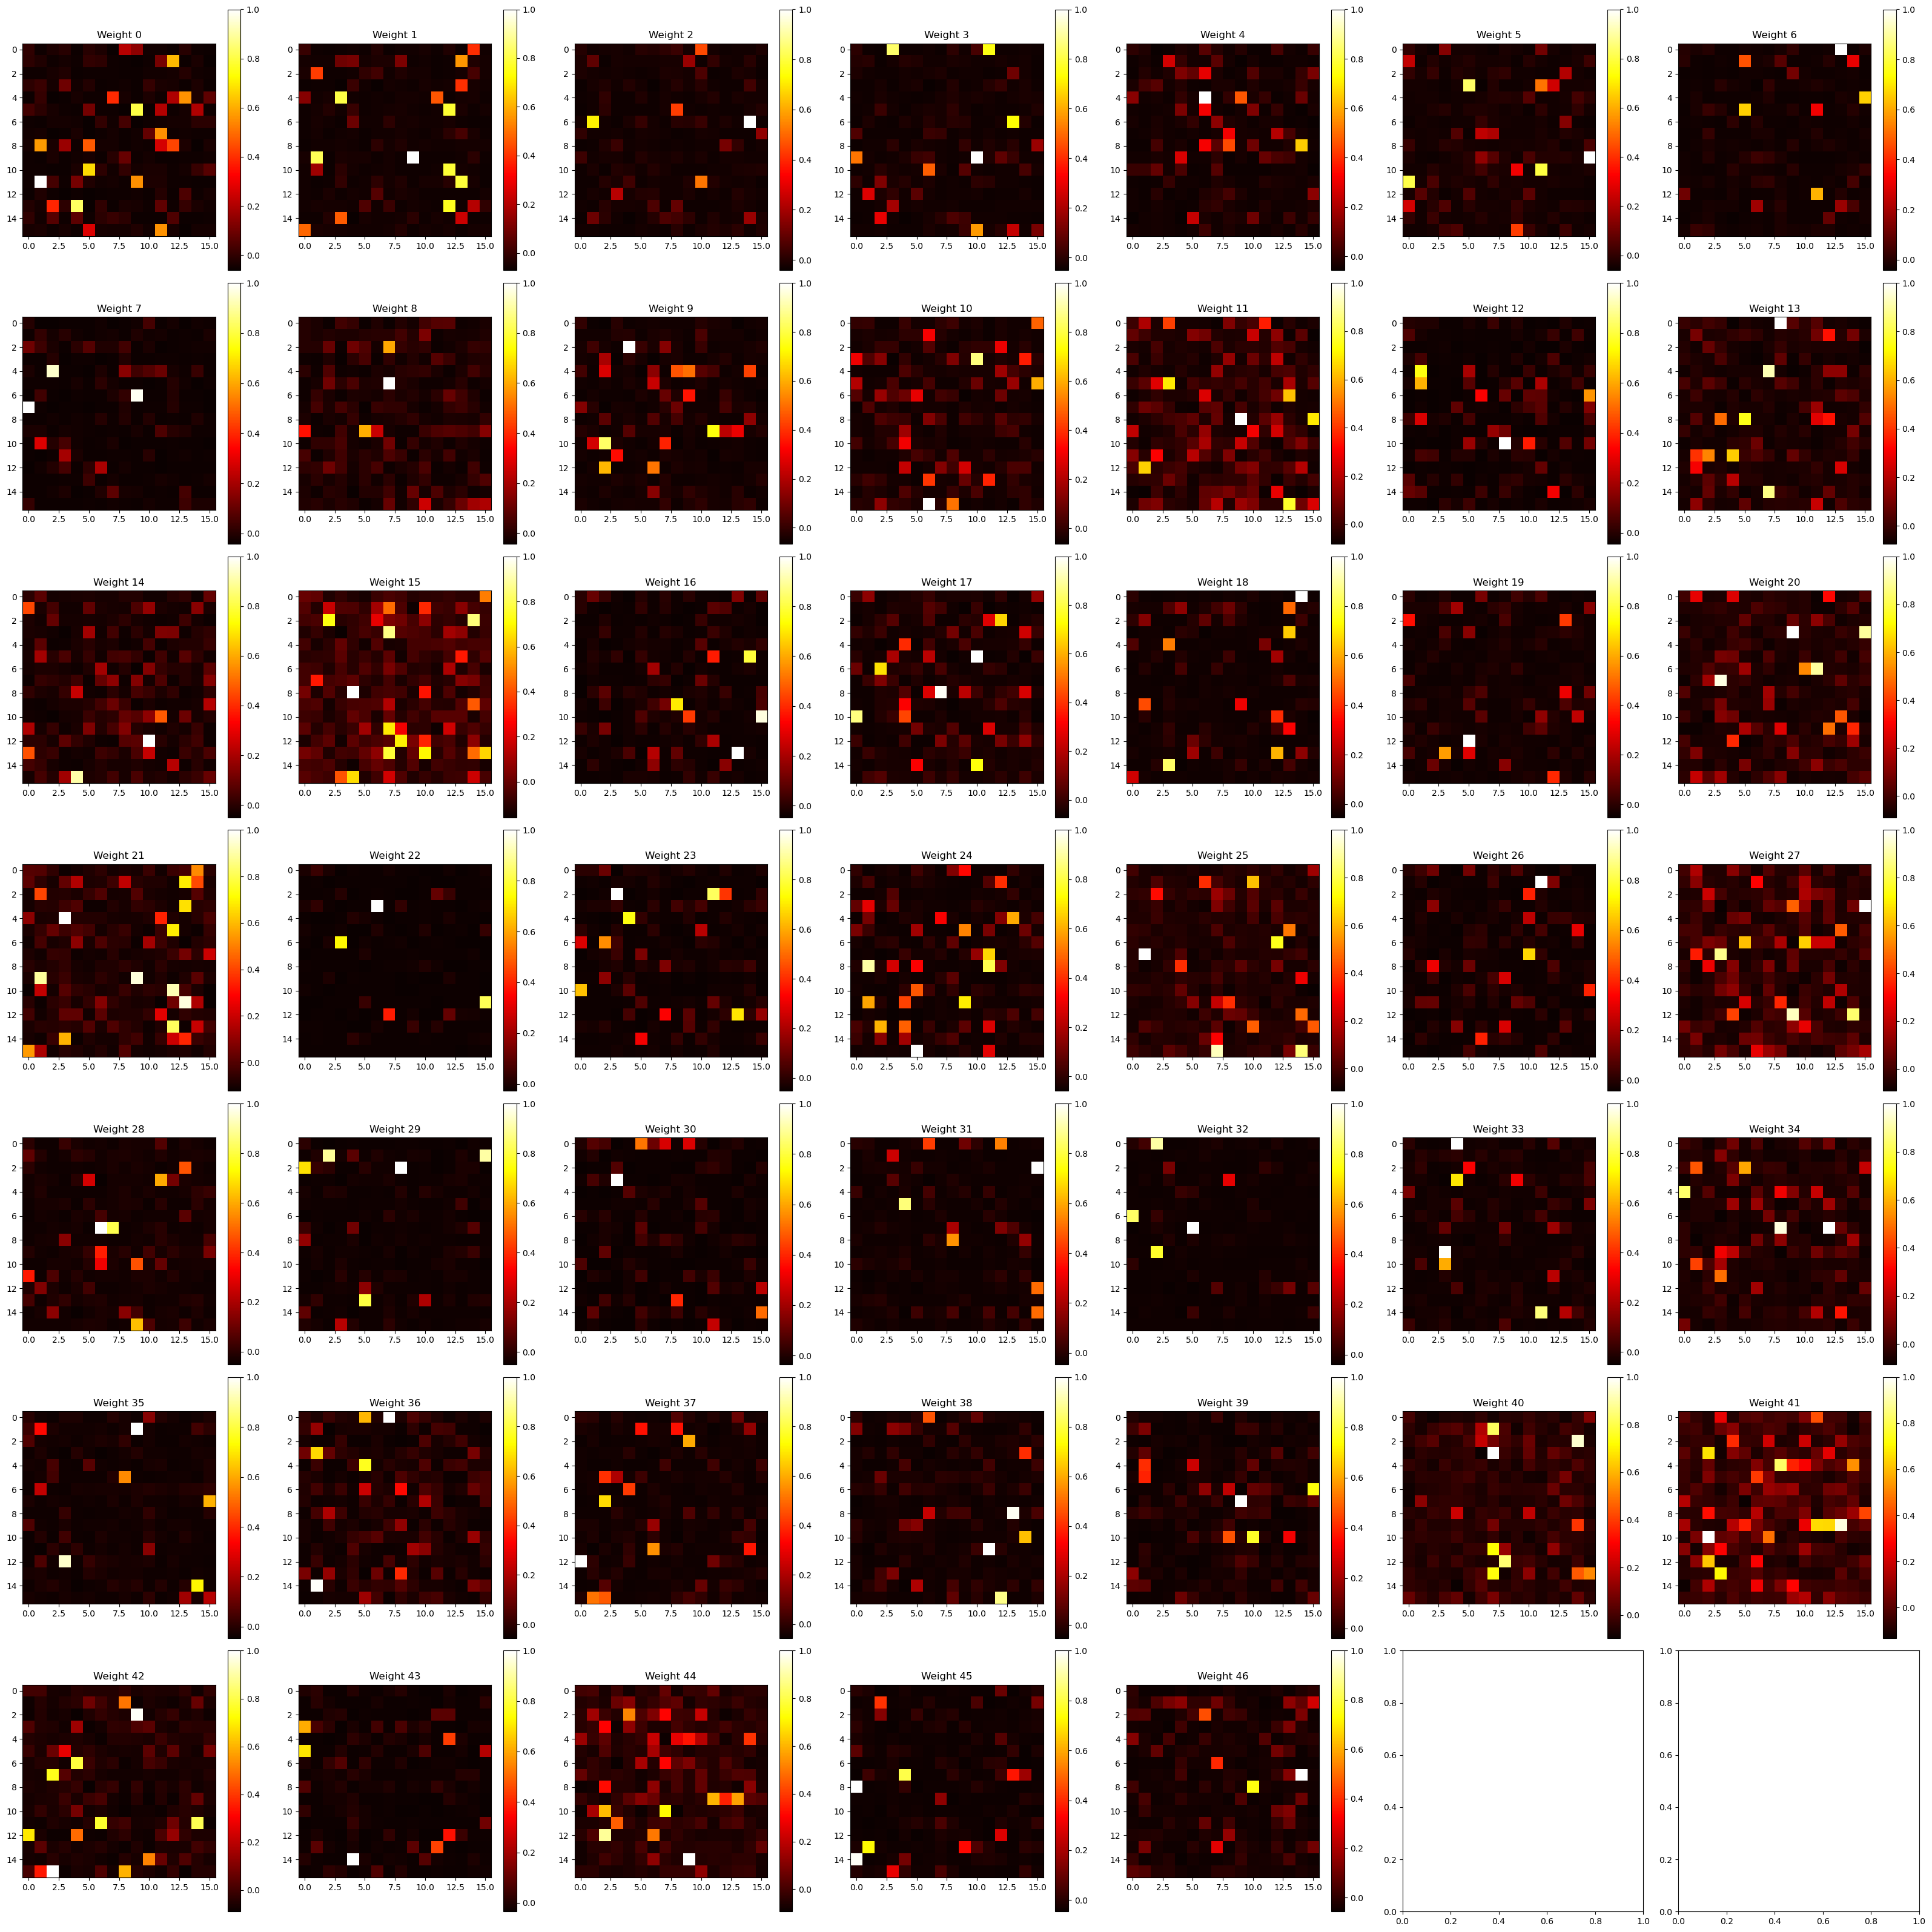

In [341]:
TOPDOWNBaseline_EMNIST.visualize_weights()

In [344]:
print(TopDownBaseline_test_accuracy(TOPDOWNBaseline_EMNIST, emnist_train_loader))
print(TopDownBaseline_test_accuracy(TOPDOWNBaseline_EMNIST, emnist_test_loader))

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.5421808510638297, {45: (1712, 2400), 36: (1390, 2400), 43: (1540, 2400), 15: (951, 2400), 4: (898, 2400), 42: (1647, 2400), 26: (1036, 2400), 32: (1959, 2400), 20: (1048, 2400), 1: (766, 2400), 46: (925, 2400), 13: (1399, 2400), 24: (1297, 2400), 12: (1213, 2400), 5: (1265, 2400), 17: (1464, 2400), 3: (1778, 2400), 40: (1222, 2400), 14: (1118, 2400), 44: (732, 2400), 19: (740, 2400), 29: (1703, 2400), 25: (1356, 2400), 35: (1828, 2400), 28: (1477, 2400), 23: (1520, 2400), 22: (1925, 2400), 34: (1094, 2400), 9: (731, 2400), 30: (893, 2400), 38: (1693, 2400), 39: (1285, 2400), 37: (580, 2400), 31: (1747, 2400), 16: (1587, 2400), 7: (1799, 2400), 2: (1360, 2400), 8: (818, 2400), 10: (1268, 2400), 6: (1781, 2400), 27: (1294, 2400), 33: (1682, 2400), 11: (1388, 2400), 18: (800, 2400), 41: (1044, 2400), 0: (1387, 2400), 21: (1018, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.5377659574468086, {19: (127, 400), 4: (153, 400), 27: (211, 400), 13: (228, 400), 8: (138, 400), 34: (184, 400), 35: (301, 400), 28: (234, 400), 14: (192, 400), 23: (244, 400), 41: (166, 400), 38: (292, 400), 37: (103, 400), 18: (145, 400), 45: (277, 400), 9: (118, 400), 42: (271, 400), 1: (141, 400), 24: (222, 400), 11: (224, 400), 25: (206, 400), 7: (300, 400), 46: (152, 400), 29: (276, 400), 43: (248, 400), 32: (348, 400), 15: (149, 400), 6: (291, 400), 44: (106, 400), 26: (176, 400), 20: (178, 400), 12: (204, 400), 36: (215, 400), 30: (119, 400), 39: (220, 400), 21: (195, 400), 5: (204, 400), 31: (289, 400), 40: (189, 400), 10: (203, 400), 16: (262, 400), 22: (316, 400), 17: (233, 400), 0: (245, 400), 3: (307, 400), 2: (227, 400), 33: (281, 400)})


#### Gaussian

In [359]:
gaussian_td = []
for idx in range(5):
    d = TopDownBaseline_test_accuracy(TOPDOWNBaseline_EMNIST, emnist_test_dataloader_gaussian[idx])
    gaussian_td.append(d[0])

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

#### Speckle

In [360]:
speckle_td = []
for idx in range(5):
    d = TopDownBaseline_test_accuracy(TOPDOWNBaseline_EMNIST, emnist_test_dataloader_speckle[idx])
    speckle_td.append(d[0])

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

#### Occlusion

In [361]:
occlusion_td = []
for idx in range(5):
    d = TopDownBaseline_test_accuracy(TOPDOWNBaseline_EMNIST, emnist_test_dataloader_occlusion[idx])
    occlusion_td.append(d[0])

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

#### Average Blur

In [362]:
averageblur_td = []
for idx in range(5):
    d = TopDownBaseline_test_accuracy(TOPDOWNBaseline_EMNIST, emnist_test_dataloader_averageblur[idx])
    averageblur_td.append(d[0])

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

## Noise Graphs

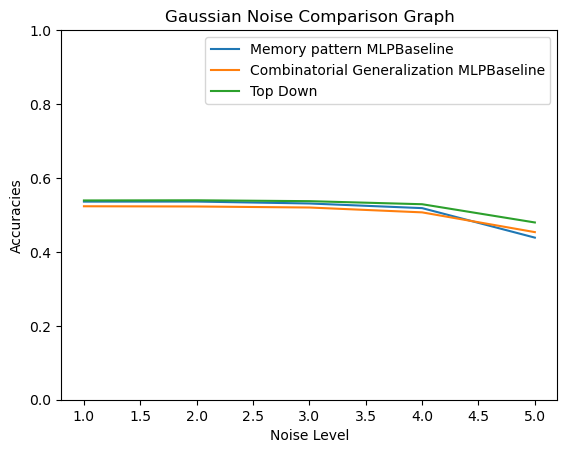

In [367]:
xs = [1,2,3,4,5]
plt.plot(xs, gaussian_mlp_mp, label='Memory pattern MLPBaseline')
plt.plot(xs, gaussian_mlp_cg, label='Combinatorial Generalization MLPBaseline')
plt.plot(xs, gaussian_td, label='Top Down')
plt.legend()
plt.ylim(0,1)
plt.xlabel('Noise Level')
plt.ylabel('Accuracies')
plt.title('Gaussian Noise Comparison Graph')
plt.show()

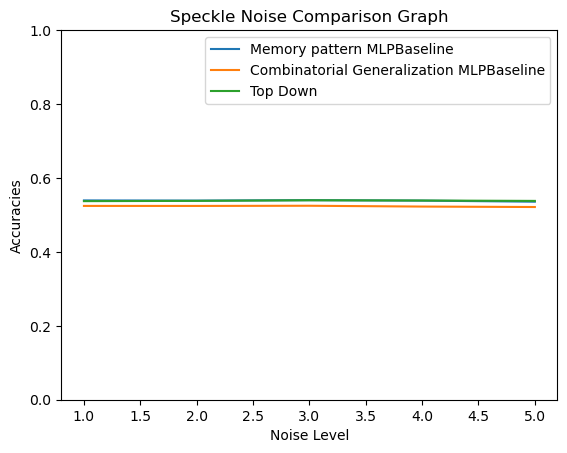

In [368]:
plt.plot(xs, speckle_mlp_mp, label='Memory pattern MLPBaseline')
plt.plot(xs, speckle_mlp_cg, label='Combinatorial Generalization MLPBaseline')
plt.plot(xs, speckle_td, label='Top Down')
plt.legend()
plt.ylim(0,1)
plt.xlabel('Noise Level')
plt.ylabel('Accuracies')
plt.title('Speckle Noise Comparison Graph')
plt.show()

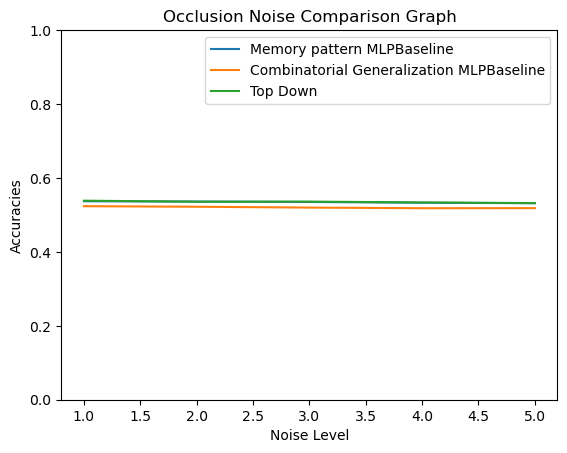

In [369]:
plt.plot(xs, occlusion_mlp_mp, label='Memory pattern MLPBaseline')
plt.plot(xs, occlusion_mlp_cg, label='Combinatorial Generalization MLPBaseline')
plt.plot(xs, occlusion_td, label='Top Down')
plt.legend()
plt.ylim(0,1)
plt.xlabel('Noise Level')
plt.ylabel('Accuracies')
plt.title('Occlusion Noise Comparison Graph')
plt.show()

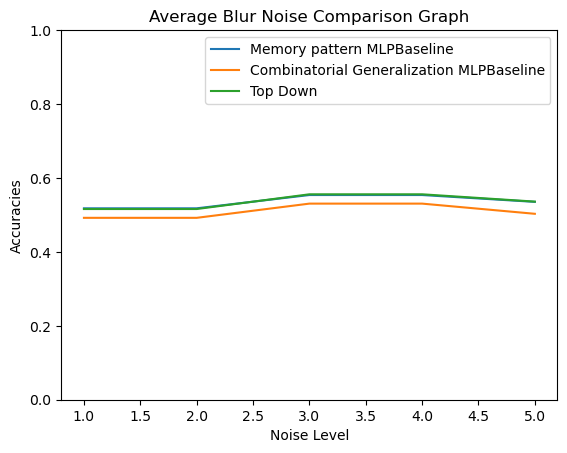

In [370]:
plt.plot(xs, averageblur_mlp_mp, label='Memory pattern MLPBaseline')
plt.plot(xs, averageblur_mlp_cg, label='Combinatorial Generalization MLPBaseline')
plt.plot(xs, averageblur_td, label='Top Down')
plt.legend()
plt.ylim(0,1)
plt.xlabel('Noise Level')
plt.ylabel('Accuracies')
plt.title('Average Blur Noise Comparison Graph')
plt.show()